## Este siguiente codigo implementa bien CL y logra 0.7 de acc en FITB

In [1]:
# OutfitTransformer CIR with Curriculum Learning (Optimizado para category_id)

# ------------------------------
# Section 1: Setup and Imports
# ------------------------------

# Import standard libraries for data handling, logging, and visualization
import json
import logging
import os
import pathlib
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter, defaultdict
from tqdm import tqdm
from typing import Any, Dict, List, Literal, Optional
from dataclasses import dataclass

# Import PyTorch and related modules for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn.functional as F

# Import torchvision for image preprocessing
import torchvision.transforms as transforms

# Import transformers for CLIP model
from transformers import CLIPProcessor, CLIPModel

# Import sklearn for metrics
from sklearn.metrics import roc_auc_score

# Disable tokenizer parallelism to avoid warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Define project-wide paths
SRC_DIR = pathlib.Path(os.getcwd()).absolute()
LOGS_DIR = SRC_DIR / 'logs'
CHECKPOINT_DIR = SRC_DIR / 'checkpoints'
POLYVORE_DIR = './datasets/polyvore'
POLYVORE_METADATA_PATH = f"{POLYVORE_DIR}/item_metadata.json"
POLYVORE_IMAGE_DATA_PATH = f"{POLYVORE_DIR}/images/{{item_id}}.jpg"
POLYVORE_PRECOMPUTED_CLIP_EMBEDDING_DIR = f"{POLYVORE_DIR}/precomputed_clip_embeddings"
POLYVORE_TASK_DATA_PATH = f"{POLYVORE_DIR}/{{dataset_type}}/{{dataset_task}}/{{dataset_split}}.json"
POLYVORE_SET_DATA_PATH = f"{POLYVORE_DIR}/{{dataset_type}}/{{dataset_split}}.json"

# Create directories if they don't exist
os.makedirs(LOGS_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR / 'compatibility_clip', exist_ok=True)
os.makedirs(CHECKPOINT_DIR / 'complementary_clip', exist_ok=True)
os.makedirs(POLYVORE_PRECOMPUTED_CLIP_EMBEDDING_DIR, exist_ok=True)

# Configure logging for the entire notebook
logging.basicConfig(
    filename=LOGS_DIR / 'outfit_transformer.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger('outfit_transformer')

# Log notebook start
logger.info("Starting OutfitTransformer notebook")
print("Starting OutfitTransformer notebook")

# ------------------------------
# Section 2: Utility Functions and Classes
# ------------------------------

# Utility function to set random seeds for reproducibility
def seed_everything(seed=42):
    """Set random seeds for reproducibility across random, numpy, and PyTorch.

    Args:
        seed (int): Random seed value (default: 42).
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    logger.info(f"Set random seed to {seed}")

# Set seed for reproducibility
seed_everything(42)

# FashionItem class to represent items in the Polyvore dataset (modificado para incluir category_id)
class FashionItem:
    """Represents a fashion item with metadata, image, and embedding.

    Attributes:
        item_id (str): Unique identifier for the item.
        category (str): Semantic category (e.g., top, bottom, shoes).
        category_id (int): Subcategory ID of the item.
        image (PIL.Image or None): Loaded image of the item.
        description (str): Text description or title of the item.
        metadata (dict): Additional metadata from item_metadata.json.
        embedding (np.ndarray or None): Precomputed CLIP embedding (1024,).
    """
    def __init__(self, item_id, category, category_id, image=None, description="", metadata=None, embedding=None):
        self.item_id = item_id
        self.category = category
        self.category_id = category_id
        self.image = image
        self.description = description
        self.metadata = metadata or {}
        self.embedding = embedding

# Load metadata from item_metadata.json
def load_metadata(dataset_dir):
    """Load item metadata from item_metadata.json.

    Args:
        dataset_dir (str): Path to the Polyvore dataset directory.

    Returns:
        dict: Dictionary mapping item_id to metadata.
    """
    metadata = {}
    with open(POLYVORE_METADATA_PATH.format(dataset_dir=dataset_dir), 'r') as f:
        metadata_ = json.load(f)
        for item in metadata_:
            metadata[item['item_id']] = item
    logger.info(f"Loaded {len(metadata)} metadata entries")
    print(f"Loaded {len(metadata)} metadata entries")
    return metadata

# Load image for an item
def load_image(dataset_dir, item_id, size=(224, 224)):
    """Load an image for a given item_id.

    Args:
        dataset_dir (str): Path to the Polyvore dataset directory.
        item_id (str): Unique identifier for the item.
        size (tuple): Target image size (height, width) (default: (224, 224)).

    Returns:
        PIL.Image or None: Loaded image or None if loading fails.
    """
    image_path = POLYVORE_IMAGE_DATA_PATH.format(dataset_dir=dataset_dir, item_id=item_id)
    try:
        image = Image.open(image_path).convert('RGB')
        return image
    except Exception as e:
        logger.error(f"Error loading image {image_path}: {e}")
        print(f"Error loading image {image_path}: {e}")
        return None

# Load a FashionItem object (modificado para incluir category_id)
def load_item(dataset_dir, metadata, item_id, should_load_image=False, embedding_dict=None):
    """Load a FashionItem object with metadata, image, and embedding.

    Args:
        dataset_dir (str): Path to the Polyvore dataset directory.
        metadata (dict): Dictionary of item metadata.
        item_id (str): Unique identifier for the item.
        should_load_image (bool): Whether to load the item image.
        embedding_dict (dict or None): Dictionary mapping item_id to CLIP embedding.

    Returns:
        FashionItem: Object containing item data.
    """
    metadata_ = metadata[item_id]
    return FashionItem(
        item_id=metadata_['item_id'],
        category=metadata_['semantic_category'],
        category_id=metadata_['category_id'],
        image=load_image(dataset_dir, metadata_['item_id']) if should_load_image else None,
        description=metadata_['title'] if metadata_.get('title') else metadata_['url_name'],
        metadata=metadata_,
        embedding=embedding_dict[item_id] if embedding_dict else None
    )

# Load precomputed CLIP embeddings
def load_embedding_dict(dataset_dir):
    """Load precomputed CLIP embeddings from .pkl files.

    Args:
        dataset_dir (str): Path to the Polyvore dataset directory.

    Returns:
        dict: Dictionary mapping item_id to embedding (1024,).
    """
    e_dir = POLYVORE_PRECOMPUTED_CLIP_EMBEDDING_DIR.format(polyvore_dir=dataset_dir)
    filenames = [f for f in os.listdir(e_dir) if f.endswith('.pkl') and 'official' not in f]
    filenames.sort(key=lambda x: int(x.split('.')[0].split('_')[-1]))

    all_ids, all_embeddings = [], []
    for filename in filenames:
        filepath = os.path.join(e_dir, filename)
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
            all_ids += data['ids']
            all_embeddings.append(data['embeddings'])

    all_embeddings = np.concatenate(all_embeddings, axis=0)  # (n_items, 1024)
    embedding_dict = {item_id: embedding for item_id, embedding in zip(all_ids, all_embeddings)}
    logger.info(f"Loaded {len(all_embeddings)} embeddings into dictionary")
    print(f"Loaded {len(all_embeddings)} embeddings into dictionary")
    return embedding_dict

# Load task data from JSON files
def load_task_data(dataset_dir, dataset_type, task, dataset_split):
    """Load task-specific data from JSON files.

    Args:
        dataset_dir (str): Path to the Polyvore dataset directory.
        dataset_type (str): Dataset type (e.g., 'nondisjoint').
        task (str): Task name (e.g., 'compatibility', 'fill_in_the_blank').
        dataset_split (str): Dataset split (e.g., 'train', 'valid', 'test').

    Returns:
        list: List of task data entries.
    """
    with open(
        POLYVORE_TASK_DATA_PATH.format(
            dataset_dir=dataset_dir,
            dataset_type=dataset_type,
            dataset_task=task,
            dataset_split=dataset_split
        ), 'r'
    ) as f:
        data = json.load(f)
    logger.info(f"Loaded {len(data)} {task} {dataset_split} entries")
    return data

# Load set data for CIR training
def load_set_data(dataset_dir, dataset_type, dataset_split):
    """Load set data for CIR training from JSON files.

    Args:
        dataset_dir (str): Path to the Polyvore dataset directory.
        dataset_type (str): Dataset type (e.g., 'nondisjoint').
        dataset_split (str): Dataset split (e.g., 'train', 'valid', 'test').

    Returns:
        list: List of set data entries.
    """
    with open(
        POLYVORE_SET_DATA_PATH.format(
            dataset_dir=dataset_dir,
            dataset_type=dataset_type,
            dataset_split=dataset_split
        ), 'r'
    ) as f:
        data = json.load(f)
    logger.info(f"Loaded {len(data)} {dataset_split} set entries")
    return data

# Load checkpoint
def load_checkpoint(model, checkpoint_path):
    """Load a model's state dictionary from a checkpoint file.

    Args:
        model (nn.Module): The model to load the state dictionary into.
        checkpoint_path (str): Path to the checkpoint file (.pth).

    Returns:
        nn.Module: The model with the loaded state dictionary, set to evaluation mode.
    """
    checkpoint = torch.load(checkpoint_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    model.load_state_dict(checkpoint['model'])
    model.eval()
    logger.info(f"Loaded checkpoint from {checkpoint_path}")
    return model

# ------------------------------
# Section 3: Load Precomputed CLIP Embeddings and CP Model
# ------------------------------

# Load metadata and embeddings
metadata = load_metadata(POLYVORE_DIR)
embedding_dict = load_embedding_dict(POLYVORE_DIR)

# Precompute FashionItem objects and item lists for faster sampling
fashion_items = {}
items_by_semantic_category = defaultdict(list)
items_by_category_id = defaultdict(list)

# Also precompute fallback candidates for each category_id
category_id_to_fallback = defaultdict(list)

for item_id in tqdm(metadata.keys(), desc="Precomputing FashionItem objects and lists"):
    item = load_item(POLYVORE_DIR, metadata, item_id, should_load_image=False, embedding_dict=embedding_dict)
    fashion_items[item_id] = item
    items_by_semantic_category[item.category].append(item_id)
    items_by_category_id[item.category_id].append(item_id)
    # Map each category_id to the list of item_ids in its semantic_category
    category_id_to_fallback[item.category_id] = items_by_semantic_category[item.category]

logger.info(f"Precomputed {len(fashion_items)} FashionItem objects")
logger.info(f"Precomputed item lists: {len(items_by_semantic_category)} semantic categories, {len(items_by_category_id)} category IDs")
print(f"Precomputed {len(fashion_items)} FashionItem objects")
print(f"Precomputed item lists: {len(items_by_semantic_category)} semantic categories, {len(items_by_category_id)} category IDs")

# Configuration for OutfitTransformer
@dataclass
class OutfitTransformerConfig:
    """Configuration for OutfitTransformer model."""
    n_items: int = 251008  # Number of unique items in Polyvore
    d_model: int = 128     # Embedding dimension
    n_layers: int = 4      # Number of transformer layers
    n_head: int = 4        # Number of attention heads
    dropout: float = 0.1   # Dropout rate
    item_enc_norm_out: bool = True
    aggregation_method: str = 'concat'

@dataclass
class OutfitCLIPTransformerConfig(OutfitTransformerConfig):
    """Configuration for OutfitCLIPTransformer, extending OutfitTransformerConfig."""
    item_enc_clip_model_name: str = "patrickjohncyh/fashion-clip"

# OutfitTransformer model
class OutfitTransformer(nn.Module):
    """Transformer model for outfit compatibility prediction.

    Architecture:
        - Input: List of outfits, each a list of FashionItem objects with CLIP embeddings (1024,).
        - Linear layer: Projects CLIP embeddings to d_model (1024 -> 128).
        - CLS token: Learnable token prepended to each outfit sequence.
        - Transformer Encoder: Processes outfit embeddings with attention.
        - Classification Head: Maps CLS token embedding to a logit.
    """
    def __init__(self, cfg=OutfitTransformerConfig()):
        super().__init__()
        self.cfg = cfg
        self.fc = nn.Linear(1024, cfg.d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=cfg.d_model, nhead=cfg.n_head, dropout=cfg.dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=cfg.n_layers)
        self.cls_token = nn.Parameter(torch.randn(1, 1, cfg.d_model))
        self.classification_head = nn.Linear(cfg.d_model, 1)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def forward(self, queries, use_precomputed_embedding=True):
        batch_size = len(queries)
        max_len = max(len(query) for query in queries)

        embeddings = []
        mask = []
        for query in queries:
            outfit_embeds = torch.from_numpy(np.array([item.embedding for item in query])).to(
                dtype=torch.float32, device=self.device
            )
            padded_embeds = torch.zeros(max_len, 1024, device=self.device)
            padded_embeds[:len(query)] = outfit_embeds
            embeddings.append(padded_embeds)
            outfit_mask = torch.zeros(max_len, device=self.device)
            outfit_mask[len(query):] = 1
            mask.append(outfit_mask)

        embeddings = torch.stack(embeddings, dim=0)
        mask = torch.stack(mask, dim=0)

        embeddings = self.fc(embeddings)
        cls_token = self.cls_token.expand(batch_size, -1, -1)
        features = torch.cat([cls_token, embeddings], dim=1)
        cls_mask = torch.zeros(batch_size, 1, device=self.device)
        mask = torch.cat([cls_mask, mask], dim=1)

        transformed_features = self.transformer_encoder(features, src_key_padding_mask=mask.bool())
        outfit_embedding = transformed_features[:, 0, :]
        logits = self.classification_head(outfit_embedding)
        return logits.squeeze(-1)

# OutfitCLIPTransformer model
class OutfitCLIPTransformer(OutfitTransformer):
    """OutfitTransformer specialized for CLIP embeddings."""
    def __init__(self, cfg=OutfitCLIPTransformerConfig()):
        super().__init__(cfg)
        logger.info("Initialized OutfitCLIPTransformer")

# Load CP model from checkpoint
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cp_model = OutfitCLIPTransformer(OutfitCLIPTransformerConfig(n_items=len(metadata))).to(device)
checkpoint_path = os.path.join(CHECKPOINT_DIR, 'compatibility_clip', 'epoch_50.pth')
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Checkpoint {checkpoint_path} not found.")
cp_model = load_checkpoint(cp_model, checkpoint_path)
logger.info(f"Loaded CP checkpoint from {checkpoint_path}")

# ------------------------------
# Section 4: Train CIR with Curriculum Learning
# ------------------------------

# Dataset for CIR training
class PolyvoreTripletDataset(Dataset):
    """Dataset for CIR training, generating query-answer pairs."""
    def __init__(self, dataset_dir, dataset_type='nondisjoint', dataset_split='train',
                 metadata=None, embedding_dict=None, load_image=False):
        self.dataset_dir = dataset_dir
        self.metadata = metadata if metadata else load_metadata(dataset_dir)
        self.data = load_set_data(dataset_dir, dataset_type, dataset_split)
        self.load_image = load_image
        self.embedding_dict = embedding_dict
        logger.info(f"{dataset_split} CIR triplet dataset: {len(self.data)} sets")
        print(f"{dataset_split} CIR triplet dataset: {len(self.data)} sets")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        items = [
            load_item(self.dataset_dir, self.metadata, item_id,
                      self.load_image, self.embedding_dict)
            for item_id in self.data[idx]['item_ids']
        ]
        answer = items[random.randint(0, len(items) - 1)]
        outfit = [item for item in items if item != answer]
        return {'query': outfit, 'answer': answer}

# Dataset for CIR validation
class PolyvoreFillInTheBlankDataset(Dataset):
    """Dataset for CIR validation, providing queries and candidate items."""
    def __init__(self, dataset_dir, dataset_type='nondisjoint', dataset_split='valid',
                 metadata=None, embedding_dict=None, load_image=False):
        self.dataset_dir = dataset_dir
        self.metadata = metadata if metadata else load_metadata(dataset_dir)
        self.data = load_task_data(dataset_dir, dataset_type, 'fill_in_the_blank', dataset_split)
        self.load_image = load_image
        self.embedding_dict = embedding_dict
        labels = [item['label'] for item in self.data]
        label_counts = Counter(labels)
        logger.info(f"{dataset_split} CIR FITB dataset: {len(self.data)} outfits, Label distribution: {label_counts}")
        print(f"{dataset_split} CIR FITB dataset: {len(self.data)} outfits, Label distribution: {label_counts}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = self.data[idx]['label']
        candidates = [
            load_item(self.dataset_dir, self.metadata, item_id,
                      self.load_image, self.embedding_dict)
            for item_id in self.data[idx]['answers']
        ]
        outfit = [
            load_item(self.dataset_dir, self.metadata, item_id,
                      self.load_image, self.embedding_dict)
            for item_id in self.data[idx]['question']
        ]
        return {'query': outfit, 'label': label, 'candidates': candidates}

# Collate functions for CIR
def triplet_collate_fn(batch):
    """Collate function for PolyvoreTripletDataset."""
    query = [item['query'] for item in batch]
    answer = [item['answer'] for item in batch]
    return {'query': query, 'answer': answer}

def fitb_collate_fn(batch):
    """Collate function for PolyvoreFillInTheBlankDataset."""
    query = [item['query'] for item in batch]
    label = [item['label'] for item in batch]
    candidates = [item['candidates'] for item in batch]
    return {'query': query, 'label': label, 'candidates': candidates}

# InBatchTripletMarginLoss for CIR
class InBatchTripletMarginLoss(nn.Module):
    """In-batch triplet margin loss for CIR."""
    def __init__(self, margin: float = 2.0, reduction: str = "mean"):
        super().__init__()
        self.margin = margin
        self.reduction = reduction

    def forward(self, batched_q_emb: torch.Tensor, batched_a_emb: torch.Tensor):
        batch_size = batched_q_emb.shape[0]
        dists = torch.cdist(batched_q_emb, batched_a_emb, p=2)
        pos_dists = torch.diag(dists)
        neg_dists = dists.clone()
        neg_dists.fill_diagonal_(float('inf'))
        hardest_neg_dists, _ = neg_dists.min(dim=1)
        loss = torch.relu(pos_dists - hardest_neg_dists + self.margin)

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss

# Metrics for CIR
def compute_cir_scores(predictions: torch.Tensor, labels: torch.Tensor):
    """Compute accuracy for CIR."""
    accuracy = torch.mean((predictions == labels).float()).item()
    return {'acc': accuracy}

# Function to get CLS embedding for CIR
def get_cls_embedding(model, queries, device, use_precomputed_embedding=True):
    """Extract CLS token embedding for CIR."""
    batch_size = len(queries)
    max_len = max(len(query) for query in queries)
    embeddings = []
    mask = []
    for query in queries:
        outfit_embeds = torch.from_numpy(np.array([item.embedding for item in query])).to(
            dtype=torch.float32, device=device
        )
        padded_embeds = torch.zeros(max_len, 1024, device=device)
        padded_embeds[:len(query)] = outfit_embeds
        embeddings.append(padded_embeds)
        outfit_mask = torch.zeros(max_len, device=device)
        outfit_mask[len(query):] = 1
        mask.append(outfit_mask)

    embeddings = torch.stack(embeddings, dim=0)
    mask = torch.stack(mask, dim=0)

    embeddings = model.fc(embeddings)
    cls_token = model.cls_token.expand(batch_size, -1, -1)
    features = torch.cat([cls_token, embeddings], dim=1)
    cls_mask = torch.zeros(batch_size, 1, device=device)
    mask = torch.cat([cls_mask, mask], dim=1)

    transformed_features = model.transformer_encoder(features, src_key_padding_mask=mask.bool())
    outfit_embedding = transformed_features[:, 0, :]
    return outfit_embedding

# Optimized function to sample negatives dynamically
def sample_negatives(answer, items_by_semantic_category, items_by_category_id, category_id_to_fallback, fashion_items, n_negatives=10, use_category_id=False):
    """Sample negative items dynamically for a given answer using precomputed lists.

    Args:
        answer (FashionItem): The correct item (positive).
        items_by_semantic_category (dict): Dict mapping semantic_category to list of item_ids.
        items_by_category_id (dict): Dict mapping category_id to list of item_ids.
        category_id_to_fallback (dict): Dict mapping category_id to its semantic_category item_ids.
        fashion_items (dict): Dict mapping item_id to precomputed FashionItem objects.
        n_negatives (int): Number of negatives to sample.
        use_category_id (bool): If True, sample from the same category_id; otherwise, from semantic_category.

    Returns:
        List[FashionItem]: List of sampled negative items.
    """
    if use_category_id:
        # Sample from the same category_id
        candidate_ids = items_by_category_id.get(answer.category_id, [])
        # Get precomputed fallback candidates (semantic_category items)
        fallback_candidates = category_id_to_fallback.get(answer.category_id, [])
    else:
        # Sample from the same semantic_category
        candidate_ids = items_by_semantic_category.get(answer.category, [])
        fallback_candidates = []

    # Exclude the positive item (answer.item_id) from candidates
    # Use sets for faster membership testing
    answer_id = answer.item_id
    candidate_ids_set = set(candidate_ids) - {answer_id}
    candidate_ids = list(candidate_ids_set)

    # Sample the required number of negatives
    if use_category_id and len(candidate_ids) < n_negatives and fallback_candidates:
        # Need to fill with items from semantic_category
        # Exclude answer.item_id and items already in candidate_ids from fallback
        fallback_candidates_set = set(fallback_candidates) - {answer_id} - candidate_ids_set
        fallback_candidates = list(fallback_candidates_set)
        remaining = n_negatives - len(candidate_ids)
        if len(fallback_candidates) > 0:
            sampled_fallback = random.sample(fallback_candidates, min(remaining, len(fallback_candidates)))
            sampled_ids = candidate_ids + sampled_fallback
        else:
            sampled_ids = candidate_ids
    else:
        # Use all available candidates if fewer than required
        if len(candidate_ids) < n_negatives:
            sampled_ids = candidate_ids
        else:
            sampled_ids = random.sample(candidate_ids, n_negatives)

    # Retrieve precomputed FashionItem objects
    negatives = [fashion_items[item_id] for item_id in sampled_ids]

    # Pad with dummy items if we don't have enough negatives (rare case)
    while len(negatives) < n_negatives:
        # Create a dummy FashionItem with a zero embedding
        dummy_item = FashionItem(
            item_id="dummy",
            category=answer.category,
            category_id=answer.category_id if use_category_id else -1,
            embedding=np.zeros(1024)
        )
        negatives.append(dummy_item)

    return negatives

# Training function for CIR with Curriculum Learning
def train_cir(args, model, train_dataloader, valid_dataloader, optimizer, scheduler, loss_fn, device, metadata, embedding_dict, items_by_semantic_category, items_by_category_id, category_id_to_fallback, fashion_items):
    """Train the Category-aware Image Retrieval model with curriculum learning.

    Args:
        args (Args): Training arguments.
        model (OutfitCLIPTransformer): Model to train.
        train_dataloader (DataLoader): Training DataLoader.
        valid_dataloader (DataLoader): Validation DataLoader.
        optimizer (optim.Optimizer): Optimizer.
        scheduler (optim.lr_scheduler): Learning rate scheduler.
        loss_fn (nn.Module): Loss function (InBatchTripletMarginLoss).
        device (torch.device): Device (CPU/GPU).
        metadata (dict): Item metadata.
        embedding_dict (dict): Dictionary mapping item_id to embedding.
        items_by_semantic_category (dict): Dict mapping semantic_category to list of item_ids.
        items_by_category_id (dict): Dict mapping category_id to list of item_ids.
        category_id_to_fallback (dict): Dict mapping category_id to its semantic_category item_ids.
        fashion_items (dict): Dict mapping item_id to precomputed FashionItem objects.

    Returns:
        tuple: Lists of train_losses, train_accs, valid_accs.
    """
    train_losses, train_accs, valid_accs = [], [], []

    for epoch in range(args.n_epochs):
        # Determine negative sampling strategy based on epoch
        if epoch < 40:
            negative_strategy = "batch"  # Use positives from other examples in the batch
            n_negatives = 0  # Not used in batch mode
            use_category_id = False
        elif 40 <= epoch < 50:
            negative_strategy = "semantic_category"  # Sample 10 negatives from semantic_category
            n_negatives = 10
            use_category_id = False
        else:  # epoch >= 50
            negative_strategy = "category_id"  # Sample 10 negatives from category_id, fallback to semantic_category
            n_negatives = 10
            use_category_id = True

        # Training
        model.train()
        train_loss, all_preds, all_labels = 0.0, [], []
        pbar = tqdm(train_dataloader, desc=f'Train CIR Epoch {epoch+1}/{args.n_epochs} (Neg: {negative_strategy})')
        for i, data in enumerate(pbar):
            queries = data['query']
            answers = data['answer']  # List of FashionItem objects (positives)

            # Compute query embeddings
            batched_q_emb = get_cls_embedding(model, queries, device, use_precomputed_embedding=True)

            if negative_strategy == "batch":
                # Original strategy: negatives are the positives of other examples in the batch
                batched_a_emb = get_cls_embedding(model, [[answer] for answer in answers], device, use_precomputed_embedding=True)
            else:
                # New strategy: sample negatives dynamically for each query
                batched_a_emb_list = []
                for answer in answers:
                    # Positive embedding
                    pos_emb = get_cls_embedding(model, [[answer]], device, use_precomputed_embedding=True)
                    # Sample negatives
                    negatives = sample_negatives(answer, items_by_semantic_category, items_by_category_id, category_id_to_fallback, fashion_items, n_negatives, use_category_id)
                    neg_embs = get_cls_embedding(model, [[neg] for neg in negatives], device, use_precomputed_embedding=True)
                    # Combine positive and negatives
                    combined_emb = torch.cat([pos_emb, neg_embs], dim=0)  # (1 + n_negatives, d_model)
                    batched_a_emb_list.append(combined_emb)

                # Stack to form (batch_size, 1 + n_negatives, d_model)
                batched_a_emb = torch.stack(batched_a_emb_list)

            # Compute loss
            if negative_strategy == "batch":
                # In-batch triplet loss
                loss = loss_fn(batched_q_emb, batched_a_emb) / args.accumulation_steps
            else:
                # Compute distances for each query to its positives and negatives
                batch_size = batched_q_emb.shape[0]
                dists = torch.norm(batched_q_emb.unsqueeze(1) - batched_a_emb, dim=-1)  # (batch_size, 1 + n_negatives)
                pos_dists = dists[:, 0]  # Distances to positives (batch_size,)
                neg_dists = dists[:, 1:]  # Distances to negatives (batch_size, n_negatives)
                hardest_neg_dists, _ = neg_dists.min(dim=1)  # (batch_size,)
                loss = torch.relu(pos_dists - hardest_neg_dists + loss_fn.margin) / args.accumulation_steps
                if loss_fn.reduction == "mean":
                    loss = loss.mean()
                elif loss_fn.reduction == "sum":
                    loss = loss.sum()

            loss.backward()

            # Gradient accumulation
            if (i + 1) % args.accumulation_steps == 0:
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()
                scheduler.step()

            train_loss += loss.item() * args.accumulation_steps

            # Compute predictions for accuracy
            if negative_strategy == "batch":
                dists = torch.cdist(batched_q_emb, batched_a_emb, p=2)
                preds = torch.argmin(dists, dim=1)
                labels = torch.arange(len(preds), device=device, dtype=torch.long)  # Correct labels for in-batch mode
            else:
                dists = torch.norm(batched_q_emb.unsqueeze(1) - batched_a_emb, dim=-1)
                preds = torch.argmin(dists, dim=1)
                labels = torch.zeros(len(preds), device=device, dtype=torch.long)  # Positive is always at index 0

            all_preds.append(preds.detach())
            all_labels.append(labels.detach())

            score = compute_cir_scores(preds, labels)
            pbar.set_postfix(loss=loss.item() * args.accumulation_steps, acc=score['acc'])

        train_loss /= len(train_dataloader)
        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        train_scores = compute_cir_scores(all_preds, all_labels)
        train_losses.append(train_loss)
        train_accs.append(train_scores['acc'])
        logger.info(f'Epoch {epoch+1}/{args.n_epochs} Train CIR --> Loss: {train_loss:.4f}, '
                   f'Acc: {train_scores["acc"]:.4f}')
        print(f'Epoch {epoch+1}/{args.n_epochs} Train CIR --> Loss: {train_loss:.4f}, '
              f'Acc: {train_scores["acc"]:.4f}')

        # Validation
        model.eval()
        all_preds, all_labels = [], []
        pbar = tqdm(valid_dataloader, desc=f'Valid CIR Epoch {epoch+1}/{args.n_epochs}')
        with torch.no_grad():
            for i, data in enumerate(pbar):
                queries = data['query']
                candidates = data['candidates']
                labels = torch.tensor(data['label'], device=device)

                batched_q_emb = get_cls_embedding(model, queries, device,
                                                use_precomputed_embedding=True).unsqueeze(1)
                batched_c_embs = []
                for cand_group in candidates:
                    cand_embs = get_cls_embedding(model, [[cand] for cand in cand_group], device,
                                                 use_precomputed_embedding=True)
                    batched_c_embs.append(cand_embs)
                batched_c_embs = torch.stack(batched_c_embs)

                dists = torch.norm(batched_q_emb - batched_c_embs, dim=-1)
                preds = torch.argmin(dists, dim=-1)

                all_preds.append(preds)
                all_labels.append(labels)

                score = compute_cir_scores(preds, labels)
                pbar.set_postfix(acc=score['acc'])

        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        valid_scores = compute_cir_scores(all_preds, all_labels)
        valid_accs.append(valid_scores['acc'])
        logger.info(f'Epoch {epoch+1}/{args.n_epochs} Valid FITB --> Acc: {valid_scores["acc"]:.4f}')
        print(f'Epoch {epoch+1}/{args.n_epochs} Valid FITB --> Acc: {valid_scores["acc"]:.4f}')

        # Save checkpoint
        checkpoint_path = os.path.join(CHECKPOINT_DIR, 'complementary_clip', f'epoch_{epoch+1}.pth')
        torch.save({'config': model.cfg.__dict__, 'model': model.state_dict()}, checkpoint_path)
        logger.info(f'Checkpoint saved at {checkpoint_path}')
        print(f'Checkpoint saved at {checkpoint_path}')

    return train_losses, train_accs, valid_accs

# Configuration for CIR training
class CIRArgs:
    """Configuration for Category-aware Image Retrieval training."""
    model_type = 'clip'
    polyvore_dir = POLYVORE_DIR
    polyvore_type = 'nondisjoint'
    batch_sz_per_gpu = 32
    n_workers_per_gpu = 4
    n_epochs = 200
    lr = 2e-5
    accumulation_steps = 4
    wandb_key = None
    seed = 42
    checkpoint = os.path.join(CHECKPOINT_DIR, 'compatibility_clip', 'epoch_50.pth')
    world_size = 1
    project_name = 'complementary_clip_notebook'
    demo = False

cir_args = CIRArgs()
logger.info(f"CIR Arguments: {vars(cir_args)}")
print(f"CIR Arguments: {vars(cir_args)}")

# Load datasets for CIR
train_cir_dataset = PolyvoreTripletDataset(
    dataset_dir=cir_args.polyvore_dir,
    dataset_type=cir_args.polyvore_type,
    dataset_split='train',
    metadata=metadata,
    embedding_dict=embedding_dict,
    load_image=False
)

valid_cir_dataset = PolyvoreFillInTheBlankDataset(
    dataset_dir=cir_args.polyvore_dir,
    dataset_type=cir_args.polyvore_type,
    dataset_split='valid',
    metadata=metadata,
    embedding_dict=embedding_dict,
    load_image=False
)

# Create DataLoaders
train_cir_dataloader = DataLoader(
    dataset=train_cir_dataset,
    batch_size=cir_args.batch_sz_per_gpu,
    shuffle=True,
    num_workers=cir_args.n_workers_per_gpu,
    collate_fn=triplet_collate_fn
)

valid_cir_dataloader = DataLoader(
    dataset=valid_cir_dataset,
    batch_size=cir_args.batch_sz_per_gpu,
    shuffle=False,
    num_workers=cir_args.n_workers_per_gpu,
    collate_fn=fitb_collate_fn
)

# Initialize model, optimizer, scheduler, and loss
cir_model = OutfitCLIPTransformer(OutfitCLIPTransformerConfig(n_items=len(metadata))).to(device)
if not os.path.exists(cir_args.checkpoint):
    raise FileNotFoundError(f"Checkpoint {cir_args.checkpoint} not found.")
cir_model = load_checkpoint(cir_model, cir_args.checkpoint)
logger.info(f"Loaded CP checkpoint from {cir_args.checkpoint}")

cir_optimizer = optim.AdamW(cir_model.parameters(), lr=cir_args.lr)
cir_scheduler = optim.lr_scheduler.OneCycleLR(
    cir_optimizer,
    max_lr=cir_args.lr,
    epochs=cir_args.n_epochs,
    steps_per_epoch=int(len(train_cir_dataloader) / cir_args.accumulation_steps),
    pct_start=0.3,
    anneal_strategy='cos',
    div_factor=25,
    final_div_factor=1e4
)
cir_loss_fn = InBatchTripletMarginLoss(margin=2.0, reduction='mean')


/home/ia/Documentos/TFG_Lara/TransformingFashion/outfit_transformer_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Starting OutfitTransformer notebook
Loaded 251008 metadata entries
Loaded 251008 embeddings into dictionary


Precomputing FashionItem objects and lists: 100%|██████████| 251008/251008 [00:00<00:00, 298378.44it/s]
/tmp/ipykernel_2256261/2306690114.py:268: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exper

Precomputed 251008 FashionItem objects
Precomputed item lists: 11 semantic categories, 153 category IDs
CIR Arguments: {}
train CIR triplet dataset: 53306 sets
valid CIR FITB dataset: 5000 outfits, Label distribution: Counter({0: 5000})


In [ ]:

# Train CIR model with curriculum learning
train_cir_losses, train_cir_accs, valid_cir_accs = train_cir(
    cir_args, cir_model, train_cir_dataloader, valid_cir_dataloader,
    cir_optimizer, cir_scheduler, cir_loss_fn, device, metadata, embedding_dict,
    items_by_semantic_category, items_by_category_id, category_id_to_fallback, fashion_items
)


Train CIR Epoch 1/200 (Neg: batch): 100%|██████████| 1666/1666 [00:25<00:00, 66.38it/s, acc=0.154, loss=2.54] 


Epoch 1/200 Train CIR --> Loss: 2.8466, Acc: 0.1114


Valid CIR Epoch 1/200:   0%|          | 0/157 [00:00<?, ?it/s]/home/ia/Documentos/TFG_Lara/TransformingFashion/outfit_transformer_env/lib/python3.12/site-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(
Valid CIR Epoch 1/200: 100%|██████████| 157/157 [00:08<00:00, 18.92it/s, acc=1]    


Epoch 1/200 Valid FITB --> Acc: 0.6044
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/complementary_clip/epoch_1.pth


Train CIR Epoch 2/200 (Neg: batch): 100%|██████████| 1666/1666 [00:24<00:00, 67.62it/s, acc=0.0769, loss=2.69]


Epoch 2/200 Train CIR --> Loss: 2.7144, Acc: 0.1163


Valid CIR Epoch 2/200: 100%|██████████| 157/157 [00:08<00:00, 18.56it/s, acc=1]    


Epoch 2/200 Valid FITB --> Acc: 0.6100
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/complementary_clip/epoch_2.pth


Train CIR Epoch 3/200 (Neg: batch): 100%|██████████| 1666/1666 [00:25<00:00, 64.89it/s, acc=0.0769, loss=2.73]


Epoch 3/200 Train CIR --> Loss: 2.6234, Acc: 0.1153


Valid CIR Epoch 3/200: 100%|██████████| 157/157 [00:08<00:00, 18.77it/s, acc=1]    


Epoch 3/200 Valid FITB --> Acc: 0.6128
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/complementary_clip/epoch_3.pth


Train CIR Epoch 4/200 (Neg: batch): 100%|██████████| 1666/1666 [00:25<00:00, 65.13it/s, acc=0.154, loss=2.44] 


Epoch 4/200 Train CIR --> Loss: 2.5407, Acc: 0.1157


Valid CIR Epoch 4/200: 100%|██████████| 157/157 [00:08<00:00, 18.31it/s, acc=1]    


Epoch 4/200 Valid FITB --> Acc: 0.6088
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/complementary_clip/epoch_4.pth


Train CIR Epoch 5/200 (Neg: batch): 100%|██████████| 1666/1666 [00:25<00:00, 64.55it/s, acc=0.0769, loss=2.55]


Epoch 5/200 Train CIR --> Loss: 2.4779, Acc: 0.1143


Valid CIR Epoch 5/200: 100%|██████████| 157/157 [00:08<00:00, 18.11it/s, acc=1]    


Epoch 5/200 Valid FITB --> Acc: 0.6134
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/complementary_clip/epoch_5.pth


Train CIR Epoch 6/200 (Neg: batch): 100%|██████████| 1666/1666 [00:26<00:00, 62.97it/s, acc=0.269, loss=2.18] 


Epoch 6/200 Train CIR --> Loss: 2.4071, Acc: 0.1140


Valid CIR Epoch 6/200: 100%|██████████| 157/157 [00:08<00:00, 18.54it/s, acc=1]    


Epoch 6/200 Valid FITB --> Acc: 0.6166
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/complementary_clip/epoch_6.pth


Train CIR Epoch 7/200 (Neg: batch): 100%|██████████| 1666/1666 [00:25<00:00, 64.32it/s, acc=0.0769, loss=2.29]


Epoch 7/200 Train CIR --> Loss: 2.3439, Acc: 0.1087


Valid CIR Epoch 7/200: 100%|██████████| 157/157 [00:08<00:00, 17.70it/s, acc=1]    


Epoch 7/200 Valid FITB --> Acc: 0.6146
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/complementary_clip/epoch_7.pth


Train CIR Epoch 8/200 (Neg: batch): 100%|██████████| 1666/1666 [00:25<00:00, 66.47it/s, acc=0.115, loss=2.2]  


Epoch 8/200 Train CIR --> Loss: 2.2817, Acc: 0.1053


Valid CIR Epoch 8/200: 100%|██████████| 157/157 [00:08<00:00, 18.50it/s, acc=0.875]


Epoch 8/200 Valid FITB --> Acc: 0.6186
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TransformingFashion/checkpoints/complementary_clip/epoch_8.pth


Train CIR Epoch 9/200 (Neg: batch):  51%|█████▏    | 856/1666 [00:12<00:11, 69.46it/s, acc=0.0312, loss=2.24]

In [ ]:

# Plot CIR training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_cir_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('CIR Training Loss')
plt.subplot(1, 2, 2)
plt.plot(train_cir_accs, label='Train Acc')
plt.plot(valid_cir_accs, label='Valid Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('CIR Training and Validation Accuracy')
plt.tight_layout()
plt.show()

best_acc, best_epoch = max(zip(valid_cir_accs, range(1, cir_args.n_epochs + 1)))
print(f"Best CIR Validation Accuracy: {best_acc:.4f} at Epoch {best_epoch}")

## Evaluamos en FITB test

In [3]:
# Section 8: Evaluate CIR on Test Set
#
# This cell evaluates the Category-aware Image Retrieval (CIR) model on the test set
# (fill_in_the_blank/test.json) to report the accuracy (equivalent to Recall@5).
# It initializes the model and loads a checkpoint before evaluation.

# Function to evaluate CIR on test set
def evaluate_cir(model, test_dataloader, device):
    """Evaluate the Category-aware Image Retrieval model on the test set.
    
    Args:
        model (OutfitCLIPTransformer): Trained model.
        test_dataloader (DataLoader): Test DataLoader.
        device (torch.device): Device (CPU/GPU).
    
    Returns:
        float: Test accuracy (Recall@5 equivalent for FITB).
    """
    model.eval()
    all_preds, all_labels = [], []
    pbar = tqdm(test_dataloader, desc='Evaluating CIR on Test')
    with torch.no_grad():
        for data in pbar:
            queries = data['query']
            candidates = data['candidates']
            labels = torch.tensor(data['label'], device=device)
            
            batched_q_emb = get_cls_embedding(model, queries, device, 
                                            use_precomputed_embedding=True).unsqueeze(1)
            batched_c_embs = []
            for cand_group in candidates:
                cand_embs = get_cls_embedding(model, [[cand] for cand in cand_group], device, 
                                             use_precomputed_embedding=True)
                batched_c_embs.append(cand_embs)
            batched_c_embs = torch.stack(batched_c_embs)  # (batch_size, num_candidates, d_model)
            
            dists = torch.norm(batched_q_emb - batched_c_embs, dim=-1)  # (batch_size, num_candidates)
            preds = torch.argmin(dists, dim=-1)
            
            all_preds.append(preds)
            all_labels.append(labels)
            
            score = compute_cir_scores(preds, labels)
            pbar.set_postfix(acc=score['acc'])
    
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    test_scores = compute_cir_scores(all_preds, all_labels)
    
    logger.info(f"CIR Test --> Acc: {test_scores['acc']:.4f}")
    print(f"\nCIR Test Results:")
    print(f"Accuracy : {test_scores['acc']:.4f}")
    
    return test_scores['acc']

# Load test dataset for CIR
test_cir_dataset = PolyvoreFillInTheBlankDataset(
    dataset_dir=cir_args.polyvore_dir,
    dataset_type=cir_args.polyvore_type,
    dataset_split='test',
    metadata=metadata,
    embedding_dict=embedding_dict,
    load_image=False
)

# Create test DataLoader
test_cir_dataloader = DataLoader(
    dataset=test_cir_dataset,
    batch_size=cir_args.batch_sz_per_gpu,
    shuffle=False,
    num_workers=cir_args.n_workers_per_gpu,
    collate_fn=fitb_collate_fn
)

# Initialize model and load checkpoint
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cir_model = OutfitCLIPTransformer(OutfitTransformerConfig(n_items=len(metadata))).to(device)

for i in range(120, 130):
    checkpoint_path = os.path.join(CHECKPOINT_DIR, 'complementary_clip', f'epoch_{i}.pth')
    print(f"Loading checkpoint {checkpoint_path}")
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint {checkpoint_path} not found.")
    cir_model = load_checkpoint(cir_model, checkpoint_path)
    logger.info(f"Loaded CP checkpoint from {checkpoint_path}")
    evaluate_cir(cir_model, test_cir_dataloader, device)
    print(f"-------------------\n")



/tmp/ipykernel_3695595/3762249031.py:268: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cuda' if torch.cuda.is_availab

test CIR FITB dataset: 10000 outfits, Label distribution: Counter({0: 10000})
Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_120.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:16<00:00, 19.44it/s, acc=0.75] 



CIR Test Results:
Accuracy : 0.6999
-------------------

Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_121.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:16<00:00, 19.19it/s, acc=0.75] 



CIR Test Results:
Accuracy : 0.6987
-------------------

Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_122.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:16<00:00, 19.39it/s, acc=0.75] 



CIR Test Results:
Accuracy : 0.7019
-------------------

Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_123.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:16<00:00, 18.63it/s, acc=0.75] 



CIR Test Results:
Accuracy : 0.7009
-------------------

Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_124.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:16<00:00, 19.21it/s, acc=0.75] 



CIR Test Results:
Accuracy : 0.6969
-------------------

Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_125.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:16<00:00, 18.68it/s, acc=0.75] 



CIR Test Results:
Accuracy : 0.6996
-------------------

Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_126.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:17<00:00, 18.39it/s, acc=0.75] 



CIR Test Results:
Accuracy : 0.7008
-------------------

Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_127.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:17<00:00, 18.21it/s, acc=0.75] 



CIR Test Results:
Accuracy : 0.6979
-------------------

Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_128.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:16<00:00, 18.93it/s, acc=0.75] 



CIR Test Results:
Accuracy : 0.7020
-------------------

Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_129.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:17<00:00, 18.31it/s, acc=0.75] 


CIR Test Results:
Accuracy : 0.6974
-------------------



valid CIR triplet dataset: 5000 sets


/tmp/ipykernel_3695595/3762249031.py:268: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cuda' if torch.cuda.is_availab


CIR Test Example (Index: 4788)
Outfit (Query):
- ID: 188473475, Category: bags
- ID: 182159459, Category: shoes
- ID: 183050996, Category: tops

Correct Item (Answer):
- ID: 187329463, Category: bottoms

Top 10 Predicted Items:
- Rank 1: ID: 117883683, Category: bags, Distance: 10.2961, Correct: No
- Rank 2: ID: 202850439, Category: hats, Distance: 10.2967, Correct: No
- Rank 3: ID: 207547393, Category: hats, Distance: 10.2974, Correct: No
- Rank 4: ID: 209554742, Category: tops, Distance: 10.2974, Correct: No
- Rank 5: ID: 112606815, Category: accessories, Distance: 10.2979, Correct: No
- Rank 6: ID: 141027817, Category: bags, Distance: 10.2988, Correct: No
- Rank 7: ID: 145865678, Category: bags, Distance: 10.2988, Correct: No
- Rank 8: ID: 166381925, Category: jewellery, Distance: 10.2995, Correct: No
- Rank 9: ID: 176313913, Category: bags, Distance: 10.3000, Correct: No
- Rank 10: ID: 111557041, Category: sunglasses, Distance: 10.3001, Correct: No


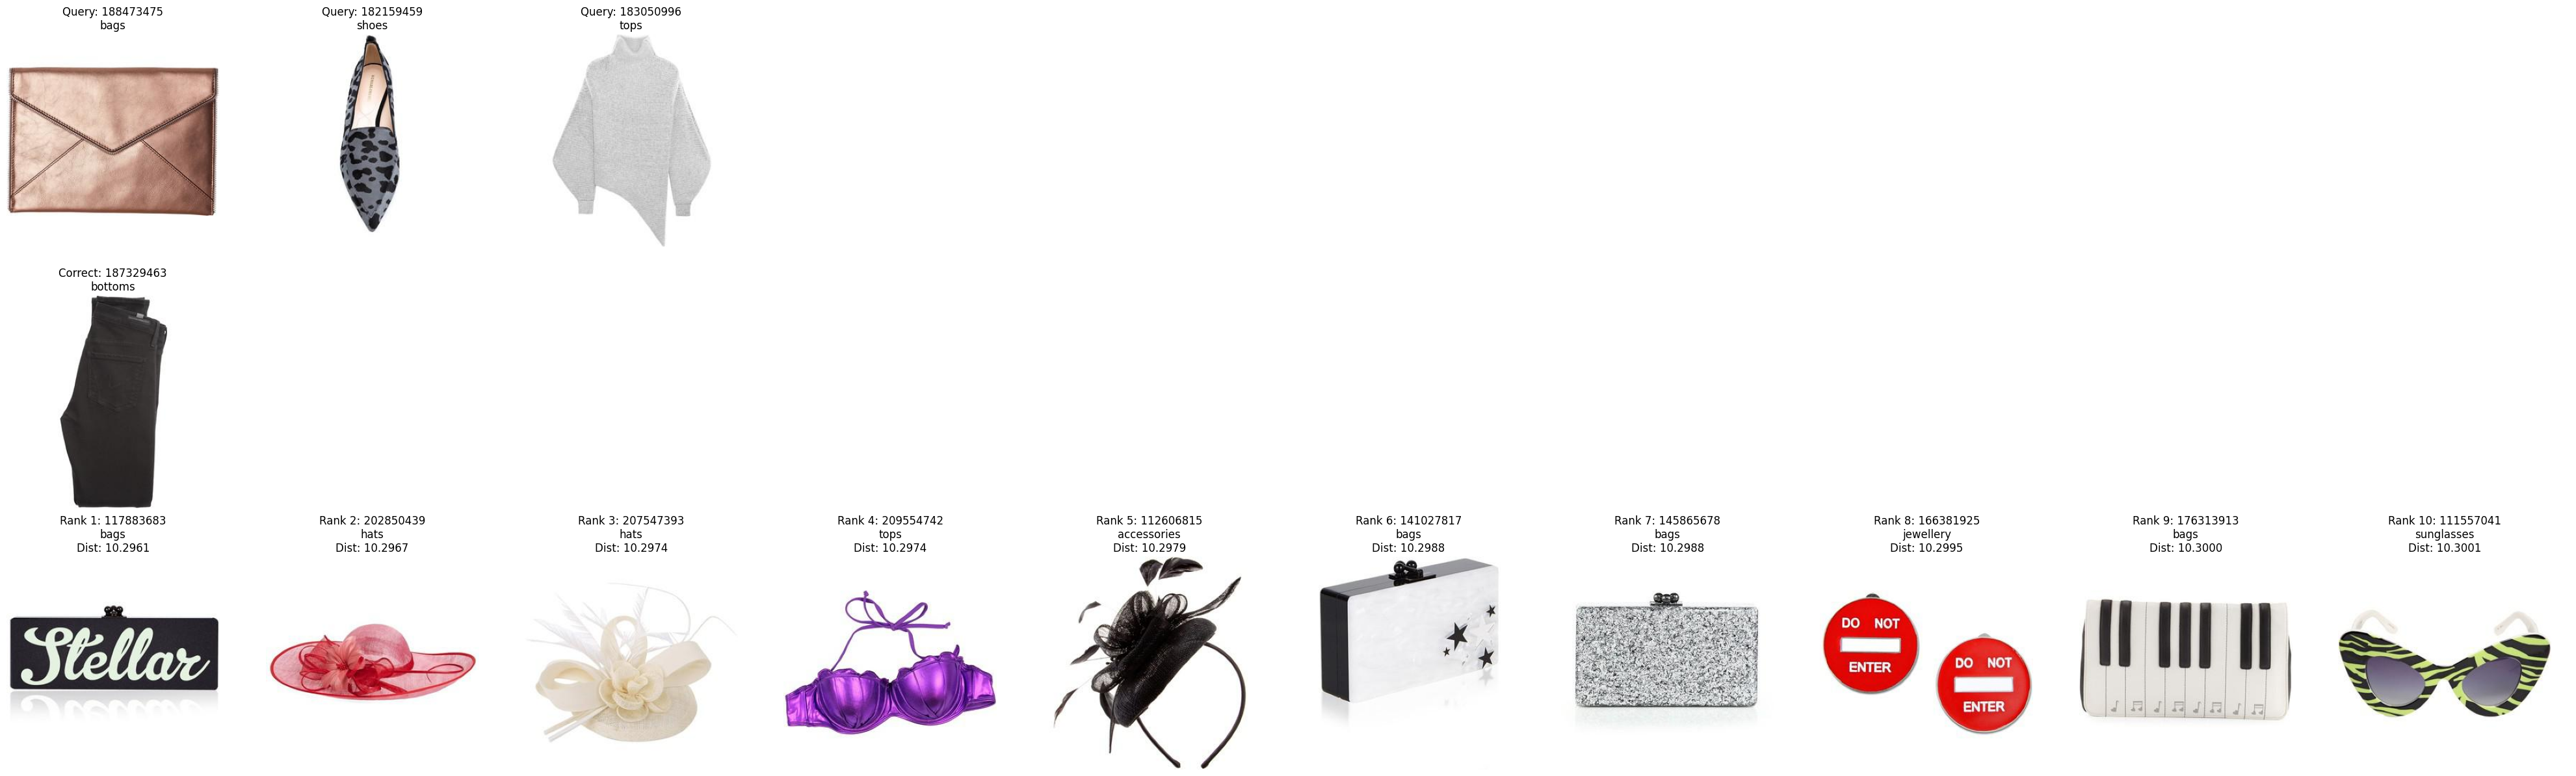

In [53]:
# Section: Visualize CIR Test Example with Top 10 Predictions
#
# This cell loads a CIR checkpoint (epoch_154.pth), selects a random example
# from the test set (valid.json using PolyvoreTripletDataset), and displays:
# - The outfit (query).
# - The correct item to predict (answer).
# - The top 10 predicted items from the entire embedding database, restricted
# to the same category as the answer. Assumes all required functions are defined.

import os
import torch
import random
import matplotlib.pyplot as plt
import numpy as np

# Define paths
CHECKPOINT_DIR = os.path.join(os.getcwd(), 'checkpoints', 'complementary_clip')
POLYVORE_IMAGE_DATA_PATH = f"{POLYVORE_DIR}/images/{{item_id}}.jpg"

# New function to find top k closest items
def find_top_k_items(query_emb, embedding_dict, metadata, target_category, category_id, device, k=10):
    """Find the top k closest items in the embedding database for a query embedding.

    Args:
        query_emb (torch.Tensor): Query embedding, shape (d_model,).
        embedding_dict (dict): Dictionary mapping item_id to embedding (1024,).
        metadata (dict): Item metadata with category information.
        target_category (str): Category to restrict the search (e.g., 'shoes').
        device (torch.device): Device for computations.
        k (int): Number of top items to return (default: 10).

    Returns:
        list: List of (item_id, distance) tuples for the top k closest items.
    """
    # Filter items by category
    item_ids = []
    embeddings = []
    for item_id, emb in embedding_dict.items():
        item_ids.append(item_id)
        embeddings.append(emb)
        """
        if metadata[item_id]['semantic_category'] == target_category:
            if metadata[item_id]['category_id'] == category_id:
                item_ids.append(item_id)
                embeddings.append(emb)
        """
    
    if not embeddings:
        print(f"No items found for category {target_category}")
        return []
    
    # Convert to tensor
    embeddings = torch.from_numpy(np.array(embeddings)).to(dtype=torch.float32, device=device)  # (n_items, 1024)
    
    # Project embeddings to model dimension
    embeddings = model.fc(embeddings)  # (n_items, d_model)
    
    # Compute distances
    query_emb = query_emb.unsqueeze(0)  # (1, d_model)
    dists = torch.norm(query_emb - embeddings, dim=-1)  # (n_items,)
    
    # Get top k indices and distances
    top_k_dists, top_k_indices = torch.topk(dists, k=k, largest=False)
    top_k_items = [(item_ids[idx], dist.item()) for idx, dist in zip(top_k_indices, top_k_dists)]
    
    return top_k_items

# Load test dataset (using valid.json as in your training)
test_cir_dataset = PolyvoreTripletDataset(
    dataset_dir=POLYVORE_DIR,
    dataset_type='nondisjoint',
    dataset_split='valid',
    metadata=metadata,
    embedding_dict=embedding_dict,
    load_image=True  # Load images for visualization
)

# Select a random test example
example_idx = random.randint(0, len(test_cir_dataset) - 1)
example = test_cir_dataset[example_idx]

# Initialize model and load checkpoint
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = OutfitCLIPTransformer(OutfitTransformerConfig(n_items=len(metadata))).to(device)

# Load checkpoint
checkpoint_path = os.path.join(CHECKPOINT_DIR, 'epoch_40.pth')
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Checkpoint {checkpoint_path} not found. Please verify the path.")
model = load_checkpoint(model, checkpoint_path)

# Get model predictions for the example
model.eval()
with torch.no_grad():
    queries = [example['query']]  # Single query
    answer = example['answer']
    answer_id = answer.item_id
    answer_category = answer.category
    answer_category_id = answer.category_id
    
    # Compute query embedding
    query_emb = get_cls_embedding(model, queries, device, 
                                use_precomputed_embedding=True)[0]  # (d_model,)
    
    # Find top 10 closest items
    top_k_items = find_top_k_items(query_emb, embedding_dict, metadata, answer_category, answer_category_id, device, k=10)

# Load images for top k items
top_k_items_with_images = []
for item_id, dist in top_k_items:
    item = load_item(POLYVORE_DIR, metadata, item_id, should_load_image=True, embedding_dict=embedding_dict)
    top_k_items_with_images.append((item, dist))

# Print example details
print(f"\nCIR Test Example (Index: {example_idx})")
print("Outfit (Query):")
for item in example['query']:
    print(f"- ID: {item.item_id}, Category: {item.category}")

print("\nCorrect Item (Answer):")
print(f"- ID: {answer_id}, Category: {answer_category}")

print("\nTop 10 Predicted Items:")
for i, (item, dist) in enumerate(top_k_items_with_images):
    is_correct = item.item_id == answer_id
    print(f"- Rank {i+1}: ID: {item.item_id}, Category: {item.category}, Distance: {dist:.4f}, Correct: {'Yes' if is_correct else 'No'}")

# Visualize images
n_query = len(example['query'])
n_top_k = len(top_k_items_with_images)
fig, axes = plt.subplots(3, max(n_query, n_top_k), figsize=(4 * max(n_query, n_top_k), 12))

# Plot query images (outfit)
for i, item in enumerate(example['query']):
    image = item.image
    if image is not None:
        axes[0, i].imshow(image)
        axes[0, i].set_title(f"Query: {item.item_id}\n{item.category}")
    else:
        axes[0, i].text(0.5, 0.5, "Image not available", ha='center', va='center')
    axes[0, i].axis('off')

# Plot correct item (answer)
image = answer.image
if image is not None:
    axes[1, 0].imshow(image)
    axes[1, 0].set_title(f"Correct: {answer_id}\n{answer_category}")
else:
    axes[1, 0].text(0.5, 0.5, "Image not available", ha='center', va='center')
axes[1, 0].axis('off')

# Disable extra axes in correct item row
for i in range(1, max(n_query, n_top_k)):
    axes[1, i].axis('off')

# Plot top k predicted items
for i, (item, dist) in enumerate(top_k_items_with_images):
    image = item.image
    is_correct = item.item_id == answer_id
    title = f"Rank {i+1}: {item.item_id}\n{item.category}\nDist: {dist:.4f}"
    if is_correct:
        title += "\n(Correct)"
    if image is not None:
        axes[2, i].imshow(image)
        axes[2, i].set_title(title)
    else:
        axes[2, i].text(0.5, 0.5, "Image not available", ha='center', va='center')
    axes[2, i].axis('off')

# Disable extra axes
for i in range(n_query, max(n_query, n_top_k)):
    axes[0, i].axis('off')
for i in range(n_top_k, max(n_query, n_top_k)):
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

### Sigue sin aprender bien la categoria que toca pongas el checkpoint que pongas (al principio de hecho solo predice bags y despues empieza a predecir cosas mas variadas pero siempre lo mismo)

### El codigo anterior se puede meter que solo prediga de la categoria que toca/de la misma subcategoria y en ese caso pasa un poco lo mismo, que siempre predice las mismas


## Evaluamos CIR (dando pista de categoria y subcategoria) y sacamos metricas top10, 30 y 50

In [54]:
# Section: Evaluate CIR on Test Set with Top-10, Top-30, Top-50 Metrics
#
# This script loads the CIR checkpoint from epoch 128, evaluates it on the test set,
# and computes top-10, top-30, and top-50 metrics, restricting predictions to the same
# semantic_category and category_id as the item to predict.

import os
import torch
import random
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from collections import defaultdict

# Define paths
CHECKPOINT_DIR = os.path.join(os.getcwd(), 'checkpoints', 'complementary_clip')
POLYVORE_DIR = './datasets/polyvore'
POLYVORE_METADATA_PATH = f"{POLYVORE_DIR}/item_metadata.json"
POLYVORE_IMAGE_DATA_PATH = f"{POLYVORE_DIR}/images/{{item_id}}.jpg"
POLYVORE_PRECOMPUTED_CLIP_EMBEDDING_DIR = f"{POLYVORE_DIR}/precomputed_clip_embeddings"
POLYVORE_TASK_DATA_PATH = f"{POLYVORE_DIR}/{{dataset_type}}/{{dataset_task}}/{{dataset_split}}.json"
POLYVORE_SET_DATA_PATH = f"{POLYVORE_DIR}/{{dataset_type}}/{{dataset_split}}.json"

# Reutilizamos funciones definidas en el código de entrenamiento

# Load metadata from item_metadata.json
def load_metadata(dataset_dir):
    metadata = {}
    with open(POLYVORE_METADATA_PATH.format(dataset_dir=dataset_dir), 'r') as f:
        metadata_ = json.load(f)
        for item in metadata_:
            metadata[item['item_id']] = item
    print(f"Loaded {len(metadata)} metadata entries")
    return metadata

# Load precomputed CLIP embeddings
def load_embedding_dict(dataset_dir):
    e_dir = POLYVORE_PRECOMPUTED_CLIP_EMBEDDING_DIR.format(polyvore_dir=dataset_dir)
    filenames = [f for f in os.listdir(e_dir) if f.endswith('.pkl') and 'official' not in f]
    filenames.sort(key=lambda x: int(x.split('.')[0].split('_')[-1]))

    all_ids, all_embeddings = [], []
    for filename in filenames:
        filepath = os.path.join(e_dir, filename)
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
            all_ids += data['ids']
            all_embeddings.append(data['embeddings'])

    all_embeddings = np.concatenate(all_embeddings, axis=0)  # (n_items, 1024)
    embedding_dict = {item_id: embedding for item_id, embedding in zip(all_ids, all_embeddings)}
    print(f"Loaded {len(all_embeddings)} embeddings into dictionary")
    return embedding_dict

# Load a FashionItem object
class FashionItem:
    def __init__(self, item_id, category, category_id, image=None, description="", metadata=None, embedding=None):
        self.item_id = item_id
        self.category = category
        self.category_id = category_id
        self.image = image
        self.description = description
        self.metadata = metadata or {}
        self.embedding = embedding

def load_item(dataset_dir, metadata, item_id, should_load_image=False, embedding_dict=None):
    metadata_ = metadata[item_id]
    return FashionItem(
        item_id=metadata_['item_id'],
        category=metadata_['semantic_category'],
        category_id=metadata_['category_id'],
        image=None,  # No necesitamos cargar imágenes para evaluación
        description=metadata_['title'] if metadata_.get('title') else metadata_['url_name'],
        metadata=metadata_,
        embedding=embedding_dict[item_id] if embedding_dict else None
    )

# Dataset for CIR test (fill in the blank)
class PolyvoreFillInTheBlankDataset(Dataset):
    def __init__(self, dataset_dir, dataset_type='nondisjoint', dataset_split='test',
                 metadata=None, embedding_dict=None, load_image=False):
        self.dataset_dir = dataset_dir
        self.metadata = metadata if metadata else load_metadata(dataset_dir)
        self.data = load_task_data(dataset_dir, dataset_type, 'fill_in_the_blank', dataset_split)
        self.load_image = load_image
        self.embedding_dict = embedding_dict
        labels = [item['label'] for item in self.data]
        label_counts = Counter(labels)
        print(f"{dataset_split} CIR FITB dataset: {len(self.data)} outfits, Label distribution: {label_counts}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = self.data[idx]['label']
        candidates = [
            load_item(self.dataset_dir, self.metadata, item_id,
                      self.load_image, self.embedding_dict)
            for item_id in self.data[idx]['answers']
        ]
        outfit = [
            load_item(self.dataset_dir, self.metadata, item_id,
                      self.load_image, self.embedding_dict)
            for item_id in self.data[idx]['question']
        ]
        return {'query': outfit, 'label': label, 'candidates': candidates}

def load_task_data(dataset_dir, dataset_type, task, dataset_split):
    with open(
        POLYVORE_TASK_DATA_PATH.format(
            dataset_dir=dataset_dir,
            dataset_type=dataset_type,
            dataset_task=task,
            dataset_split=dataset_split
        ), 'r'
    ) as f:
        data = json.load(f)
    print(f"Loaded {len(data)} {task} {dataset_split} entries")
    return data

# Collate function for CIR test
def fitb_collate_fn(batch):
    query = [item['query'] for item in batch]
    label = [item['label'] for item in batch]
    candidates = [item['candidates'] for item in batch]
    return {'query': query, 'label': label, 'candidates': candidates}

# OutfitTransformer model (copiado del código original)
class OutfitTransformer(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.fc = nn.Linear(1024, cfg.d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=cfg.d_model, nhead=cfg.n_head, dropout=cfg.dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=cfg.n_layers)
        self.cls_token = nn.Parameter(torch.randn(1, 1, cfg.d_model))
        self.classification_head = nn.Linear(cfg.d_model, 1)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def forward(self, queries, use_precomputed_embedding=True):
        batch_size = len(queries)
        max_len = max(len(query) for query in queries)

        embeddings = []
        mask = []
        for query in queries:
            outfit_embeds = torch.from_numpy(np.array([item.embedding for item in query])).to(
                dtype=torch.float32, device=self.device
            )
            padded_embeds = torch.zeros(max_len, 1024, device=self.device)
            padded_embeds[:len(query)] = outfit_embeds
            embeddings.append(padded_embeds)
            outfit_mask = torch.zeros(max_len, device=self.device)
            outfit_mask[len(query):] = 1
            mask.append(outfit_mask)

        embeddings = torch.stack(embeddings, dim=0)
        mask = torch.stack(mask, dim=0)

        embeddings = self.fc(embeddings)
        cls_token = self.cls_token.expand(batch_size, -1, -1)
        features = torch.cat([cls_token, embeddings], dim=1)
        cls_mask = torch.zeros(batch_size, 1, device=self.device)
        mask = torch.cat([cls_mask, mask], dim=1)

        transformed_features = self.transformer_encoder(features, src_key_padding_mask=mask.bool())
        outfit_embedding = transformed_features[:, 0, :]
        logits = self.classification_head(outfit_embedding)
        return logits.squeeze(-1)

class OutfitCLIPTransformer(OutfitTransformer):
    def __init__(self, cfg):
        super().__init__(cfg)

# Configuration for OutfitTransformer (copiado del código original)
@dataclass
class OutfitTransformerConfig:
    n_items: int = 251008
    d_model: int = 128
    n_layers: int = 4
    n_head: int = 4
    dropout: float = 0.1
    item_enc_norm_out: bool = True
    aggregation_method: str = 'concat'

@dataclass
class OutfitCLIPTransformerConfig(OutfitTransformerConfig):
    item_enc_clip_model_name: str = "patrickjohncyh/fashion-clip"

# Function to get CLS embedding for CIR (copiado del código original)
def get_cls_embedding(model, queries, device, use_precomputed_embedding=True):
    batch_size = len(queries)
    max_len = max(len(query) for query in queries)
    embeddings = []
    mask = []
    for query in queries:
        outfit_embeds = torch.from_numpy(np.array([item.embedding for item in query])).to(
            dtype=torch.float32, device=device
        )
        padded_embeds = torch.zeros(max_len, 1024, device=device)
        padded_embeds[:len(query)] = outfit_embeds
        embeddings.append(padded_embeds)
        outfit_mask = torch.zeros(max_len, device=device)
        outfit_mask[len(query):] = 1
        mask.append(outfit_mask)

    embeddings = torch.stack(embeddings, dim=0)
    mask = torch.stack(mask, dim=0)

    embeddings = model.fc(embeddings)
    cls_token = model.cls_token.expand(batch_size, -1, -1)
    features = torch.cat([cls_token, embeddings], dim=1)
    cls_mask = torch.zeros(batch_size, 1, device=device)
    mask = torch.cat([cls_mask, mask], dim=1)

    transformed_features = model.transformer_encoder(features, src_key_padding_mask=mask.bool())
    outfit_embedding = transformed_features[:, 0, :]
    return outfit_embedding

# Load checkpoint (copiado del código original)
def load_checkpoint(model, checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    model.load_state_dict(checkpoint['model'])
    model.eval()
    print(f"Loaded checkpoint from {checkpoint_path}")
    return model

# Modified function to find top k closest items
def find_top_k_items(query_emb, embedding_dict, metadata, target_category, target_category_id, device, k=50):
    """
    Find the top k closest items in the embedding database for a query embedding.

    Args:
        query_emb (torch.Tensor): Query embedding, shape (d_model,).
        embedding_dict (dict): Dictionary mapping item_id to embedding (1024,).
        metadata (dict): Item metadata with category information.
        target_category (str): Semantic category to restrict the search (e.g., 'shoes').
        target_category_id (int): Subcategory ID to restrict the search.
        device (torch.device): Device for computations.
        k (int): Number of top items to return (default: 50).

    Returns:
        list: List of (item_id, distance) tuples for the top k closest items.
    """
    # Filter items by semantic_category and category_id
    item_ids = []
    embeddings = []
    for item_id, emb in embedding_dict.items():
        item_meta = metadata[item_id]
        if item_meta['semantic_category'] == target_category and item_meta['category_id'] == target_category_id:
            item_ids.append(item_id)
            embeddings.append(emb)
    
    if not embeddings:
        print(f"No items found for category {target_category}/{target_category_id}")
        return []
    
    # Convert to tensor
    embeddings = torch.from_numpy(np.array(embeddings)).to(dtype=torch.float32, device=device)  # (n_items, 1024)
    
    # Project embeddings to model dimension
    embeddings = model.fc(embeddings)  # (n_items, d_model)
    
    # Compute distances
    query_emb = query_emb.unsqueeze(0)  # (1, d_model)
    dists = torch.norm(query_emb - embeddings, dim=-1)  # (n_items,)
    
    # Get top k indices and distances
    top_k_dists, top_k_indices = torch.topk(dists, k=min(k, len(dists)), largest=False)
    top_k_items = [(item_ids[idx], dist.item()) for idx, dist in zip(top_k_indices, top_k_dists)]
    
    return top_k_items

# Function to compute top-k metrics
def compute_top_k_metrics(top_k_items, correct_item_id, k_values=[10, 30, 50]):
    """
    Compute top-k metrics (recall@k) for a single example.

    Args:
        top_k_items (list): List of (item_id, distance) tuples for the top k predicted items.
        correct_item_id (str): ID of the correct item.
        k_values (list): List of k values to compute metrics for (default: [10, 30, 50]).

    Returns:
        dict: Dictionary mapping k to a boolean indicating if the correct item is in the top k.
    """
    predicted_ids = [item_id for item_id, _ in top_k_items]
    metrics = {}
    for k in k_values:
        top_k_pred = predicted_ids[:min(k, len(predicted_ids))]
        metrics[k] = correct_item_id in top_k_pred
    return metrics

# Load metadata and embeddings
metadata = load_metadata(POLYVORE_DIR)
embedding_dict = load_embedding_dict(POLYVORE_DIR)

# Load test dataset
test_cir_dataset = PolyvoreFillInTheBlankDataset(
    dataset_dir=POLYVORE_DIR,
    dataset_type='nondisjoint',
    dataset_split='test',
    metadata=metadata,
    embedding_dict=embedding_dict,
    load_image=False
)

# Create DataLoader for test set
test_cir_dataloader = DataLoader(
    dataset=test_cir_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    collate_fn=fitb_collate_fn
)

# Initialize model and load checkpoint for epoch 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = OutfitCLIPTransformer(OutfitCLIPTransformerConfig(n_items=len(metadata))).to(device)

# Load checkpoint
checkpoint_path = os.path.join(CHECKPOINT_DIR, 'epoch_128.pth')
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Checkpoint {checkpoint_path} not found. Please verify the path.")
model = load_checkpoint(model, checkpoint_path)

# Evaluate on test set
model.eval()
top_k_hits = defaultdict(list)  # To store hits for each k value
pbar = tqdm(test_cir_dataloader, desc='Evaluating CIR on Test Set')

with torch.no_grad():
    for data in pbar:
        queries = data['query']
        candidates = data['candidates']
        labels = data['label']  # Correct candidate index for each query

        # Compute query embeddings
        batched_q_emb = get_cls_embedding(model, queries, device, use_precomputed_embedding=True)  # (batch_size, d_model)

        # Process each query in the batch
        for i in range(len(queries)):
            query_emb = batched_q_emb[i]
            correct_candidate_idx = labels[i]
            correct_item = candidates[i][correct_candidate_idx]
            correct_item_id = correct_item.item_id
            target_category = correct_item.category
            target_category_id = correct_item.category_id

            # Find top k items
            top_k_items = find_top_k_items(
                query_emb=query_emb,
                embedding_dict=embedding_dict,
                metadata=metadata,
                target_category=target_category,
                target_category_id=target_category_id,
                device=device,
                k=50
            )

            # Compute top-k metrics for this example
            metrics = compute_top_k_metrics(top_k_items, correct_item_id, k_values=[10, 30, 50])
            for k, hit in metrics.items():
                top_k_hits[k].append(hit)

        # Update progress bar with current metrics
        current_metrics = {f"Top-{k}": np.mean(hits) for k, hits in top_k_hits.items()}
        pbar.set_postfix(current_metrics)

# Compute final metrics
final_metrics = {k: np.mean(hits) for k, hits in top_k_hits.items()}
print("\nFinal CIR Test Metrics:")
for k, recall in final_metrics.items():
    print(f"Recall@Top-{k}: {recall:.4f}")


Loaded 251008 metadata entries


/tmp/ipykernel_3695595/3284088796.py:224: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cuda' if torch.cuda.is_availab

Loaded 251008 embeddings into dictionary
Loaded 10000 fill_in_the_blank test entries
test CIR FITB dataset: 10000 outfits, Label distribution: Counter({0: 10000})
Loaded checkpoint from /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_128.pth


Evaluating CIR on Test Set: 100%|██████████| 313/313 [06:41<00:00,  1.28s/it, Top-10=0.0092, Top-30=0.0209, Top-50=0.034]  


Final CIR Test Metrics:
Recall@Top-10: 0.0092
Recall@Top-30: 0.0209
Recall@Top-50: 0.0340


## Este retoma el entrenamiento desde el checkpoint 50

In [3]:
# OutfitTransformer CIR with Curriculum Learning (Optimizado y con Reanudación de Checkpoint Corregida)

# ------------------------------
# Section 1: Setup and Imports
# ------------------------------

# Import standard libraries for data handling, logging, and visualization
import json
import logging
import os
import pathlib
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter, defaultdict
from tqdm import tqdm
from typing import Any, Dict, List, Literal, Optional
from dataclasses import dataclass

# Import PyTorch and related modules for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn.functional as F

# Import torchvision for image preprocessing
import torchvision.transforms as transforms

# Import transformers for CLIP model
from transformers import CLIPProcessor, CLIPModel

# Import sklearn for metrics
from sklearn.metrics import roc_auc_score

# Disable tokenizer parallelism to avoid warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Define project-wide paths
SRC_DIR = pathlib.Path(os.getcwd()).absolute()
LOGS_DIR = SRC_DIR / 'logs'
CHECKPOINT_DIR = SRC_DIR / 'checkpoints'
POLYVORE_DIR = './datasets/polyvore'
POLYVORE_METADATA_PATH = f"{POLYVORE_DIR}/item_metadata.json"
POLYVORE_IMAGE_DATA_PATH = f"{POLYVORE_DIR}/images/{{item_id}}.jpg"
POLYVORE_PRECOMPUTED_CLIP_EMBEDDING_DIR = f"{POLYVORE_DIR}/precomputed_clip_embeddings"
POLYVORE_TASK_DATA_PATH = f"{POLYVORE_DIR}/{{dataset_type}}/{{dataset_task}}/{{dataset_split}}.json"
POLYVORE_SET_DATA_PATH = f"{POLYVORE_DIR}/{{dataset_type}}/{{dataset_split}}.json"

# Create directories if they don't exist
os.makedirs(LOGS_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR / 'compatibility_clip', exist_ok=True)
os.makedirs(CHECKPOINT_DIR / 'complementary_clip', exist_ok=True)
os.makedirs(POLYVORE_PRECOMPUTED_CLIP_EMBEDDING_DIR, exist_ok=True)

# Configure logging for the entire notebook
logging.basicConfig(
    filename=LOGS_DIR / 'outfit_transformer.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger('outfit_transformer')

# Log notebook start
logger.info("Starting OutfitTransformer notebook")
print("Starting OutfitTransformer notebook")

# ------------------------------
# Section 2: Utility Functions and Classes
# ------------------------------

# Utility function to set random seeds for reproducibility
def seed_everything(seed=42):
    """Set random seeds for reproducibility across random, numpy, and PyTorch.

    Args:
        seed (int): Random seed value (default: 42).
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    logger.info(f"Set random seed to {seed}")

# Set seed for reproducibility
seed_everything(42)

# FashionItem class to represent items in the Polyvore dataset (modificado para incluir category_id)
class FashionItem:
    """Represents a fashion item with metadata, image, and embedding.

    Attributes:
        item_id (str): Unique identifier for the item.
        category (str): Semantic category (e.g., top, bottom, shoes).
        category_id (int): Subcategory ID of the item.
        image (PIL.Image or None): Loaded image of the item.
        description (str): Text description or title of the item.
        metadata (dict): Additional metadata from item_metadata.json.
        embedding (np.ndarray or None): Precomputed CLIP embedding (1024,).
    """
    def __init__(self, item_id, category, category_id, image=None, description="", metadata=None, embedding=None):
        self.item_id = item_id
        self.category = category
        self.category_id = category_id
        self.image = image
        self.description = description
        self.metadata = metadata or {}
        self.embedding = embedding

# Load metadata from item_metadata.json
def load_metadata(dataset_dir):
    """Load item metadata from item_metadata.json.

    Args:
        dataset_dir (str): Path to the Polyvore dataset directory.

    Returns:
        dict: Dictionary mapping item_id to metadata.
    """
    metadata = {}
    with open(POLYVORE_METADATA_PATH.format(dataset_dir=dataset_dir), 'r') as f:
        metadata_ = json.load(f)
        for item in metadata_:
            metadata[item['item_id']] = item
    logger.info(f"Loaded {len(metadata)} metadata entries")
    print(f"Loaded {len(metadata)} metadata entries")
    return metadata

# Load image for an item
def load_image(dataset_dir, item_id, size=(224, 224)):
    """Load an image for a given item_id.

    Args:
        dataset_dir (str): Path to the Polyvore dataset directory.
        item_id (str): Unique identifier for the item.
        size (tuple): Target image size (height, width) (default: (224, 224)).

    Returns:
        PIL.Image or None: Loaded image or None if loading fails.
    """
    image_path = POLYVORE_IMAGE_DATA_PATH.format(dataset_dir=dataset_dir, item_id=item_id)
    try:
        image = Image.open(image_path).convert('RGB')
        return image
    except Exception as e:
        logger.error(f"Error loading image {image_path}: {e}")
        print(f"Error loading image {image_path}: {e}")
        return None

# Load a FashionItem object (modificado para incluir category_id)
def load_item(dataset_dir, metadata, item_id, should_load_image=False, embedding_dict=None):
    """Load a FashionItem object with metadata, image, and embedding.

    Args:
        dataset_dir (str): Path to the Polyvore dataset directory.
        metadata (dict): Dictionary of item metadata.
        item_id (str): Unique identifier for the item.
        should_load_image (bool): Whether to load the item image.
        embedding_dict (dict or None): Dictionary mapping item_id to CLIP embedding.

    Returns:
        FashionItem: Object containing item data.
    """
    metadata_ = metadata[item_id]
    return FashionItem(
        item_id=metadata_['item_id'],
        category=metadata_['semantic_category'],
        category_id=metadata_['category_id'],
        image=load_image(dataset_dir, metadata_['item_id']) if should_load_image else None,
        description=metadata_['title'] if metadata_.get('title') else metadata_['url_name'],
        metadata=metadata_,
        embedding=embedding_dict[item_id] if embedding_dict else None
    )

# Load precomputed CLIP embeddings
def load_embedding_dict(dataset_dir):
    """Load precomputed CLIP embeddings from .pkl files.

    Args:
        dataset_dir (str): Path to the Polyvore dataset directory.

    Returns:
        dict: Dictionary mapping item_id to embedding (1024,).
    """
    e_dir = POLYVORE_PRECOMPUTED_CLIP_EMBEDDING_DIR.format(polyvore_dir=dataset_dir)
    filenames = [f for f in os.listdir(e_dir) if f.endswith('.pkl') and 'official' not in f]
    filenames.sort(key=lambda x: int(x.split('.')[0].split('_')[-1]))

    all_ids, all_embeddings = [], []
    for filename in filenames:
        filepath = os.path.join(e_dir, filename)
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
            all_ids += data['ids']
            all_embeddings.append(data['embeddings'])

    all_embeddings = np.concatenate(all_embeddings, axis=0)  # (n_items, 1024)
    embedding_dict = {item_id: embedding for item_id, embedding in zip(all_ids, all_embeddings)}
    logger.info(f"Loaded {len(all_embeddings)} embeddings into dictionary")
    print(f"Loaded {len(all_embeddings)} embeddings into dictionary")
    return embedding_dict

# Load task data from JSON files
def load_task_data(dataset_dir, dataset_type, task, dataset_split):
    """Load task-specific data from JSON files.

    Args:
        dataset_dir (str): Path to the Polyvore dataset directory.
        dataset_type (str): Dataset type (e.g., 'nondisjoint').
        task (str): Task name (e.g., 'compatibility', 'fill_in_the_blank').
        dataset_split (str): Dataset split (e.g., 'train', 'valid', 'test').

    Returns:
        list: List of task data entries.
    """
    with open(
        POLYVORE_TASK_DATA_PATH.format(
            dataset_dir=dataset_dir,
            dataset_type=dataset_type,
            dataset_task=task,
            dataset_split=dataset_split
        ), 'r'
    ) as f:
        data = json.load(f)
    logger.info(f"Loaded {len(data)} {task} {dataset_split} entries")
    return data

# Load set data for CIR training
def load_set_data(dataset_dir, dataset_type, dataset_split):
    """Load set data for CIR training from JSON files.

    Args:
        dataset_dir (str): Path to the Polyvore dataset directory.
        dataset_type (str): Dataset type (e.g., 'nondisjoint').
        dataset_split (str): Dataset split (e.g., 'train', 'valid', 'test').

    Returns:
        list: List of set data entries.
    """
    with open(
        POLYVORE_SET_DATA_PATH.format(
            dataset_dir=dataset_dir,
            dataset_type=dataset_type,
            dataset_split=dataset_split
        ), 'r'
    ) as f:
        data = json.load(f)
    logger.info(f"Loaded {len(data)} {dataset_split} set entries")
    return data

# Load checkpoint
def load_checkpoint(model, checkpoint_path):
    """Load a model's state dictionary from a checkpoint file.

    Args:
        model (nn.Module): The model to load the state dictionary into.
        checkpoint_path (str): Path to the checkpoint file (.pth).

    Returns:
        nn.Module: The model with the loaded state dictionary, set to evaluation mode.
    """
    checkpoint = torch.load(checkpoint_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    model.load_state_dict(checkpoint['model'])
    model.eval()
    logger.info(f"Loaded checkpoint from {checkpoint_path}")
    return model

# ------------------------------
# Section 3: Load Precomputed CLIP Embeddings and CP Model
# ------------------------------

# Load metadata and embeddings
metadata = load_metadata(POLYVORE_DIR)
embedding_dict = load_embedding_dict(POLYVORE_DIR)

# Precompute FashionItem objects and item lists for faster sampling
fashion_items = {}
items_by_semantic_category = defaultdict(list)
items_by_category_id = defaultdict(list)

# Also precompute fallback candidates for each category_id
category_id_to_fallback = defaultdict(list)

for item_id in tqdm(metadata.keys(), desc="Precomputing FashionItem objects and lists"):
    item = load_item(POLYVORE_DIR, metadata, item_id, should_load_image=False, embedding_dict=embedding_dict)
    fashion_items[item_id] = item
    items_by_semantic_category[item.category].append(item_id)
    items_by_category_id[item.category_id].append(item_id)
    # Map each category_id to the list of item_ids in its semantic_category
    category_id_to_fallback[item.category_id] = items_by_semantic_category[item.category]

logger.info(f"Precomputed {len(fashion_items)} FashionItem objects")
logger.info(f"Precomputed item lists: {len(items_by_semantic_category)} semantic categories, {len(items_by_category_id)} category IDs")
print(f"Precomputed {len(fashion_items)} FashionItem objects")
print(f"Precomputed item lists: {len(items_by_semantic_category)} semantic categories, {len(items_by_category_id)} category IDs")

# Configuration for OutfitTransformer
@dataclass
class OutfitTransformerConfig:
    """Configuration for OutfitTransformer model."""
    n_items: int = 251008  # Number of unique items in Polyvore
    d_model: int = 128     # Embedding dimension
    n_layers: int = 4      # Number of transformer layers
    n_head: int = 4        # Number of attention heads
    dropout: float = 0.1   # Dropout rate
    item_enc_norm_out: bool = True
    aggregation_method: str = 'concat'

@dataclass
class OutfitCLIPTransformerConfig(OutfitTransformerConfig):
    """Configuration for OutfitCLIPTransformer, extending OutfitTransformerConfig."""
    item_enc_clip_model_name: str = "patrickjohncyh/fashion-clip"

# OutfitTransformer model
class OutfitTransformer(nn.Module):
    """Transformer model for outfit compatibility prediction.

    Architecture:
        - Input: List of outfits, each a list of FashionItem objects with CLIP embeddings (1024,).
        - Linear layer: Projects CLIP embeddings to d_model (1024 -> 128).
        - CLS token: Learnable token prepended to each outfit sequence.
        - Transformer Encoder: Processes outfit embeddings with attention.
        - Classification Head: Maps CLS token embedding to a logit.
    """
    def __init__(self, cfg=OutfitTransformerConfig()):
        super().__init__()
        self.cfg = cfg
        self.fc = nn.Linear(1024, cfg.d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=cfg.d_model, nhead=cfg.n_head, dropout=cfg.dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=cfg.n_layers)
        self.cls_token = nn.Parameter(torch.randn(1, 1, cfg.d_model))
        self.classification_head = nn.Linear(cfg.d_model, 1)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def forward(self, queries, use_precomputed_embedding=True):
        batch_size = len(queries)
        max_len = max(len(query) for query in queries)

        embeddings = []
        mask = []
        for query in queries:
            outfit_embeds = torch.from_numpy(np.array([item.embedding for item in query])).to(
                dtype=torch.float32, device=self.device
            )
            padded_embeds = torch.zeros(max_len, 1024, device=self.device)
            padded_embeds[:len(query)] = outfit_embeds
            embeddings.append(padded_embeds)
            outfit_mask = torch.zeros(max_len, device=self.device)
            outfit_mask[len(query):] = 1
            mask.append(outfit_mask)

        embeddings = torch.stack(embeddings, dim=0)
        mask = torch.stack(mask, dim=0)

        embeddings = self.fc(embeddings)
        cls_token = self.cls_token.expand(batch_size, -1, -1)
        features = torch.cat([cls_token, embeddings], dim=1)
        cls_mask = torch.zeros(batch_size, 1, device=self.device)
        mask = torch.cat([cls_mask, mask], dim=1)

        transformed_features = self.transformer_encoder(features, src_key_padding_mask=mask.bool())
        outfit_embedding = transformed_features[:, 0, :]
        logits = self.classification_head(outfit_embedding)
        return logits.squeeze(-1)

# OutfitCLIPTransformer model
class OutfitCLIPTransformer(OutfitTransformer):
    """OutfitTransformer specialized for CLIP embeddings."""
    def __init__(self, cfg=OutfitCLIPTransformerConfig()):
        super().__init__(cfg)
        logger.info("Initialized OutfitCLIPTransformer")

# Load CP model from checkpoint
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cp_model = OutfitCLIPTransformer(OutfitCLIPTransformerConfig(n_items=len(metadata))).to(device)
checkpoint_path = os.path.join(CHECKPOINT_DIR, 'compatibility_clip', 'epoch_50.pth')
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Checkpoint {checkpoint_path} not found.")
cp_model = load_checkpoint(cp_model, checkpoint_path)
logger.info(f"Loaded CP checkpoint from {checkpoint_path}")

# ------------------------------
# Section 4: Train CIR with Curriculum Learning
# ------------------------------

# Dataset for CIR training
class PolyvoreTripletDataset(Dataset):
    """Dataset for CIR training, generating query-answer pairs."""
    def __init__(self, dataset_dir, dataset_type='nondisjoint', dataset_split='train',
                 metadata=None, embedding_dict=None, load_image=False):
        self.dataset_dir = dataset_dir
        self.metadata = metadata if metadata else load_metadata(dataset_dir)
        self.data = load_set_data(dataset_dir, dataset_type, dataset_split)
        self.load_image = load_image
        self.embedding_dict = embedding_dict
        logger.info(f"{dataset_split} CIR triplet dataset: {len(self.data)} sets")
        print(f"{dataset_split} CIR triplet dataset: {len(self.data)} sets")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        items = [
            load_item(self.dataset_dir, self.metadata, item_id,
                      self.load_image, self.embedding_dict)
            for item_id in self.data[idx]['item_ids']
        ]
        answer = items[random.randint(0, len(items) - 1)]
        outfit = [item for item in items if item != answer]
        return {'query': outfit, 'answer': answer}

# Dataset for CIR validation
class PolyvoreFillInTheBlankDataset(Dataset):
    """Dataset for CIR validation, providing queries and candidate items."""
    def __init__(self, dataset_dir, dataset_type='nondisjoint', dataset_split='valid',
                 metadata=None, embedding_dict=None, load_image=False):
        self.dataset_dir = dataset_dir
        self.metadata = metadata if metadata else load_metadata(dataset_dir)
        self.data = load_task_data(dataset_dir, dataset_type, 'fill_in_the_blank', dataset_split)
        self.load_image = load_image
        self.embedding_dict = embedding_dict
        labels = [item['label'] for item in self.data]
        label_counts = Counter(labels)
        logger.info(f"{dataset_split} CIR FITB dataset: {len(self.data)} outfits, Label distribution: {label_counts}")
        print(f"{dataset_split} CIR FITB dataset: {len(self.data)} outfits, Label distribution: {label_counts}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = self.data[idx]['label']
        candidates = [
            load_item(self.dataset_dir, self.metadata, item_id,
                      self.load_image, self.embedding_dict)
            for item_id in self.data[idx]['answers']
        ]
        outfit = [
            load_item(self.dataset_dir, self.metadata, item_id,
                      self.load_image, self.embedding_dict)
            for item_id in self.data[idx]['question']
        ]
        return {'query': outfit, 'label': label, 'candidates': candidates}

# Collate functions for CIR
def triplet_collate_fn(batch):
    """Collate function for PolyvoreTripletDataset."""
    query = [item['query'] for item in batch]
    answer = [item['answer'] for item in batch]
    return {'query': query, 'answer': answer}

def fitb_collate_fn(batch):
    """Collate function for PolyvoreFillInTheBlankDataset."""
    query = [item['query'] for item in batch]
    label = [item['label'] for item in batch]
    candidates = [item['candidates'] for item in batch]
    return {'query': query, 'label': label, 'candidates': candidates}

# InBatchTripletMarginLoss for CIR
class InBatchTripletMarginLoss(nn.Module):
    """In-batch triplet margin loss for CIR."""
    def __init__(self, margin: float = 2.0, reduction: str = "mean"):
        super().__init__()
        self.margin = margin
        self.reduction = reduction

    def forward(self, batched_q_emb: torch.Tensor, batched_a_emb: torch.Tensor):
        batch_size = batched_q_emb.shape[0]
        dists = torch.cdist(batched_q_emb, batched_a_emb, p=2)
        pos_dists = torch.diag(dists)
        neg_dists = dists.clone()
        neg_dists.fill_diagonal_(float('inf'))
        hardest_neg_dists, _ = neg_dists.min(dim=1)
        loss = torch.relu(pos_dists - hardest_neg_dists + self.margin)

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss

# Metrics for CIR
def compute_cir_scores(predictions: torch.Tensor, labels: torch.Tensor):
    """Compute accuracy for CIR."""
    accuracy = torch.mean((predictions == labels).float()).item()
    return {'acc': accuracy}

# Function to get CLS embedding for CIR
def get_cls_embedding(model, queries, device, use_precomputed_embedding=True):
    """Extract CLS token embedding for CIR."""
    batch_size = len(queries)
    max_len = max(len(query) for query in queries)
    embeddings = []
    mask = []
    for query in queries:
        outfit_embeds = torch.from_numpy(np.array([item.embedding for item in query])).to(
            dtype=torch.float32, device=device
        )
        padded_embeds = torch.zeros(max_len, 1024, device=device)
        padded_embeds[:len(query)] = outfit_embeds
        embeddings.append(padded_embeds)
        outfit_mask = torch.zeros(max_len, device=device)
        outfit_mask[len(query):] = 1
        mask.append(outfit_mask)

    embeddings = torch.stack(embeddings, dim=0)
    mask = torch.stack(mask, dim=0)

    embeddings = model.fc(embeddings)
    cls_token = model.cls_token.expand(batch_size, -1, -1)
    features = torch.cat([cls_token, embeddings], dim=1)
    cls_mask = torch.zeros(batch_size, 1, device=device)
    mask = torch.cat([cls_mask, mask], dim=1)

    transformed_features = model.transformer_encoder(features, src_key_padding_mask=mask.bool())
    outfit_embedding = transformed_features[:, 0, :]
    return outfit_embedding

# Optimized function to sample negatives dynamically
def sample_negatives(answer, items_by_semantic_category, items_by_category_id, category_id_to_fallback, fashion_items, n_negatives=10, use_category_id=False):
    """Sample negative items dynamically for a given answer using precomputed lists.

    Args:
        answer (FashionItem): The correct item (positive).
        items_by_semantic_category (dict): Dict mapping semantic_category to list of item_ids.
        items_by_category_id (dict): Dict mapping category_id to list of item_ids.
        category_id_to_fallback (dict): Dict mapping category_id to its semantic_category item_ids.
        fashion_items (dict): Dict mapping item_id to precomputed FashionItem objects.
        n_negatives (int): Number of negatives to sample.
        use_category_id (bool): If True, sample from the same category_id; otherwise, from semantic_category.

    Returns:
        List[FashionItem]: List of sampled negative items.
    """
    if use_category_id:
        # Sample from the same category_id
        candidate_ids = items_by_category_id.get(answer.category_id, [])
        # Get precomputed fallback candidates (semantic_category items)
        fallback_candidates = category_id_to_fallback.get(answer.category_id, [])
    else:
        # Sample from the same semantic_category
        candidate_ids = items_by_semantic_category.get(answer.category, [])
        fallback_candidates = []

    # Exclude the positive item (answer.item_id) from candidates
    # Use sets for faster membership testing
    answer_id = answer.item_id
    candidate_ids_set = set(candidate_ids) - {answer_id}
    candidate_ids = list(candidate_ids_set)

    # Sample the required number of negatives
    if use_category_id and len(candidate_ids) < n_negatives and fallback_candidates:
        # Need to fill with items from semantic_category
        # Exclude answer.item_id and items already in candidate_ids from fallback
        fallback_candidates_set = set(fallback_candidates) - {answer_id} - candidate_ids_set
        fallback_candidates = list(fallback_candidates_set)
        remaining = n_negatives - len(candidate_ids)
        if len(fallback_candidates) > 0:
            sampled_fallback = random.sample(fallback_candidates, min(remaining, len(fallback_candidates)))
            sampled_ids = candidate_ids + sampled_fallback
        else:
            sampled_ids = candidate_ids
    else:
        # Use all available candidates if fewer than required
        if len(candidate_ids) < n_negatives:
            sampled_ids = candidate_ids
        else:
            sampled_ids = random.sample(candidate_ids, n_negatives)

    # Retrieve precomputed FashionItem objects
    negatives = [fashion_items[item_id] for item_id in sampled_ids]

    # Pad with dummy items if we don't have enough negatives (rare case)
    while len(negatives) < n_negatives:
        # Create a dummy FashionItem with a zero embedding
        dummy_item = FashionItem(
            item_id="dummy",
            category=answer.category,
            category_id=answer.category_id if use_category_id else -1,
            embedding=np.zeros(1024)
        )
        negatives.append(dummy_item)

    return negatives

# Training function for CIR with Curriculum Learning
def train_cir(args, model, train_dataloader, valid_dataloader, optimizer, scheduler, loss_fn, device, metadata, embedding_dict, items_by_semantic_category, items_by_category_id, category_id_to_fallback, fashion_items):
    """Train the Category-aware Image Retrieval model with curriculum learning.

    Args:
        args (Args): Training arguments.
        model (OutfitCLIPTransformer): Model to train.
        train_dataloader (DataLoader): Training DataLoader.
        valid_dataloader (DataLoader): Validation DataLoader.
        optimizer (optim.Optimizer): Optimizer.
        scheduler (optim.lr_scheduler): Learning rate scheduler.
        loss_fn (nn.Module): Loss function (InBatchTripletMarginLoss).
        device (torch.device): Device (CPU/GPU).
        metadata (dict): Item metadata.
        embedding_dict (dict): Dictionary mapping item_id to embedding.
        items_by_semantic_category (dict): Dict mapping semantic_category to list of item_ids.
        items_by_category_id (dict): Dict mapping category_id to list of item_ids.
        category_id_to_fallback (dict): Dict mapping category_id to its semantic_category item_ids.
        fashion_items (dict): Dict mapping item_id to precomputed FashionItem objects.

    Returns:
        tuple: Lists of train_losses, train_accs, valid_accs.
    """
    train_losses, train_accs, valid_accs = getattr(args, 'train_losses', []), getattr(args, 'train_accs', []), getattr(args, 'valid_accs', [])

    for epoch in range(args.start_epoch, args.n_epochs):
        # Determine negative sampling strategy based on epoch
        if epoch < 40:
            negative_strategy = "batch"  # Use positives from other examples in the batch
            n_negatives = 0  # Not used in batch mode
            use_category_id = False
        elif 40 <= epoch < 50:
            negative_strategy = "semantic_category"  # Sample 10 negatives from semantic_category
            n_negatives = 10
            use_category_id = False
        else:  # epoch >= 50
            negative_strategy = "category_id"  # Sample 10 negatives from category_id, fallback to semantic_category
            n_negatives = 10
            use_category_id = True

        # Training
        model.train()
        train_loss, all_preds, all_labels = 0.0, [], []
        pbar = tqdm(train_dataloader, desc=f'Train CIR Epoch {epoch+1}/{args.n_epochs} (Neg: {negative_strategy})')
        for i, data in enumerate(pbar):
            queries = data['query']
            answers = data['answer']  # List of FashionItem objects (positives)

            # Compute query embeddings
            batched_q_emb = get_cls_embedding(model, queries, device, use_precomputed_embedding=True)

            if negative_strategy == "batch":
                # Original strategy: negatives are the positives of other examples in the batch
                batched_a_emb = get_cls_embedding(model, [[answer] for answer in answers], device, use_precomputed_embedding=True)
            else:
                # New strategy: sample negatives dynamically for each query
                batched_a_emb_list = []
                for answer in answers:
                    # Positive embedding
                    pos_emb = get_cls_embedding(model, [[answer]], device, use_precomputed_embedding=True)
                    # Sample negatives
                    negatives = sample_negatives(answer, items_by_semantic_category, items_by_category_id, category_id_to_fallback, fashion_items, n_negatives, use_category_id)
                    neg_embs = get_cls_embedding(model, [[neg] for neg in negatives], device, use_precomputed_embedding=True)
                    # Combine positive and negatives
                    combined_emb = torch.cat([pos_emb, neg_embs], dim=0)  # (1 + n_negatives, d_model)
                    batched_a_emb_list.append(combined_emb)

                # Stack to form (batch_size, 1 + n_negatives, d_model)
                batched_a_emb = torch.stack(batched_a_emb_list)

            # Compute loss
            if negative_strategy == "batch":
                # In-batch triplet loss
                loss = loss_fn(batched_q_emb, batched_a_emb) / args.accumulation_steps
            else:
                # Compute distances for each query to its positives and negatives
                batch_size = batched_q_emb.shape[0]
                dists = torch.norm(batched_q_emb.unsqueeze(1) - batched_a_emb, dim=-1)  # (batch_size, 1 + n_negatives)
                pos_dists = dists[:, 0]  # Distances to positives (batch_size,)
                neg_dists = dists[:, 1:]  # Distances to negatives (batch_size, n_negatives)
                hardest_neg_dists, _ = neg_dists.min(dim=1)  # (batch_size,)
                loss = torch.relu(pos_dists - hardest_neg_dists + loss_fn.margin) / args.accumulation_steps
                if loss_fn.reduction == "mean":
                    loss = loss.mean()
                elif loss_fn.reduction == "sum":
                    loss = loss.sum()

            loss.backward()

            # Gradient accumulation
            if (i + 1) % args.accumulation_steps == 0:
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()
                scheduler.step()

            train_loss += loss.item() * args.accumulation_steps

            # Compute predictions for accuracy
            if negative_strategy == "batch":
                dists = torch.cdist(batched_q_emb, batched_a_emb, p=2)
                preds = torch.argmin(dists, dim=1)
                labels = torch.arange(len(preds), device=device, dtype=torch.long)  # Correct labels for in-batch mode
            else:
                dists = torch.norm(batched_q_emb.unsqueeze(1) - batched_a_emb, dim=-1)
                preds = torch.argmin(dists, dim=1)
                labels = torch.zeros(len(preds), device=device, dtype=torch.long)  # Positive is always at index 0

            all_preds.append(preds.detach())
            all_labels.append(labels.detach())

            score = compute_cir_scores(preds, labels)
            pbar.set_postfix(loss=loss.item() * args.accumulation_steps, acc=score['acc'])

        train_loss /= len(train_dataloader)
        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        train_scores = compute_cir_scores(all_preds, all_labels)
        train_losses.append(train_loss)
        train_accs.append(train_scores['acc'])
        logger.info(f'Epoch {epoch+1}/{args.n_epochs} Train CIR --> Loss: {train_loss:.4f}, '
                   f'Acc: {train_scores["acc"]:.4f}')
        print(f'Epoch {epoch+1}/{args.n_epochs} Train CIR --> Loss: {train_loss:.4f}, '
              f'Acc: {train_scores["acc"]:.4f}')

        # Validation
        model.eval()
        all_preds, all_labels = [], []
        pbar = tqdm(valid_dataloader, desc=f'Valid CIR Epoch {epoch+1}/{args.n_epochs}')
        with torch.no_grad():
            for i, data in enumerate(pbar):
                queries = data['query']
                candidates = data['candidates']
                labels = torch.tensor(data['label'], device=device)

                batched_q_emb = get_cls_embedding(model, queries, device,
                                                use_precomputed_embedding=True).unsqueeze(1)
                batched_c_embs = []
                for cand_group in candidates:
                    cand_embs = get_cls_embedding(model, [[cand] for cand in cand_group], device,
                                                 use_precomputed_embedding=True)
                    batched_c_embs.append(cand_embs)
                batched_c_embs = torch.stack(batched_c_embs)

                dists = torch.norm(batched_q_emb - batched_c_embs, dim=-1)
                preds = torch.argmin(dists, dim=-1)

                all_preds.append(preds)
                all_labels.append(labels)

                score = compute_cir_scores(preds, labels)
                pbar.set_postfix(acc=score['acc'])

        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        valid_scores = compute_cir_scores(all_preds, all_labels)
        valid_accs.append(valid_scores['acc'])
        logger.info(f'Epoch {epoch+1}/{args.n_epochs} Valid CIR --> Acc: {valid_scores["acc"]:.4f}')
        print(f'Epoch {epoch+1}/{args.n_epochs} Valid CIR --> Acc: {valid_scores["acc"]:.4f}')

        # Save checkpoint
        checkpoint_path = os.path.join(CHECKPOINT_DIR, 'complementary_clip', f'epoch_{epoch+1}.pth')
        torch.save({
            'config': model.cfg.__dict__,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'epoch': epoch + 1,
            'train_losses': train_losses,
            'train_accs': train_accs,
            'valid_accs': valid_accs
        }, checkpoint_path)
        logger.info(f'Checkpoint saved at {checkpoint_path}')
        print(f'Checkpoint saved at {checkpoint_path}')

    return train_losses, train_accs, valid_accs

# Configuration for CIR training
class CIRArgs:
    """Configuration for Category-aware Image Retrieval training."""
    model_type = 'clip'
    polyvore_dir = POLYVORE_DIR
    polyvore_type = 'nondisjoint'
    batch_sz_per_gpu = 32
    n_workers_per_gpu = 4
    n_epochs = 200
    lr = 2e-5
    accumulation_steps = 4
    wandb_key = None
    seed = 42
    checkpoint = os.path.join(CHECKPOINT_DIR, 'compatibility_clip', 'epoch_50.pth')
    world_size = 1
    project_name = 'complementary_clip_notebook'
    demo = False
    start_epoch = 0  # Starting epoch for training
    resume_from_checkpoint = None  # Path to checkpoint to resume from (e.g., 'epoch_50.pth')

cir_args = CIRArgs()
# Set to resume from epoch_50.pth (or None to start from scratch)
cir_args.resume_from_checkpoint = os.path.join(CHECKPOINT_DIR, 'complementary_clip', 'epoch_50.pth')
logger.info(f"CIR Arguments: {vars(cir_args)}")
print(f"CIR Arguments: {vars(cir_args)}")

# Load datasets for CIR
train_cir_dataset = PolyvoreTripletDataset(
    dataset_dir=cir_args.polyvore_dir,
    dataset_type=cir_args.polyvore_type,
    dataset_split='train',
    metadata=metadata,
    embedding_dict=embedding_dict,
    load_image=False
)

valid_cir_dataset = PolyvoreFillInTheBlankDataset(
    dataset_dir=cir_args.polyvore_dir,
    dataset_type=cir_args.polyvore_type,
    dataset_split='valid',
    metadata=metadata,
    embedding_dict=embedding_dict,
    load_image=False
)

# Create DataLoaders
train_cir_dataloader = DataLoader(
    dataset=train_cir_dataset,
    batch_size=cir_args.batch_sz_per_gpu,
    shuffle=True,
    num_workers=cir_args.n_workers_per_gpu,
    collate_fn=triplet_collate_fn
)

valid_cir_dataloader = DataLoader(
    dataset=valid_cir_dataset,
    batch_size=cir_args.batch_sz_per_gpu,
    shuffle=False,
    num_workers=cir_args.n_workers_per_gpu,
    collate_fn=fitb_collate_fn
)

# Initialize model, optimizer, scheduler, and loss
cir_model = OutfitCLIPTransformer(OutfitCLIPTransformerConfig(n_items=len(metadata))).to(device)
if not os.path.exists(cir_args.checkpoint):
    raise FileNotFoundError(f"Checkpoint {cir_args.checkpoint} not found.")
cir_model = load_checkpoint(cir_model, cir_args.checkpoint)
logger.info(f"Loaded CP checkpoint from {cir_args.checkpoint}")

cir_optimizer = optim.AdamW(cir_model.parameters(), lr=cir_args.lr)
cir_scheduler = optim.lr_scheduler.OneCycleLR(
    cir_optimizer,
    max_lr=cir_args.lr,
    epochs=cir_args.n_epochs,
    steps_per_epoch=int(len(train_cir_dataloader) / cir_args.accumulation_steps),
    pct_start=0.3,
    anneal_strategy='cos',
    div_factor=25,
    final_div_factor=1e4
)
cir_loss_fn = InBatchTripletMarginLoss(margin=2.0, reduction='mean')

# Lists to store training and validation metrics
train_losses, train_accs, valid_accs = [], [], []

# Load from checkpoint if specified
if cir_args.resume_from_checkpoint:
    checkpoint_path = cir_args.resume_from_checkpoint
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint {checkpoint_path} not found.")

    checkpoint = torch.load(checkpoint_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    cir_model.load_state_dict(checkpoint['model'])
    if 'optimizer' in checkpoint:
        cir_optimizer.load_state_dict(checkpoint['optimizer'])
        logger.info("Loaded optimizer state from checkpoint")
    else:
        logger.warning("Optimizer state not found in checkpoint, using initial state")
    if 'scheduler' in checkpoint:
        cir_scheduler.load_state_dict(checkpoint['scheduler'])
        logger.info("Loaded scheduler state from checkpoint")
    else:
        logger.warning("Scheduler state not found in checkpoint, using initial state")
    if 'epoch' in checkpoint:
        cir_args.start_epoch = checkpoint['epoch']
        logger.info(f"Resuming training from epoch {cir_args.start_epoch}")
    else:
        # Extract epoch number from checkpoint filename (e.g., 'epoch_50.pth')
        epoch_str = os.path.basename(checkpoint_path).replace('epoch_', '').replace('.pth', '')
        try:
            cir_args.start_epoch = int(epoch_str)
            logger.info(f"Epoch not found in checkpoint, inferred start_epoch={cir_args.start_epoch} from filename")
        except ValueError:
            logger.warning("Could not infer epoch from checkpoint filename, starting from epoch 0")
            cir_args.start_epoch = 0
    if 'train_losses' in checkpoint:
        train_losses = checkpoint['train_losses']
        train_accs = checkpoint['train_accs']
        valid_accs = checkpoint['valid_accs']
        logger.info(f"Loaded training metrics: {len(train_losses)} epochs")
    else:
        logger.warning("Training metrics not found in checkpoint, starting with empty lists")

    logger.info(f"Loaded CIR checkpoint from {checkpoint_path}")

# Train CIR model with curriculum learning
train_cir_losses, train_cir_accs, valid_cir_accs = train_cir(
    cir_args, cir_model, train_cir_dataloader, valid_cir_dataloader,
    cir_optimizer, cir_scheduler, cir_loss_fn, device, metadata, embedding_dict,
    items_by_semantic_category, items_by_category_id, category_id_to_fallback, fashion_items
)

# Plot CIR training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_cir_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('CIR Training Loss')
plt.subplot(1, 2, 2)
plt.plot(train_cir_accs, label='Train Acc')
plt.plot(valid_cir_accs, label='Valid Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('CIR Training and Validation Accuracy')
plt.tight_layout()
plt.show()

best_acc, best_epoch = max(zip(valid_cir_accs, range(cir_args.start_epoch + 1, cir_args.n_epochs + 1)))
print(f"Best CIR Validation Accuracy: {best_acc:.4f} at Epoch {best_epoch}")

Starting OutfitTransformer notebook
Loaded 251008 metadata entries
Loaded 251008 embeddings into dictionary


Precomputing FashionItem objects and lists: 100%|██████████| 251008/251008 [00:01<00:00, 209857.75it/s]
/tmp/ipykernel_3104164/71371192.py:268: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experim

Precomputed 251008 FashionItem objects
Precomputed item lists: 11 semantic categories, 153 category IDs
CIR Arguments: {'resume_from_checkpoint': '/home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_50.pth'}
train CIR triplet dataset: 53306 sets
valid CIR FITB dataset: 5000 outfits, Label distribution: Counter({0: 5000})


Train CIR Epoch 51/200 (Neg: category_id): 100%|██████████| 1666/1666 [07:30<00:00,  3.70it/s, acc=0.346, loss=1.93]


Epoch 51/200 Train CIR --> Loss: 1.9529, Acc: 0.4229


Valid CIR Epoch 51/200: 100%|██████████| 157/157 [00:08<00:00, 18.32it/s, acc=0.875]


Epoch 51/200 Valid CIR --> Acc: 0.6696
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_51.pth


Train CIR Epoch 52/200 (Neg: category_id): 100%|██████████| 1666/1666 [06:55<00:00,  4.01it/s, acc=0.423, loss=2]   


Epoch 52/200 Train CIR --> Loss: 1.9485, Acc: 0.4187


Valid CIR Epoch 52/200: 100%|██████████| 157/157 [00:08<00:00, 18.96it/s, acc=0.75] 


Epoch 52/200 Valid CIR --> Acc: 0.6714
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_52.pth


Train CIR Epoch 53/200 (Neg: category_id): 100%|██████████| 1666/1666 [07:00<00:00,  3.97it/s, acc=0.346, loss=1.87]


Epoch 53/200 Train CIR --> Loss: 1.9401, Acc: 0.4227


Valid CIR Epoch 53/200: 100%|██████████| 157/157 [00:08<00:00, 17.62it/s, acc=0.75] 


Epoch 53/200 Valid CIR --> Acc: 0.6710
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_53.pth


Train CIR Epoch 54/200 (Neg: category_id):  38%|███▊      | 629/1666 [02:50<04:40,  3.70it/s, acc=0.406, loss=1.9] 


KeyboardInterrupt: 

## Probamos el checkpoint 50

Loaded CIR checkpoint from /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_50.pth
test CIR FITB dataset: 10000 outfits, Label distribution: Counter({0: 10000})

Ejemplo aleatorio #797 del conjunto de test:
Items en el outfit incompleto:
- Item ID: 203500467, Semantic Category: bags, Category ID: 36
- Item ID: 206677658, Semantic Category: shoes, Category ID: 46
- Item ID: 206944546, Semantic Category: jewellery, Category ID: 106
- Item ID: 206550060, Semantic Category: tops, Category ID: 19
- Item ID: 206371079, Semantic Category: all-body, Category ID: 4
Prenda correcta: Item ID: 192522363, Semantic Category: jewellery, Category ID: 64


/tmp/ipykernel_3104164/1378973532.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cuda' if torch.cuda.is_availabl

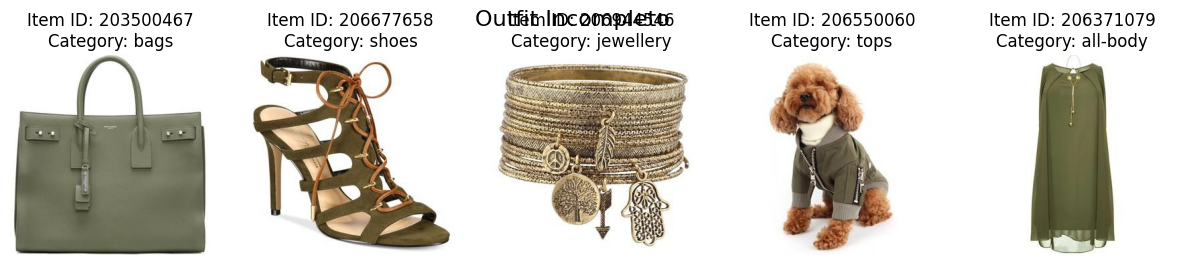

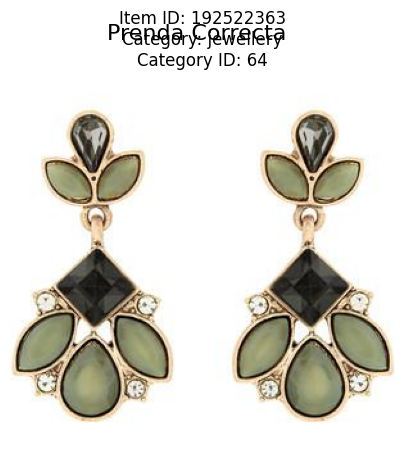


Top 10 prendas predichas para completar el outfit:


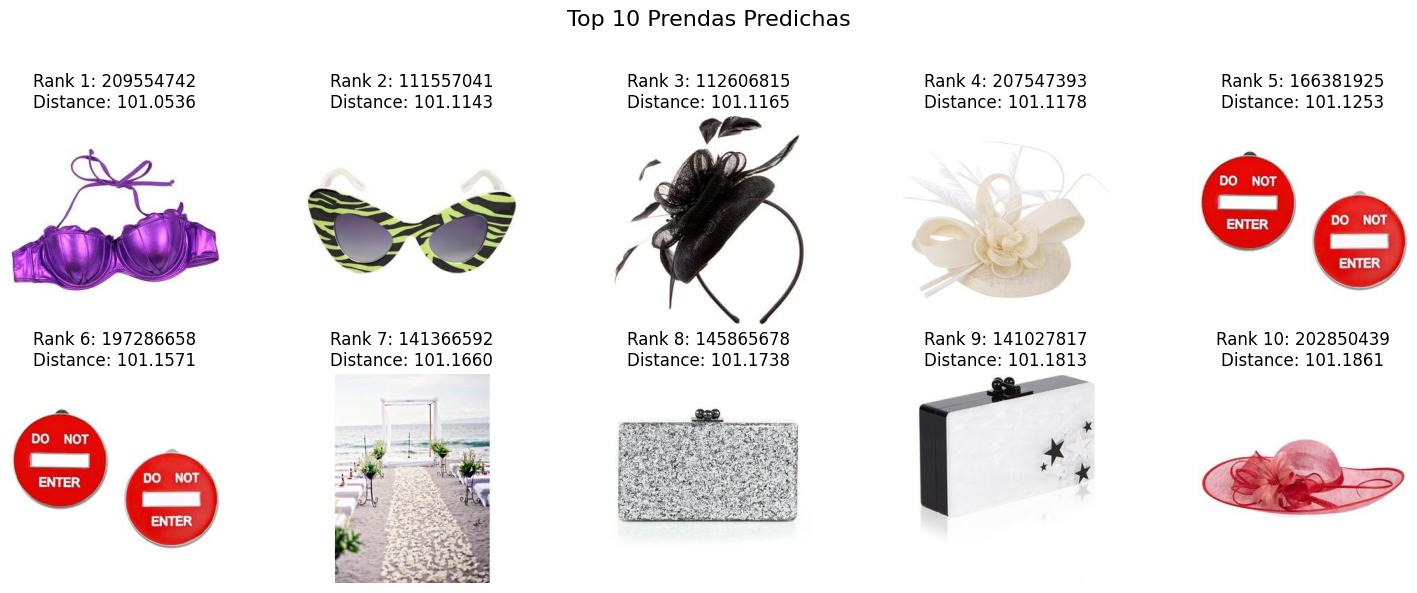

In [10]:
# Celda para cargar el checkpoint, predecir las top 10 prendas y visualizar las imágenes

import faiss
import numpy as np
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

# Cargar el checkpoint de la época 50
checkpoint_path = os.path.join(CHECKPOINT_DIR, 'complementary_clip', 'epoch_50.pth')
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Checkpoint {checkpoint_path} not found.")

checkpoint = torch.load(checkpoint_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')
cir_model.load_state_dict(checkpoint['model'])
cir_model.eval()
logger.info(f"Loaded CIR checkpoint from {checkpoint_path}")
print(f"Loaded CIR checkpoint from {checkpoint_path}")

# Cargar el conjunto de test (outfits incompletos)
test_cir_dataset = PolyvoreFillInTheBlankDataset(
    dataset_dir=cir_args.polyvore_dir,
    dataset_type=cir_args.polyvore_type,
    dataset_split='test',
    metadata=metadata,
    embedding_dict=embedding_dict,
    load_image=False  # No cargamos imágenes aquí, las cargaremos manualmente después
)

# Seleccionar un ejemplo aleatorio del conjunto de test
random_idx = random.randint(0, len(test_cir_dataset) - 1)
example = test_cir_dataset[random_idx]
incomplete_outfit = example['query']  # Outfit incompleto (lista de FashionItem)
correct_item = example['candidates'][example['label']]  # Prenda correcta (FashionItem)

# Mostrar información del outfit incompleto y la prenda correcta
print(f"\nEjemplo aleatorio #{random_idx} del conjunto de test:")
print("Items en el outfit incompleto:")
for item in incomplete_outfit:
    print(f"- Item ID: {item.item_id}, Semantic Category: {item.category}, Category ID: {item.category_id}")
print(f"Prenda correcta: Item ID: {correct_item.item_id}, Semantic Category: {correct_item.category}, Category ID: {correct_item.category_id}")

# Visualizar las imágenes del outfit incompleto
plt.figure(figsize=(15, 3))
plt.suptitle("Outfit Incompleto", fontsize=16)
for i, item in enumerate(incomplete_outfit):
    image = load_image(POLYVORE_DIR, item.item_id)
    if image is not None:
        plt.subplot(1, len(incomplete_outfit), i + 1)
        plt.imshow(image)
        plt.title(f"Item ID: {item.item_id}\nCategory: {item.category}")
        plt.axis('off')
    else:
        print(f"No se pudo cargar la imagen para Item ID: {item.item_id}")
plt.show()

# Visualizar la imagen de la prenda correcta
plt.figure(figsize=(5, 5))
plt.suptitle("Prenda Correcta", fontsize=16)
image = load_image(POLYVORE_DIR, correct_item.item_id)
if image is not None:
    plt.imshow(image)
    plt.title(f"Item ID: {correct_item.item_id}\nCategory: {correct_item.category}\nCategory ID: {correct_item.category_id}")
    plt.axis('off')
    plt.show()
else:
    print(f"No se pudo cargar la imagen para la prenda correcta Item ID: {correct_item.item_id}")

# Calcular el target_embedding del outfit incompleto
with torch.no_grad():
    target_embedding = get_cls_embedding(cir_model, [incomplete_outfit], device, use_precomputed_embedding=True)
    target_embedding = target_embedding.cpu().numpy()  # (1, d_model)

# Preparar todos los embeddings de los ítems para la búsqueda
# Convertir los embeddings de fashion_items a un tensor
all_item_ids = list(fashion_items.keys())
all_embeddings = []
for item_id in all_item_ids:
    item = fashion_items[item_id]
    embedding = item.embedding  # Embedding CLIP precomputado (1024,)
    all_embeddings.append(embedding)
all_embeddings = np.stack(all_embeddings).astype('float32')  # (n_items, 1024)

# Proyectar todos los embeddings al espacio d_model usando model.fc
with torch.no_grad():
    all_embeddings_tensor = torch.from_numpy(all_embeddings).to(device)
    projected_embeddings = cir_model.fc(all_embeddings_tensor).cpu().numpy()  # (n_items, d_model)

# Crear un índice FAISS para búsqueda de vecinos más cercanos
d_model = projected_embeddings.shape[1]  # Dimensión del embedding (128)
index = faiss.IndexFlatL2(d_model)  # Usar distancia L2 (euclidiana)
index.add(projected_embeddings)  # Añadir todos los embeddings al índice

# Buscar los 10 ítems más cercanos al target_embedding
k = 10
distances, indices = index.search(target_embedding, k)

# Mostrar las top 10 prendas predichas con imágenes
print("\nTop 10 prendas predichas para completar el outfit:")
plt.figure(figsize=(15, 6))
plt.suptitle("Top 10 Prendas Predichas", fontsize=16)
for i, (distance, idx) in enumerate(zip(distances[0], indices[0])):
    item_id = all_item_ids[idx]
    item = fashion_items[item_id]
    # print(f"{i+1}. Item ID: {item.item_id}, Semantic Category: {item.category}, Category ID: {item.category_id}, Distance: {distance:.4f}")
    
    # Visualizar la imagen
    image = load_image(POLYVORE_DIR, item_id)
    plt.subplot(2, 5, i + 1)
    if image is not None:
        plt.imshow(image)
        plt.title(f"Rank {i+1}: {item_id}\nDistance: {distance:.4f}")
        plt.axis('off')
    else:
        plt.text(0.5, 0.5, f"No image\n{item_id}", ha='center', va='center')
        plt.axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Prueba a samplear negativos de misma subcategoria, distinto cluster

In [2]:
# OutfitTransformer CIR with Curriculum Learning (Optimizado y con Reanudación de Checkpoint Corregida)

# ------------------------------
# Section 1: Setup and Imports
# ------------------------------

# Import standard libraries for data handling, logging, and visualization
import json
import logging
import os
import pathlib
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter, defaultdict
from tqdm import tqdm
from typing import Any, Dict, List, Literal, Optional
from dataclasses import dataclass

# Import PyTorch and related modules for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn.functional as F

# Import torchvision for image preprocessing
import torchvision.transforms as transforms

# Import transformers for CLIP model
from transformers import CLIPProcessor, CLIPModel

# Import sklearn for metrics
from sklearn.metrics import roc_auc_score

# Disable tokenizer parallelism to avoid warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Define project-wide paths
SRC_DIR = pathlib.Path(os.getcwd()).absolute()
LOGS_DIR = SRC_DIR / 'logs'
CHECKPOINT_DIR = SRC_DIR / 'checkpoints'
POLYVORE_DIR = './datasets/polyvore'
POLYVORE_METADATA_PATH = f"{POLYVORE_DIR}/item_metadata.json"
POLYVORE_IMAGE_DATA_PATH = f"{POLYVORE_DIR}/images/{{item_id}}.jpg"
POLYVORE_PRECOMPUTED_CLIP_EMBEDDING_DIR = f"{POLYVORE_DIR}/precomputed_clip_embeddings"
POLYVORE_TASK_DATA_PATH = f"{POLYVORE_DIR}/{{dataset_type}}/{{dataset_task}}/{{dataset_split}}.json"
POLYVORE_SET_DATA_PATH = f"{POLYVORE_DIR}/{{dataset_type}}/{{dataset_split}}.json"

# Create directories if they don't exist
os.makedirs(LOGS_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR / 'compatibility_clip', exist_ok=True)
os.makedirs(CHECKPOINT_DIR / 'complementary_clip', exist_ok=True)
os.makedirs(POLYVORE_PRECOMPUTED_CLIP_EMBEDDING_DIR, exist_ok=True)

# Configure logging for the entire notebook
logging.basicConfig(
    filename=LOGS_DIR / 'outfit_transformer.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger('outfit_transformer')

# Log notebook start
logger.info("Starting OutfitTransformer notebook")
print("Starting OutfitTransformer notebook")

# ------------------------------
# Section 2: Utility Functions and Classes
# ------------------------------

# Utility function to set random seeds for reproducibility
def seed_everything(seed=42):
    """Set random seeds for reproducibility across random, numpy, and PyTorch.

    Args:
        seed (int): Random seed value (default: 42).
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    logger.info(f"Set random seed to {seed}")

# Set seed for reproducibility
seed_everything(42)

# FashionItem class to represent items in the Polyvore dataset (modificado para incluir category_id)
class FashionItem:
    """Represents a fashion item with metadata, image, and embedding.

    Attributes:
        item_id (str): Unique identifier for the item.
        category (str): Semantic category (e.g., top, bottom, shoes).
        category_id (int): Subcategory ID of the item.
        image (PIL.Image or None): Loaded image of the item.
        description (str): Text description or title of the item.
        metadata (dict): Additional metadata from item_metadata.json.
        embedding (np.ndarray or None): Precomputed CLIP embedding (1024,).
    """
    def __init__(self, item_id, category, category_id, image=None, description="", metadata=None, embedding=None):
        self.item_id = str(item_id)  # Ensure item_id is a string
        self.category = category
        self.category_id = category_id
        self.image = image
        self.description = description
        self.metadata = metadata or {}
        self.embedding = embedding

# Load metadata from item_metadata.json
def load_metadata(dataset_dir):
    """Load item metadata from item_metadata.json.

    Args:
        dataset_dir (str): Path to the Polyvore dataset directory.

    Returns:
        dict: Dictionary mapping item_id to metadata.
    """
    metadata = {}
    with open(POLYVORE_METADATA_PATH.format(dataset_dir=dataset_dir), 'r') as f:
        metadata_ = json.load(f)
        for item in metadata_:
            item_id = str(item['item_id'])  # Ensure item_id is a string
            metadata[item_id] = item
    logger.info(f"Loaded {len(metadata)} metadata entries")
    print(f"Loaded {len(metadata)} metadata entries")
    return metadata

# Load image for an item
def load_image(dataset_dir, item_id, size=(224, 224)):
    """Load an image for a given item_id.

    Args:
        dataset_dir (str): Path to the Polyvore dataset directory.
        item_id (str): Unique identifier for the item.
        size (tuple): Target image size (height, width) (default: (224, 224)).

    Returns:
        PIL.Image or None: Loaded image or None if loading fails.
    """
    image_path = POLYVORE_IMAGE_DATA_PATH.format(dataset_dir=dataset_dir, item_id=item_id)
    try:
        image = Image.open(image_path).convert('RGB')
        return image
    except Exception as e:
        logger.error(f"Error loading image {image_path}: {e}")
        print(f"Error loading image {image_path}: {e}")
        return None

# Load a FashionItem object (modificado para incluir category_id)
def load_item(dataset_dir, metadata, item_id, should_load_image=False, embedding_dict=None):
    """Load a FashionItem object with metadata, image, and embedding.

    Args:
        dataset_dir (str): Path to the Polyvore dataset directory.
        metadata (dict): Dictionary of item metadata.
        item_id (str): Unique identifier for the item.
        should_load_image (bool): Whether to load the item image.
        embedding_dict (dict or None): Dictionary mapping item_id to CLIP embedding.

    Returns:
        FashionItem: Object containing item data.
    """
    item_id = str(item_id)  # Ensure item_id is a string
    metadata_ = metadata[item_id]
    return FashionItem(
        item_id=metadata_['item_id'],
        category=metadata_['semantic_category'],
        category_id=metadata_['category_id'],
        image=load_image(dataset_dir, metadata_['item_id']) if should_load_image else None,
        description=metadata_['title'] if metadata_.get('title') else metadata_['url_name'],
        metadata=metadata_,
        embedding=embedding_dict[item_id] if embedding_dict else None
    )

# Load precomputed CLIP embeddings
def load_embedding_dict(dataset_dir):
    """Load precomputed CLIP embeddings from .pkl files.

    Args:
        dataset_dir (str): Path to the Polyvore dataset directory.

    Returns:
        dict: Dictionary mapping item_id to embedding (1024,).
    """
    e_dir = POLYVORE_PRECOMPUTED_CLIP_EMBEDDING_DIR.format(polyvore_dir=dataset_dir)
    filenames = [f for f in os.listdir(e_dir) if f.endswith('.pkl') and 'official' not in f]
    filenames.sort(key=lambda x: int(x.split('.')[0].split('_')[-1]))

    all_ids, all_embeddings = [], []
    for filename in filenames:
        filepath = os.path.join(e_dir, filename)
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
            all_ids += [str(item_id) for item_id in data['ids']]  # Ensure item_id is a string
            all_embeddings.append(data['embeddings'])

    all_embeddings = np.concatenate(all_embeddings, axis=0)  # (n_items, 1024)
    embedding_dict = {item_id: embedding for item_id, embedding in zip(all_ids, all_embeddings)}
    logger.info(f"Loaded {len(all_embeddings)} embeddings into dictionary")
    print(f"Loaded {len(all_embeddings)} embeddings into dictionary")
    return embedding_dict

# Load task data from JSON files
def load_task_data(dataset_dir, dataset_type, task, dataset_split):
    """Load task-specific data from JSON files.

    Args:
        dataset_dir (str): Path to the Polyvore dataset directory.
        dataset_type (str): Dataset type (e.g., 'nondisjoint').
        task (str): Task name (e.g., 'compatibility', 'fill_in_the_blank').
        dataset_split (str): Dataset split (e.g., 'train', 'valid', 'test').

    Returns:
        list: List of task data entries.
    """
    with open(
        POLYVORE_TASK_DATA_PATH.format(
            dataset_dir=dataset_dir,
            dataset_type=dataset_type,
            dataset_task=task,
            dataset_split=dataset_split
        ), 'r'
    ) as f:
        data = json.load(f)
    logger.info(f"Loaded {len(data)} {task} {dataset_split} entries")
    return data

# Load set data for CIR training
def load_set_data(dataset_dir, dataset_type, dataset_split):
    """Load set data for CIR training from JSON files.

    Args:
        dataset_dir (str): Path to the Polyvore dataset directory.
        dataset_type (str): Dataset type (e.g., 'nondisjoint').
        dataset_split (str): Dataset split (e.g., 'train', 'valid', 'test').

    Returns:
        list: List of set data entries.
    """
    with open(
        POLYVORE_SET_DATA_PATH.format(
            dataset_dir=dataset_dir,
            dataset_type=dataset_type,
            dataset_split=dataset_split
        ), 'r'
    ) as f:
        data = json.load(f)
    logger.info(f"Loaded {len(data)} {dataset_split} set entries")
    return data

# Load checkpoint
def load_checkpoint(model, checkpoint_path):
    """Load a model's state dictionary from a checkpoint file.

    Args:
        model (nn.Module): The model to load the state dictionary into.
        checkpoint_path (str): Path to the checkpoint file (.pth).

    Returns:
        nn.Module: The model with the loaded state dictionary, set to evaluation mode.
    """
    checkpoint = torch.load(checkpoint_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    model.load_state_dict(checkpoint['model'])
    model.eval()
    logger.info(f"Loaded checkpoint from {checkpoint_path}")
    return model

# ------------------------------
# Section 3: Load Precomputed CLIP Embeddings and CP Model
# ------------------------------

# Load metadata and embeddings
metadata = load_metadata(POLYVORE_DIR)
embedding_dict = load_embedding_dict(POLYVORE_DIR)

# Precompute FashionItem objects and item lists for faster sampling
fashion_items = {}
items_by_semantic_category = defaultdict(list)
items_by_category_id = defaultdict(list)

# Also precompute fallback candidates for each category_id
category_id_to_fallback = defaultdict(list)

for item_id in tqdm(metadata.keys(), desc="Precomputing FashionItem objects and lists"):
    item = load_item(POLYVORE_DIR, metadata, item_id, should_load_image=False, embedding_dict=embedding_dict)
    fashion_items[item_id] = item
    items_by_semantic_category[item.category].append(item_id)
    items_by_category_id[item.category_id].append(item_id)
    # Map each category_id to the list of item_ids in its semantic_category
    category_id_to_fallback[item.category_id] = items_by_semantic_category[item.category]

logger.info(f"Precomputed {len(fashion_items)} FashionItem objects")
logger.info(f"Precomputed item lists: {len(items_by_semantic_category)} semantic categories, {len(items_by_category_id)} category IDs")
print(f"Precomputed {len(fashion_items)} FashionItem objects")
print(f"Precomputed item lists: {len(items_by_semantic_category)} semantic categories, {len(items_by_category_id)} category IDs")

# Load the cluster dictionaries
def load_dictionaries(base_dir):
    """Carga los diccionarios desde los archivos pickle."""
    with open(os.path.join(base_dir, 'item_to_info.pkl'), 'rb') as f:
        item_to_info = pickle.load(f)
    with open(os.path.join(base_dir, 'cluster_to_items.pkl'), 'rb') as f:
        cluster_to_items = pickle.load(f)
    with open(os.path.join(base_dir, 'category_to_clusters.pkl'), 'rb') as f:
        category_to_clusters = pickle.load(f)
    print("Diccionarios cargados desde kmeans:")
    print(f"- item_to_info: {len(item_to_info)} prendas")
    print(f"- cluster_to_items: {len(cluster_to_items)} combinaciones")
    print(f"- category_to_clusters: {len(category_to_clusters)} combinaciones")
    return item_to_info, cluster_to_items, category_to_clusters

# Load cluster dictionaries
item_to_info, cluster_to_items, category_to_clusters = load_dictionaries('kmeans')

# Modified function to sample negatives dynamically using clusters
def sample_negatives_from_different_clusters(positive_item_id, item_to_info, cluster_to_items, category_to_clusters, num_negatives=5):
    """
    Dado un item_id positivo, samplea negativos de la misma semantic_category y category_id
    pero de distintos clusters al del positivo.
    
    Args:
        positive_item_id (str): ID de la prenda positiva.
        item_to_info (dict): Diccionario que mapea item_id a su información.
        cluster_to_items (dict): Diccionario que mapea (semantic_category, category_id, cluster_id) a item_id.
        category_to_clusters (dict): Diccionario que mapea (semantic_category, category_id) a un conjunto de cluster_id.
        num_negatives (int): Número de negativos a samplear.
    
    Returns:
        list: Lista de item_id de negativos sampleados.
    """
    positive_item_id = str(positive_item_id)  # Ensure positive_item_id is a string
    if positive_item_id not in item_to_info:
        logger.warning(f"Item ID {positive_item_id} no encontrado en item_to_info.")
        return []
    
    info = item_to_info[positive_item_id]
    semantic_cat = info['semantic_category']
    category_id = info['category_id']
    positive_cluster = info['cluster_id']
    
    category_key = (semantic_cat, category_id)
    if category_key not in category_to_clusters:
        logger.warning(f"No se encontraron clusters para {semantic_cat}/{category_id}.")
        return []
    
    all_clusters = category_to_clusters[category_key]
    possible_clusters = [cluster_id for cluster_id in all_clusters if cluster_id != positive_cluster]
    
    if not possible_clusters:
        logger.warning(f"No se encontraron clusters distintos para {semantic_cat}/{category_id}.")
        return []
    
    negatives = []
    attempts = 0
    max_attempts = num_negatives * 10  # Avoid infinite loops
    while len(negatives) < num_negatives and attempts < max_attempts:
        cluster_id = possible_clusters[np.random.randint(len(possible_clusters))]
        cluster_key = (semantic_cat, category_id, cluster_id)
        items_in_cluster = cluster_to_items[cluster_key]
        
        negative_item = np.random.choice(items_in_cluster)
        negative_item = str(negative_item)  # Ensure negative_item is a string
        negatives.append(negative_item)
        attempts += 1
    
    return negatives

# Modified function to sample negatives dynamically using clusters
def sample_negatives(answer, items_by_semantic_category, fashion_items, item_to_info, cluster_to_items, category_to_clusters, n_negatives=10, use_category_id=False, use_different_clusters=False):
    """
    Sample negative items dynamically for a given answer using precomputed lists or clusters.

    Args:
        answer (FashionItem): The correct item (positive).
        items_by_semantic_category (dict): Dict mapping semantic_category to list of item_ids.
        fashion_items (dict): Dict mapping item_id to precomputed FashionItem objects.
        item_to_info (dict): Dict mapping item_id to its semantic_category, category_id, and cluster_id.
        cluster_to_items (dict): Dict mapping (semantic_category, category_id, cluster_id) to list of item_ids.
        category_to_clusters (dict): Dict mapping (semantic_category, category_id) to set of cluster_ids.
        n_negatives (int): Number of negatives to sample.
        use_category_id (bool): If True, sample from the same category_id.
        use_different_clusters (bool): If True, sample from different clusters within the same category_id.

    Returns:
        List[FashionItem]: List of sampled negative items.
    """
    answer_id = str(answer.item_id)  # Ensure answer_id is a string
    if use_category_id and use_different_clusters:
        # Sample negatives from the same category_id but different clusters
        sampled_negative_ids = sample_negatives_from_different_clusters(
            positive_item_id=answer_id,
            item_to_info=item_to_info,
            cluster_to_items=cluster_to_items,
            category_to_clusters=category_to_clusters,
            num_negatives=n_negatives
        )
    elif use_category_id:
        # Original behavior: Sample from the same category_id (not implemented since we want clusters)
        candidate_ids = items_by_semantic_category.get(answer.category, [])
        sampled_negative_ids = random.sample(candidate_ids, min(n_negatives, len(candidate_ids))) if candidate_ids else []
    else:
        # Sample from the same semantic_category
        candidate_ids = items_by_semantic_category.get(answer.category, [])
        sampled_negative_ids = random.sample(candidate_ids, min(n_negatives, len(candidate_ids))) if candidate_ids else []

    # Exclude the positive item (answer.item_id) from candidates
    sampled_negative_ids = [str(item_id) for item_id in sampled_negative_ids if str(item_id) != answer_id]

    # Retrieve precomputed FashionItem objects, skipping items not in fashion_items
    negatives = []
    for item_id in sampled_negative_ids:
        if item_id in fashion_items:
            negatives.append(fashion_items[item_id])
        else:
            logger.warning(f"Item ID {item_id} not found in fashion_items, skipping.")

    # Pad with dummy items if we don't have enough negatives
    while len(negatives) < n_negatives:
        dummy_item = FashionItem(
            item_id="dummy",
            category=answer.category,
            category_id=answer.category_id,
            embedding=np.zeros(1024)
        )
        negatives.append(dummy_item)

    return negatives

# Configuration for OutfitTransformer
@dataclass
class OutfitTransformerConfig:
    """Configuration for OutfitTransformer model."""
    n_items: int = 251008  # Number of unique items in Polyvore
    d_model: int = 128     # Embedding dimension
    n_layers: int = 4      # Number of transformer layers
    n_head: int = 4        # Number of attention heads
    dropout: float = 0.1   # Dropout rate
    item_enc_norm_out: bool = True
    aggregation_method: str = 'concat'

@dataclass
class OutfitCLIPTransformerConfig(OutfitTransformerConfig):
    """Configuration for OutfitCLIPTransformer, extending OutfitTransformerConfig."""
    item_enc_clip_model_name: str = "patrickjohncyh/fashion-clip"

# OutfitTransformer model
class OutfitTransformer(nn.Module):
    """Transformer model for outfit compatibility prediction.

    Architecture:
        - Input: List of outfits, each a list of FashionItem objects with CLIP embeddings (1024,).
        - Linear layer: Projects CLIP embeddings to d_model (1024 -> 128).
        - CLS token: Learnable token prepended to each outfit sequence.
        - Transformer Encoder: Processes outfit embeddings with attention.
        - Classification Head: Maps CLS token embedding to a logit.
    """
    def __init__(self, cfg=OutfitTransformerConfig()):
        super().__init__()
        self.cfg = cfg
        self.fc = nn.Linear(1024, cfg.d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=cfg.d_model, nhead=cfg.n_head, dropout=cfg.dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=cfg.n_layers)
        self.cls_token = nn.Parameter(torch.randn(1, 1, cfg.d_model))
        self.classification_head = nn.Linear(cfg.d_model, 1)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def forward(self, queries, use_precomputed_embedding=True):
        batch_size = len(queries)
        max_len = max(len(query) for query in queries)

        embeddings = []
        mask = []
        for query in queries:
            outfit_embeds = torch.from_numpy(np.array([item.embedding for item in query])).to(
                dtype=torch.float32, device=self.device
            )
            padded_embeds = torch.zeros(max_len, 1024, device=self.device)
            padded_embeds[:len(query)] = outfit_embeds
            embeddings.append(padded_embeds)
            outfit_mask = torch.zeros(max_len, device=self.device)
            outfit_mask[len(query):] = 1
            mask.append(outfit_mask)

        embeddings = torch.stack(embeddings, dim=0)
        mask = torch.stack(mask, dim=0)

        embeddings = self.fc(embeddings)
        cls_token = self.cls_token.expand(batch_size, -1, -1)
        features = torch.cat([cls_token, embeddings], dim=1)
        cls_mask = torch.zeros(batch_size, 1, device=self.device)
        mask = torch.cat([cls_mask, mask], dim=1)

        transformed_features = self.transformer_encoder(features, src_key_padding_mask=mask.bool())
        outfit_embedding = transformed_features[:, 0, :]
        logits = self.classification_head(outfit_embedding)
        return logits.squeeze(-1)

# OutfitCLIPTransformer model
class OutfitCLIPTransformer(OutfitTransformer):
    """OutfitTransformer specialized for CLIP embeddings."""
    def __init__(self, cfg=OutfitCLIPTransformerConfig()):
        super().__init__(cfg)
        logger.info("Initialized OutfitCLIPTransformer")

# Load CP model from checkpoint
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cp_model = OutfitCLIPTransformer(OutfitCLIPTransformerConfig(n_items=len(metadata))).to(device)
checkpoint_path = os.path.join(CHECKPOINT_DIR, 'compatibility_clip', 'epoch_50.pth')
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"Checkpoint {checkpoint_path} not found.")
cp_model = load_checkpoint(cp_model, checkpoint_path)
logger.info(f"Loaded CP checkpoint from {checkpoint_path}")

# ------------------------------
# Section 4: Train CIR with Curriculum Learning
# ------------------------------

# Dataset for CIR training
class PolyvoreTripletDataset(Dataset):
    """Dataset for CIR training, generating query-answer pairs."""
    def __init__(self, dataset_dir, dataset_type='nondisjoint', dataset_split='train',
                 metadata=None, embedding_dict=None, load_image=False):
        self.dataset_dir = dataset_dir
        self.metadata = metadata if metadata else load_metadata(dataset_dir)
        self.data = load_set_data(dataset_dir, dataset_type, dataset_split)
        self.load_image = load_image
        self.embedding_dict = embedding_dict
        logger.info(f"{dataset_split} CIR triplet dataset: {len(self.data)} sets")
        print(f"{dataset_split} CIR triplet dataset: {len(self.data)} sets")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        items = [
            load_item(self.dataset_dir, self.metadata, item_id,
                      self.load_image, self.embedding_dict)
            for item_id in self.data[idx]['item_ids']
        ]
        answer = items[random.randint(0, len(items) - 1)]
        outfit = [item for item in items if item != answer]
        return {'query': outfit, 'answer': answer}

# Dataset for CIR validation
class PolyvoreFillInTheBlankDataset(Dataset):
    """Dataset for CIR validation, providing queries and candidate items."""
    def __init__(self, dataset_dir, dataset_type='nondisjoint', dataset_split='valid',
                 metadata=None, embedding_dict=None, load_image=False):
        self.dataset_dir = dataset_dir
        self.metadata = metadata if metadata else load_metadata(dataset_dir)
        self.data = load_task_data(dataset_dir, dataset_type, 'fill_in_the_blank', dataset_split)
        self.load_image = load_image
        self.embedding_dict = embedding_dict
        labels = [item['label'] for item in self.data]
        label_counts = Counter(labels)
        logger.info(f"{dataset_split} CIR FITB dataset: {len(self.data)} outfits, Label distribution: {label_counts}")
        print(f"{dataset_split} CIR FITB dataset: {len(self.data)} outfits, Label distribution: {label_counts}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = self.data[idx]['label']
        candidates = [
            load_item(self.dataset_dir, self.metadata, item_id,
                      self.load_image, self.embedding_dict)
            for item_id in self.data[idx]['answers']
        ]
        outfit = [
            load_item(self.dataset_dir, self.metadata, item_id,
                      self.load_image, self.embedding_dict)
            for item_id in self.data[idx]['question']
        ]
        return {'query': outfit, 'label': label, 'candidates': candidates}

# Collate functions for CIR
def triplet_collate_fn(batch):
    """Collate function for PolyvoreTripletDataset."""
    query = [item['query'] for item in batch]
    answer = [item['answer'] for item in batch]
    return {'query': query, 'answer': answer}

def fitb_collate_fn(batch):
    """Collate function for PolyvoreFillInTheBlankDataset."""
    query = [item['query'] for item in batch]
    label = [item['label'] for item in batch]
    candidates = [item['candidates'] for item in batch]
    return {'query': query, 'label': label, 'candidates': candidates}

# InBatchTripletMarginLoss for CIR
class InBatchTripletMarginLoss(nn.Module):
    """In-batch triplet margin loss for CIR."""
    def __init__(self, margin: float = 2.0, reduction: str = "mean"):
        super().__init__()
        self.margin = margin
        self.reduction = reduction

    def forward(self, batched_q_emb: torch.Tensor, batched_a_emb: torch.Tensor):
        batch_size = batched_q_emb.shape[0]
        dists = torch.cdist(batched_q_emb, batched_a_emb, p=2)
        pos_dists = torch.diag(dists)
        neg_dists = dists.clone()
        neg_dists.fill_diagonal_(float('inf'))
        hardest_neg_dists, _ = neg_dists.min(dim=1)
        loss = torch.relu(pos_dists - hardest_neg_dists + self.margin)

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss

# Metrics for CIR
def compute_cir_scores(predictions: torch.Tensor, labels: torch.Tensor):
    """Compute accuracy for CIR."""
    accuracy = torch.mean((predictions == labels).float()).item()
    return {'acc': accuracy}

# Function to get CLS embedding for CIR
def get_cls_embedding(model, queries, device, use_precomputed_embedding=True):
    """Extract CLS token embedding for CIR."""
    batch_size = len(queries)
    max_len = max(len(query) for query in queries)
    embeddings = []
    mask = []
    for query in queries:
        outfit_embeds = torch.from_numpy(np.array([item.embedding for item in query])).to(
            dtype=torch.float32, device=device
        )
        padded_embeds = torch.zeros(max_len, 1024, device=device)
        padded_embeds[:len(query)] = outfit_embeds
        embeddings.append(padded_embeds)
        outfit_mask = torch.zeros(max_len, device=device)
        outfit_mask[len(query):] = 1
        mask.append(outfit_mask)

    embeddings = torch.stack(embeddings, dim=0)
    mask = torch.stack(mask, dim=0)

    embeddings = model.fc(embeddings)
    cls_token = model.cls_token.expand(batch_size, -1, -1)
    features = torch.cat([cls_token, embeddings], dim=1)
    cls_mask = torch.zeros(batch_size, 1, device=device)
    mask = torch.cat([cls_mask, mask], dim=1)

    transformed_features = model.transformer_encoder(features, src_key_padding_mask=mask.bool())
    outfit_embedding = transformed_features[:, 0, :]
    return outfit_embedding

# Training function for CIR with Curriculum Learning
def train_cir(args, model, train_dataloader, valid_dataloader, optimizer, scheduler, loss_fn, device, metadata, embedding_dict, items_by_semantic_category, items_by_category_id, category_id_to_fallback, fashion_items, item_to_info, cluster_to_items, category_to_clusters):
    """Train the Category-aware Image Retrieval model with curriculum learning.

    Args:
        args (Args): Training arguments.
        model (OutfitCLIPTransformer): Model to train.
        train_dataloader (DataLoader): Training DataLoader.
        valid_dataloader (DataLoader): Validation DataLoader.
        optimizer (optim.Optimizer): Optimizer.
        scheduler (optim.lr_scheduler): Learning rate scheduler.
        loss_fn (nn.Module): Loss function (InBatchTripletMarginLoss).
        device (torch.device): Device (CPU/GPU).
        metadata (dict): Item metadata.
        embedding_dict (dict): Dictionary mapping item_id to embedding.
        items_by_semantic_category (dict): Dict mapping semantic_category to list of item_ids.
        items_by_category_id (dict): Dict mapping category_id to list of item_ids.
        category_id_to_fallback (dict): Dict mapping category_id to its semantic_category item_ids.
        fashion_items (dict): Dict mapping item_id to precomputed FashionItem objects.
        item_to_info (dict): Dict mapping item_id to its semantic_category, category_id, and cluster_id.
        cluster_to_items (dict): Dict mapping (semantic_category, category_id, cluster_id) to list of item_ids.
        category_to_clusters (dict): Dict mapping (semantic_category, category_id) to set of cluster_ids.

    Returns:
        tuple: Lists of train_losses, train_accs, valid_accs.
    """
    train_losses, train_accs, valid_accs = getattr(args, 'train_losses', []), getattr(args, 'train_accs', []), getattr(args, 'valid_accs', [])

    for epoch in range(args.start_epoch, args.n_epochs):
        # Determine negative sampling strategy based on epoch
        if epoch < 40:
            negative_strategy = "batch"  # Use positives from other examples in the batch
            n_negatives = 0  # Not used in batch mode
            use_category_id = False
            use_different_clusters = False
        elif 40 <= epoch < 50:
            negative_strategy = "semantic_category"  # Sample 10 negatives from semantic_category
            n_negatives = 10
            use_category_id = False
            use_different_clusters = False
        else:  # epoch >= 50
            negative_strategy = "category_id_different_clusters"  # Sample 10 negatives from category_id, different clusters
            n_negatives = 10
            use_category_id = True
            use_different_clusters = True

        # Training
        model.train()
        train_loss, all_preds, all_labels = 0.0, [], []
        pbar = tqdm(train_dataloader, desc=f'Train CIR Epoch {epoch+1}/{args.n_epochs} (Neg: {negative_strategy})')
        for i, data in enumerate(pbar):
            queries = data['query']
            answers = data['answer']  # List of FashionItem objects (positives)

            # Compute query embeddings
            batched_q_emb = get_cls_embedding(model, queries, device, use_precomputed_embedding=True)

            if negative_strategy == "batch":
                # Original strategy: negatives are the positives of other examples in the batch
                batched_a_emb = get_cls_embedding(model, [[answer] for answer in answers], device, use_precomputed_embedding=True)
            else:
                # New strategy: sample negatives dynamically for each query
                batched_a_emb_list = []
                for answer in answers:
                    # Positive embedding
                    pos_emb = get_cls_embedding(model, [[answer]], device, use_precomputed_embedding=True)
                    # Sample negatives
                    negatives = sample_negatives(
                        answer=answer,
                        items_by_semantic_category=items_by_semantic_category,
                        fashion_items=fashion_items,
                        item_to_info=item_to_info,
                        cluster_to_items=cluster_to_items,
                        category_to_clusters=category_to_clusters,
                        n_negatives=n_negatives,
                        use_category_id=use_category_id,
                        use_different_clusters=use_different_clusters
                    )
                    neg_embs = get_cls_embedding(model, [[neg] for neg in negatives], device, use_precomputed_embedding=True)
                    # Combine positive and negatives
                    combined_emb = torch.cat([pos_emb, neg_embs], dim=0)  # (1 + n_negatives, d_model)
                    batched_a_emb_list.append(combined_emb)

                # Stack to form (batch_size, 1 + n_negatives, d_model)
                batched_a_emb = torch.stack(batched_a_emb_list)

            # Compute loss
            if negative_strategy == "batch":
                # In-batch triplet loss
                loss = loss_fn(batched_q_emb, batched_a_emb) / args.accumulation_steps
            else:
                # Compute distances for each query to its positives and negatives
                batch_size = batched_q_emb.shape[0]
                dists = torch.norm(batched_q_emb.unsqueeze(1) - batched_a_emb, dim=-1)  # (batch_size, 1 + n_negatives)
                pos_dists = dists[:, 0]  # Distances to positives (batch_size,)
                neg_dists = dists[:, 1:]  # Distances to negatives (batch_size, n_negatives)
                hardest_neg_dists, _ = neg_dists.min(dim=1)  # (batch_size,)
                loss = torch.relu(pos_dists - hardest_neg_dists + loss_fn.margin) / args.accumulation_steps
                if loss_fn.reduction == "mean":
                    loss = loss.mean()
                elif loss_fn.reduction == "sum":
                    loss = loss.sum()

            loss.backward()

            # Gradient accumulation
            if (i + 1) % args.accumulation_steps == 0:
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()
                scheduler.step()

            train_loss += loss.item() * args.accumulation_steps

            # Compute predictions for accuracy
            if negative_strategy == "batch":
                dists = torch.cdist(batched_q_emb, batched_a_emb, p=2)
                preds = torch.argmin(dists, dim=1)
                labels = torch.arange(len(preds), device=device, dtype=torch.long)  # Correct labels for in-batch mode
            else:
                dists = torch.norm(batched_q_emb.unsqueeze(1) - batched_a_emb, dim=-1)
                preds = torch.argmin(dists, dim=1)
                labels = torch.zeros(len(preds), device=device, dtype=torch.long)  # Positive is always at index 0

            all_preds.append(preds.detach())
            all_labels.append(labels.detach())

            score = compute_cir_scores(preds, labels)
            pbar.set_postfix(loss=loss.item() * args.accumulation_steps, acc=score['acc'])

        train_loss /= len(train_dataloader)
        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        train_scores = compute_cir_scores(all_preds, all_labels)
        train_losses.append(train_loss)
        train_accs.append(train_scores['acc'])
        logger.info(f'Epoch {epoch+1}/{args.n_epochs} Train CIR --> Loss: {train_loss:.4f}, '
                   f'Acc: {train_scores["acc"]:.4f}')
        print(f'Epoch {epoch+1}/{args.n_epochs} Train CIR --> Loss: {train_loss:.4f}, '
              f'Acc: {train_scores["acc"]:.4f}')

        # Validation
        model.eval()
        all_preds, all_labels = [], []
        pbar = tqdm(valid_dataloader, desc=f'Valid CIR Epoch {epoch+1}/{args.n_epochs}')
        with torch.no_grad():
            for i, data in enumerate(pbar):
                queries = data['query']
                candidates = data['candidates']
                labels = torch.tensor(data['label'], device=device)

                batched_q_emb = get_cls_embedding(model, queries, device,
                                                use_precomputed_embedding=True).unsqueeze(1)
                batched_c_embs = []
                for cand_group in candidates:
                    cand_embs = get_cls_embedding(model, [[cand] for cand in cand_group], device,
                                                 use_precomputed_embedding=True)
                    batched_c_embs.append(cand_embs)
                batched_c_embs = torch.stack(batched_c_embs)

                dists = torch.norm(batched_q_emb - batched_c_embs, dim=-1)
                preds = torch.argmin(dists, dim=-1)

                all_preds.append(preds)
                all_labels.append(labels)

                score = compute_cir_scores(preds, labels)
                pbar.set_postfix(acc=score['acc'])

        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        valid_scores = compute_cir_scores(all_preds, all_labels)
        valid_accs.append(valid_scores['acc'])
        logger.info(f'Epoch {epoch+1}/{args.n_epochs} Valid CIR --> Acc: {valid_scores["acc"]:.4f}')
        print(f'Epoch {epoch+1}/{args.n_epochs} Valid CIR --> Acc: {valid_scores["acc"]:.4f}')

        # Save checkpoint
        checkpoint_path = os.path.join(CHECKPOINT_DIR, 'complementary_clip', f'epoch_{epoch+1}.pth')
        torch.save({
            'config': model.cfg.__dict__,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'epoch': epoch + 1,
            'train_losses': train_losses,
            'train_accs': train_accs,
            'valid_accs': valid_accs
        }, checkpoint_path)
        logger.info(f'Checkpoint saved at {checkpoint_path}')
        print(f'Checkpoint saved at {checkpoint_path}')

    return train_losses, train_accs, valid_accs

# Configuration for CIR training
class CIRArgs:
    """Configuration for Category-aware Image Retrieval training."""
    model_type = 'clip'
    polyvore_dir = POLYVORE_DIR
    polyvore_type = 'nondisjoint'
    batch_sz_per_gpu = 32
    n_workers_per_gpu = 4
    n_epochs = 200
    lr = 2e-5
    accumulation_steps = 4
    wandb_key = None
    seed = 42
    checkpoint = os.path.join(CHECKPOINT_DIR, 'compatibility_clip', 'epoch_50.pth')
    world_size = 1
    project_name = 'complementary_clip_notebook'
    demo = False
    start_epoch = 0  # Starting epoch for training
    resume_from_checkpoint = None  # Path to checkpoint to resume from (e.g., 'epoch_50.pth')

cir_args = CIRArgs()
# Set to resume from epoch_50.pth (or None to start from scratch)
cir_args.resume_from_checkpoint = os.path.join(CHECKPOINT_DIR, 'complementary_clip_CL_good', 'epoch_50.pth')
logger.info(f"CIR Arguments: {vars(cir_args)}")
print(f"CIR Arguments: {vars(cir_args)}")

# Load datasets for CIR
train_cir_dataset = PolyvoreTripletDataset(
    dataset_dir=cir_args.polyvore_dir,
    dataset_type=cir_args.polyvore_type,
    dataset_split='train',
    metadata=metadata,
    embedding_dict=embedding_dict,
    load_image=False
)

valid_cir_dataset = PolyvoreFillInTheBlankDataset(
    dataset_dir=cir_args.polyvore_dir,
    dataset_type=cir_args.polyvore_type,
    dataset_split='valid',
    metadata=metadata,
    embedding_dict=embedding_dict,
    load_image=False
)

# Create DataLoaders
train_cir_dataloader = DataLoader(
    dataset=train_cir_dataset,
    batch_size=cir_args.batch_sz_per_gpu,
    shuffle=True,
    num_workers=cir_args.n_workers_per_gpu,
    collate_fn=triplet_collate_fn
)

valid_cir_dataloader = DataLoader(
    dataset=valid_cir_dataset,
    batch_size=cir_args.batch_sz_per_gpu,
    shuffle=False,
    num_workers=cir_args.n_workers_per_gpu,
    collate_fn=fitb_collate_fn
)

# Initialize model, optimizer, scheduler, and loss
cir_model = OutfitCLIPTransformer(OutfitCLIPTransformerConfig(n_items=len(metadata))).to(device)
if not os.path.exists(cir_args.checkpoint):
    raise FileNotFoundError(f"Checkpoint {cir_args.checkpoint} not found.")
cir_model = load_checkpoint(cir_model, cir_args.checkpoint)
logger.info(f"Loaded CP checkpoint from {cir_args.checkpoint}")

cir_optimizer = optim.AdamW(cir_model.parameters(), lr=cir_args.lr)
cir_scheduler = optim.lr_scheduler.OneCycleLR(
    cir_optimizer,
    max_lr=cir_args.lr,
    epochs=cir_args.n_epochs,
    steps_per_epoch=int(len(train_cir_dataloader) / cir_args.accumulation_steps),
    pct_start=0.3,
    anneal_strategy='cos',
    div_factor=25,
    final_div_factor=1e4
)
cir_loss_fn = InBatchTripletMarginLoss(margin=2.0, reduction='mean')

# Lists to store training and validation metrics
train_losses, train_accs, valid_accs = [], [], []

# Load from checkpoint if specified
if cir_args.resume_from_checkpoint:
    checkpoint_path = cir_args.resume_from_checkpoint
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint {checkpoint_path} not found.")

    checkpoint = torch.load(checkpoint_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    cir_model.load_state_dict(checkpoint['model'])
    if 'optimizer' in checkpoint:
        cir_optimizer.load_state_dict(checkpoint['optimizer'])
        logger.info("Loaded optimizer state from checkpoint")
    else:
        logger.warning("Optimizer state not found in checkpoint, using initial state")
    if 'scheduler' in checkpoint:
        cir_scheduler.load_state_dict(checkpoint['scheduler'])
        logger.info("Loaded scheduler state from checkpoint")
    else:
        logger.warning("Scheduler state not found in checkpoint, using initial state")
    if 'epoch' in checkpoint:
        cir_args.start_epoch = checkpoint['epoch']
        logger.info(f"Resuming training from epoch {cir_args.start_epoch}")
    else:
        # Extract epoch number from checkpoint filename (e.g., 'epoch_50.pth')
        epoch_str = os.path.basename(checkpoint_path).replace('epoch_', '').replace('.pth', '')
        try:
            cir_args.start_epoch = int(epoch_str)
            logger.info(f"Epoch not found in checkpoint, inferred start_epoch={cir_args.start_epoch} from filename")
        except ValueError:
            logger.warning("Could not infer epoch from checkpoint filename, starting from epoch 0")
            cir_args.start_epoch = 0
    if 'train_losses' in checkpoint:
        train_losses = checkpoint['train_losses']
        train_accs = checkpoint['train_accs']
        valid_accs = checkpoint['valid_accs']
        logger.info(f"Loaded training metrics: {len(train_losses)} epochs")
    else:
        logger.warning("Training metrics not found in checkpoint, starting with empty lists")

    logger.info(f"Loaded CIR checkpoint from {checkpoint_path}")

/home/ia/Documentos/TFG_Lara/TFG/outfit-transformer-venv2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Starting OutfitTransformer notebook
Loaded 251008 metadata entries
Loaded 251008 embeddings into dictionary


Precomputing FashionItem objects and lists: 100%|██████████| 251008/251008 [00:00<00:00, 314947.84it/s]


Precomputed 251008 FashionItem objects
Precomputed item lists: 11 semantic categories, 153 category IDs
Diccionarios cargados desde kmeans:
- item_to_info: 250916 prendas
- cluster_to_items: 1208 combinaciones
- category_to_clusters: 138 combinaciones
CIR Arguments: {'resume_from_checkpoint': '/home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip_CL_good/epoch_50.pth'}
train CIR triplet dataset: 53306 sets
valid CIR FITB dataset: 5000 outfits, Label distribution: Counter({0: 5000})


/tmp/ipykernel_10796/2993885781.py:270: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cuda' if torch.cuda.is_available

In [ ]:


# Train CIR model with curriculum learning
train_cir_losses, train_cir_accs, valid_cir_accs = train_cir(
    cir_args, cir_model, train_cir_dataloader, valid_cir_dataloader,
    cir_optimizer, cir_scheduler, cir_loss_fn, device, metadata, embedding_dict,
    items_by_semantic_category, items_by_category_id, category_id_to_fallback, fashion_items,
    item_to_info, cluster_to_items, category_to_clusters
)

# Plot CIR training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_cir_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('CIR Training Loss')
plt.subplot(1, 2, 2)
plt.plot(train_cir_accs, label='Train Acc')
plt.plot(valid_cir_accs, label='Valid Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('CIR Training and Validation Accuracy')
plt.tight_layout()
plt.show()

best_acc, best_epoch = max(zip(valid_cir_accs, range(cir_args.start_epoch + 1, cir_args.n_epochs + 1)))
print(f"Best CIR Validation Accuracy: {best_acc:.4f} at Epoch {best_epoch}")

Starting OutfitTransformer notebook
Loaded 251008 metadata entries
Loaded 251008 embeddings into dictionary


Precomputing FashionItem objects and lists: 100%|██████████| 251008/251008 [00:01<00:00, 192310.22it/s]
/tmp/ipykernel_3695595/2528330124.py:270: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exper

Precomputed 251008 FashionItem objects
Precomputed item lists: 11 semantic categories, 153 category IDs
Diccionarios cargados desde kmeans:
- item_to_info: 250916 prendas
- cluster_to_items: 1208 combinaciones
- category_to_clusters: 138 combinaciones
CIR Arguments: {'resume_from_checkpoint': '/home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip_CL_good/epoch_50.pth'}


/tmp/ipykernel_3695595/2528330124.py:944: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cuda' if torch.cuda.is_availab

train CIR triplet dataset: 53306 sets
valid CIR FITB dataset: 5000 outfits, Label distribution: Counter({0: 5000})


Train CIR Epoch 51/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [07:15<00:00,  3.83it/s, acc=0.423, loss=1.88]


Epoch 51/200 Train CIR --> Loss: 1.9274, Acc: 0.4396


Valid CIR Epoch 51/200: 100%|██████████| 157/157 [00:08<00:00, 18.75it/s, acc=0.875]


Epoch 51/200 Valid CIR --> Acc: 0.6750
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_51.pth


Train CIR Epoch 52/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [07:21<00:00,  3.77it/s, acc=0.538, loss=1.86]


Epoch 52/200 Train CIR --> Loss: 1.9280, Acc: 0.4378


Valid CIR Epoch 52/200: 100%|██████████| 157/157 [00:08<00:00, 19.46it/s, acc=0.875]


Epoch 52/200 Valid CIR --> Acc: 0.6760
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_52.pth


Train CIR Epoch 53/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:50<00:00,  4.05it/s, acc=0.538, loss=1.91]


Epoch 53/200 Train CIR --> Loss: 1.9203, Acc: 0.4417


Valid CIR Epoch 53/200: 100%|██████████| 157/157 [00:08<00:00, 18.14it/s, acc=0.75] 


Epoch 53/200 Valid CIR --> Acc: 0.6756
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_53.pth


Train CIR Epoch 54/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [07:07<00:00,  3.90it/s, acc=0.385, loss=1.99]


Epoch 54/200 Train CIR --> Loss: 1.9241, Acc: 0.4375


Valid CIR Epoch 54/200: 100%|██████████| 157/157 [00:08<00:00, 18.25it/s, acc=0.75] 


Epoch 54/200 Valid CIR --> Acc: 0.6752
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_54.pth


Train CIR Epoch 55/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:52<00:00,  4.04it/s, acc=0.385, loss=2.07]


Epoch 55/200 Train CIR --> Loss: 1.9193, Acc: 0.4375


Valid CIR Epoch 55/200: 100%|██████████| 157/157 [00:08<00:00, 19.43it/s, acc=0.75] 


Epoch 55/200 Valid CIR --> Acc: 0.6754
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_55.pth


Train CIR Epoch 56/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:33<00:00,  4.23it/s, acc=0.423, loss=1.67]


Epoch 56/200 Train CIR --> Loss: 1.9187, Acc: 0.4435


Valid CIR Epoch 56/200: 100%|██████████| 157/157 [00:08<00:00, 19.03it/s, acc=0.75] 


Epoch 56/200 Valid CIR --> Acc: 0.6758
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_56.pth


Train CIR Epoch 57/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:33<00:00,  4.23it/s, acc=0.5, loss=1.95]  


Epoch 57/200 Train CIR --> Loss: 1.9197, Acc: 0.4406


Valid CIR Epoch 57/200: 100%|██████████| 157/157 [00:08<00:00, 19.17it/s, acc=0.875]


Epoch 57/200 Valid CIR --> Acc: 0.6780
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_57.pth


Train CIR Epoch 58/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:32<00:00,  4.24it/s, acc=0.462, loss=1.82]


Epoch 58/200 Train CIR --> Loss: 1.9223, Acc: 0.4377


Valid CIR Epoch 58/200: 100%|██████████| 157/157 [00:08<00:00, 19.47it/s, acc=0.75] 


Epoch 58/200 Valid CIR --> Acc: 0.6774
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_58.pth


Train CIR Epoch 59/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:32<00:00,  4.25it/s, acc=0.5, loss=1.81]  


Epoch 59/200 Train CIR --> Loss: 1.9193, Acc: 0.4450


Valid CIR Epoch 59/200: 100%|██████████| 157/157 [00:07<00:00, 20.38it/s, acc=0.875]


Epoch 59/200 Valid CIR --> Acc: 0.6792
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_59.pth


Train CIR Epoch 60/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:33<00:00,  4.23it/s, acc=0.231, loss=2.16]


Epoch 60/200 Train CIR --> Loss: 1.9200, Acc: 0.4423


Valid CIR Epoch 60/200: 100%|██████████| 157/157 [00:08<00:00, 18.75it/s, acc=0.875]


Epoch 60/200 Valid CIR --> Acc: 0.6778
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_60.pth


Train CIR Epoch 61/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:52<00:00,  4.04it/s, acc=0.538, loss=1.95]


Epoch 61/200 Train CIR --> Loss: 1.9236, Acc: 0.4387


Valid CIR Epoch 61/200: 100%|██████████| 157/157 [00:07<00:00, 20.03it/s, acc=0.875]


Epoch 61/200 Valid CIR --> Acc: 0.6784
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_61.pth


Train CIR Epoch 62/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:33<00:00,  4.24it/s, acc=0.5, loss=2.06]  


Epoch 62/200 Train CIR --> Loss: 1.9185, Acc: 0.4438


Valid CIR Epoch 62/200: 100%|██████████| 157/157 [00:07<00:00, 19.80it/s, acc=0.875]


Epoch 62/200 Valid CIR --> Acc: 0.6810
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_62.pth


Train CIR Epoch 63/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:32<00:00,  4.25it/s, acc=0.192, loss=2.41]


Epoch 63/200 Train CIR --> Loss: 1.9150, Acc: 0.4435


Valid CIR Epoch 63/200: 100%|██████████| 157/157 [00:07<00:00, 19.75it/s, acc=0.875]


Epoch 63/200 Valid CIR --> Acc: 0.6782
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_63.pth


Train CIR Epoch 64/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:32<00:00,  4.25it/s, acc=0.5, loss=1.92]  


Epoch 64/200 Train CIR --> Loss: 1.9150, Acc: 0.4420


Valid CIR Epoch 64/200: 100%|██████████| 157/157 [00:08<00:00, 19.39it/s, acc=0.875]


Epoch 64/200 Valid CIR --> Acc: 0.6806
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_64.pth


Train CIR Epoch 65/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:30<00:00,  4.27it/s, acc=0.5, loss=2.03]  


Epoch 65/200 Train CIR --> Loss: 1.9090, Acc: 0.4436


Valid CIR Epoch 65/200: 100%|██████████| 157/157 [00:08<00:00, 18.46it/s, acc=0.875]


Epoch 65/200 Valid CIR --> Acc: 0.6818
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_65.pth


Train CIR Epoch 66/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:30<00:00,  4.26it/s, acc=0.462, loss=1.86]


Epoch 66/200 Train CIR --> Loss: 1.9137, Acc: 0.4399


Valid CIR Epoch 66/200: 100%|██████████| 157/157 [00:08<00:00, 18.99it/s, acc=0.875]


Epoch 66/200 Valid CIR --> Acc: 0.6858
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_66.pth


Train CIR Epoch 67/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:31<00:00,  4.26it/s, acc=0.308, loss=2.04]


Epoch 67/200 Train CIR --> Loss: 1.9083, Acc: 0.4436


Valid CIR Epoch 67/200: 100%|██████████| 157/157 [00:07<00:00, 19.64it/s, acc=0.875]


Epoch 67/200 Valid CIR --> Acc: 0.6756
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_67.pth


Train CIR Epoch 68/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:30<00:00,  4.26it/s, acc=0.308, loss=1.92]


Epoch 68/200 Train CIR --> Loss: 1.9089, Acc: 0.4425


Valid CIR Epoch 68/200: 100%|██████████| 157/157 [00:08<00:00, 18.34it/s, acc=0.875]


Epoch 68/200 Valid CIR --> Acc: 0.6794
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_68.pth


Train CIR Epoch 69/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:31<00:00,  4.26it/s, acc=0.462, loss=1.77] 


Epoch 69/200 Train CIR --> Loss: 1.9059, Acc: 0.4506


Valid CIR Epoch 69/200: 100%|██████████| 157/157 [00:08<00:00, 19.51it/s, acc=0.875]


Epoch 69/200 Valid CIR --> Acc: 0.6858
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_69.pth


Train CIR Epoch 70/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:30<00:00,  4.27it/s, acc=0.385, loss=2.23]


Epoch 70/200 Train CIR --> Loss: 1.9049, Acc: 0.4484


Valid CIR Epoch 70/200: 100%|██████████| 157/157 [00:08<00:00, 19.40it/s, acc=0.875]


Epoch 70/200 Valid CIR --> Acc: 0.6860
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_70.pth


Train CIR Epoch 71/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:31<00:00,  4.25it/s, acc=0.462, loss=1.96]


Epoch 71/200 Train CIR --> Loss: 1.9047, Acc: 0.4499


Valid CIR Epoch 71/200: 100%|██████████| 157/157 [00:08<00:00, 19.41it/s, acc=0.875]


Epoch 71/200 Valid CIR --> Acc: 0.6860
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_71.pth


Train CIR Epoch 72/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:29<00:00,  4.27it/s, acc=0.538, loss=1.8] 


Epoch 72/200 Train CIR --> Loss: 1.8969, Acc: 0.4498


Valid CIR Epoch 72/200: 100%|██████████| 157/157 [00:08<00:00, 19.02it/s, acc=0.875]


Epoch 72/200 Valid CIR --> Acc: 0.6858
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_72.pth


Train CIR Epoch 73/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:29<00:00,  4.28it/s, acc=0.462, loss=1.85]


Epoch 73/200 Train CIR --> Loss: 1.8967, Acc: 0.4518


Valid CIR Epoch 73/200: 100%|██████████| 157/157 [00:08<00:00, 19.17it/s, acc=0.875]


Epoch 73/200 Valid CIR --> Acc: 0.6856
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_73.pth


Train CIR Epoch 74/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:29<00:00,  4.27it/s, acc=0.462, loss=1.86]


Epoch 74/200 Train CIR --> Loss: 1.8960, Acc: 0.4539


Valid CIR Epoch 74/200: 100%|██████████| 157/157 [00:08<00:00, 18.99it/s, acc=0.875]


Epoch 74/200 Valid CIR --> Acc: 0.6844
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_74.pth


Train CIR Epoch 75/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:29<00:00,  4.27it/s, acc=0.385, loss=1.99]


Epoch 75/200 Train CIR --> Loss: 1.9002, Acc: 0.4503


Valid CIR Epoch 75/200: 100%|██████████| 157/157 [00:08<00:00, 19.49it/s, acc=0.875]


Epoch 75/200 Valid CIR --> Acc: 0.6850
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_75.pth


Train CIR Epoch 76/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:30<00:00,  4.27it/s, acc=0.577, loss=1.51]


Epoch 76/200 Train CIR --> Loss: 1.9062, Acc: 0.4469


Valid CIR Epoch 76/200: 100%|██████████| 157/157 [00:07<00:00, 19.92it/s, acc=0.875]


Epoch 76/200 Valid CIR --> Acc: 0.6864
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_76.pth


Train CIR Epoch 77/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:30<00:00,  4.26it/s, acc=0.462, loss=1.81]


Epoch 77/200 Train CIR --> Loss: 1.8973, Acc: 0.4505


Valid CIR Epoch 77/200: 100%|██████████| 157/157 [00:08<00:00, 19.46it/s, acc=0.875]


Epoch 77/200 Valid CIR --> Acc: 0.6898
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_77.pth


Train CIR Epoch 78/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:30<00:00,  4.26it/s, acc=0.423, loss=2.12]


Epoch 78/200 Train CIR --> Loss: 1.8928, Acc: 0.4530


Valid CIR Epoch 78/200: 100%|██████████| 157/157 [00:08<00:00, 18.82it/s, acc=0.875]


Epoch 78/200 Valid CIR --> Acc: 0.6898
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_78.pth


Train CIR Epoch 79/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:31<00:00,  4.26it/s, acc=0.462, loss=1.76]


Epoch 79/200 Train CIR --> Loss: 1.8872, Acc: 0.4582


Valid CIR Epoch 79/200: 100%|██████████| 157/157 [00:07<00:00, 19.74it/s, acc=0.875]


Epoch 79/200 Valid CIR --> Acc: 0.6806
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_79.pth


Train CIR Epoch 80/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:31<00:00,  4.26it/s, acc=0.346, loss=2.26]


Epoch 80/200 Train CIR --> Loss: 1.8840, Acc: 0.4549


Valid CIR Epoch 80/200: 100%|██████████| 157/157 [00:08<00:00, 19.53it/s, acc=0.75] 


Epoch 80/200 Valid CIR --> Acc: 0.6884
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_80.pth


Train CIR Epoch 81/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:30<00:00,  4.26it/s, acc=0.577, loss=1.83]


Epoch 81/200 Train CIR --> Loss: 1.8891, Acc: 0.4539


Valid CIR Epoch 81/200: 100%|██████████| 157/157 [00:07<00:00, 20.16it/s, acc=0.75] 


Epoch 81/200 Valid CIR --> Acc: 0.6858
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_81.pth


Train CIR Epoch 82/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:56<00:00,  4.00it/s, acc=0.577, loss=1.68]


Epoch 82/200 Train CIR --> Loss: 1.8816, Acc: 0.4571


Valid CIR Epoch 82/200: 100%|██████████| 157/157 [00:08<00:00, 18.90it/s, acc=0.875]


Epoch 82/200 Valid CIR --> Acc: 0.6858
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_82.pth


Train CIR Epoch 83/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:32<00:00,  4.24it/s, acc=0.615, loss=1.7] 


Epoch 83/200 Train CIR --> Loss: 1.8819, Acc: 0.4612


Valid CIR Epoch 83/200: 100%|██████████| 157/157 [00:07<00:00, 20.09it/s, acc=1]    


Epoch 83/200 Valid CIR --> Acc: 0.6800
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_83.pth


Train CIR Epoch 84/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:32<00:00,  4.24it/s, acc=0.538, loss=2.03]


Epoch 84/200 Train CIR --> Loss: 1.8779, Acc: 0.4595


Valid CIR Epoch 84/200: 100%|██████████| 157/157 [00:07<00:00, 20.10it/s, acc=0.875]


Epoch 84/200 Valid CIR --> Acc: 0.6906
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_84.pth


Train CIR Epoch 85/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:33<00:00,  4.24it/s, acc=0.538, loss=1.63]


Epoch 85/200 Train CIR --> Loss: 1.8736, Acc: 0.4641


Valid CIR Epoch 85/200: 100%|██████████| 157/157 [00:08<00:00, 19.56it/s, acc=1]    


Epoch 85/200 Valid CIR --> Acc: 0.6846
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_85.pth


Train CIR Epoch 86/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:32<00:00,  4.25it/s, acc=0.5, loss=2.24]  


Epoch 86/200 Train CIR --> Loss: 1.8824, Acc: 0.4587


Valid CIR Epoch 86/200: 100%|██████████| 157/157 [00:08<00:00, 18.70it/s, acc=0.625]


Epoch 86/200 Valid CIR --> Acc: 0.6872
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_86.pth


Train CIR Epoch 87/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:31<00:00,  4.25it/s, acc=0.423, loss=2.03]


Epoch 87/200 Train CIR --> Loss: 1.8761, Acc: 0.4642


Valid CIR Epoch 87/200: 100%|██████████| 157/157 [00:08<00:00, 19.37it/s, acc=0.75] 


Epoch 87/200 Valid CIR --> Acc: 0.6878
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_87.pth


Train CIR Epoch 88/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:31<00:00,  4.26it/s, acc=0.423, loss=2.12]


Epoch 88/200 Train CIR --> Loss: 1.8744, Acc: 0.4614


Valid CIR Epoch 88/200: 100%|██████████| 157/157 [00:07<00:00, 20.19it/s, acc=0.75] 


Epoch 88/200 Valid CIR --> Acc: 0.6876
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_88.pth


Train CIR Epoch 89/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:31<00:00,  4.25it/s, acc=0.385, loss=2.14]


Epoch 89/200 Train CIR --> Loss: 1.8692, Acc: 0.4613


Valid CIR Epoch 89/200: 100%|██████████| 157/157 [00:07<00:00, 19.68it/s, acc=0.75] 


Epoch 89/200 Valid CIR --> Acc: 0.6884
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_89.pth


Train CIR Epoch 90/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:30<00:00,  4.27it/s, acc=0.346, loss=1.8] 


Epoch 90/200 Train CIR --> Loss: 1.8674, Acc: 0.4635


Valid CIR Epoch 90/200: 100%|██████████| 157/157 [00:08<00:00, 19.43it/s, acc=0.75] 


Epoch 90/200 Valid CIR --> Acc: 0.6918
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_90.pth


Train CIR Epoch 91/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:31<00:00,  4.25it/s, acc=0.308, loss=2]   


Epoch 91/200 Train CIR --> Loss: 1.8664, Acc: 0.4686


Valid CIR Epoch 91/200: 100%|██████████| 157/157 [00:08<00:00, 17.98it/s, acc=1]    


Epoch 91/200 Valid CIR --> Acc: 0.6882
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_91.pth


Train CIR Epoch 92/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:30<00:00,  4.27it/s, acc=0.308, loss=2.15]


Epoch 92/200 Train CIR --> Loss: 1.8647, Acc: 0.4684


Valid CIR Epoch 92/200: 100%|██████████| 157/157 [00:08<00:00, 19.12it/s, acc=0.875]


Epoch 92/200 Valid CIR --> Acc: 0.6894
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_92.pth


Train CIR Epoch 93/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:29<00:00,  4.28it/s, acc=0.462, loss=1.84]


Epoch 93/200 Train CIR --> Loss: 1.8626, Acc: 0.4663


Valid CIR Epoch 93/200: 100%|██████████| 157/157 [00:08<00:00, 18.56it/s, acc=0.75] 


Epoch 93/200 Valid CIR --> Acc: 0.6798
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_93.pth


Train CIR Epoch 94/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:42<00:00,  4.14it/s, acc=0.269, loss=2.03]


Epoch 94/200 Train CIR --> Loss: 1.8577, Acc: 0.4703


Valid CIR Epoch 94/200: 100%|██████████| 157/157 [00:08<00:00, 18.13it/s, acc=0.875]


Epoch 94/200 Valid CIR --> Acc: 0.6800
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_94.pth


Train CIR Epoch 95/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:44<00:00,  4.12it/s, acc=0.462, loss=1.8] 


Epoch 95/200 Train CIR --> Loss: 1.8593, Acc: 0.4694


Valid CIR Epoch 95/200: 100%|██████████| 157/157 [00:08<00:00, 19.39it/s, acc=0.875]


Epoch 95/200 Valid CIR --> Acc: 0.6880
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_95.pth


Train CIR Epoch 96/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:31<00:00,  4.25it/s, acc=0.423, loss=1.84]


Epoch 96/200 Train CIR --> Loss: 1.8559, Acc: 0.4699


Valid CIR Epoch 96/200: 100%|██████████| 157/157 [00:08<00:00, 19.16it/s, acc=0.75] 


Epoch 96/200 Valid CIR --> Acc: 0.6884
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_96.pth


Train CIR Epoch 97/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:30<00:00,  4.26it/s, acc=0.577, loss=1.22]


Epoch 97/200 Train CIR --> Loss: 1.8551, Acc: 0.4685


Valid CIR Epoch 97/200: 100%|██████████| 157/157 [00:08<00:00, 18.79it/s, acc=0.75] 


Epoch 97/200 Valid CIR --> Acc: 0.6750
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_97.pth


Train CIR Epoch 98/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:30<00:00,  4.27it/s, acc=0.5, loss=1.69]  


Epoch 98/200 Train CIR --> Loss: 1.8533, Acc: 0.4751


Valid CIR Epoch 98/200: 100%|██████████| 157/157 [00:08<00:00, 19.41it/s, acc=0.75] 


Epoch 98/200 Valid CIR --> Acc: 0.6896
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_98.pth


Train CIR Epoch 99/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:30<00:00,  4.26it/s, acc=0.5, loss=1.74]  


Epoch 99/200 Train CIR --> Loss: 1.8477, Acc: 0.4765


Valid CIR Epoch 99/200: 100%|██████████| 157/157 [00:08<00:00, 18.65it/s, acc=0.75] 


Epoch 99/200 Valid CIR --> Acc: 0.6924
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_99.pth


Train CIR Epoch 100/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:31<00:00,  4.25it/s, acc=0.423, loss=2.03]


Epoch 100/200 Train CIR --> Loss: 1.8382, Acc: 0.4799


Valid CIR Epoch 100/200: 100%|██████████| 157/157 [00:08<00:00, 18.90it/s, acc=0.75] 


Epoch 100/200 Valid CIR --> Acc: 0.6818
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_100.pth


Train CIR Epoch 101/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:32<00:00,  4.25it/s, acc=0.538, loss=1.88]


Epoch 101/200 Train CIR --> Loss: 1.8489, Acc: 0.4789


Valid CIR Epoch 101/200: 100%|██████████| 157/157 [00:08<00:00, 18.98it/s, acc=0.75] 


Epoch 101/200 Valid CIR --> Acc: 0.6822
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_101.pth


Train CIR Epoch 102/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:29<00:00,  4.27it/s, acc=0.308, loss=2.18]


Epoch 102/200 Train CIR --> Loss: 1.8448, Acc: 0.4796


Valid CIR Epoch 102/200: 100%|██████████| 157/157 [00:08<00:00, 19.08it/s, acc=1]    


Epoch 102/200 Valid CIR --> Acc: 0.6834
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_102.pth


Train CIR Epoch 103/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:30<00:00,  4.26it/s, acc=0.385, loss=1.86]


Epoch 103/200 Train CIR --> Loss: 1.8419, Acc: 0.4772


Valid CIR Epoch 103/200: 100%|██████████| 157/157 [00:07<00:00, 19.71it/s, acc=0.875]


Epoch 103/200 Valid CIR --> Acc: 0.6858
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_103.pth


Train CIR Epoch 104/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:31<00:00,  4.26it/s, acc=0.423, loss=1.75]


Epoch 104/200 Train CIR --> Loss: 1.8380, Acc: 0.4837


Valid CIR Epoch 104/200: 100%|██████████| 157/157 [00:08<00:00, 19.21it/s, acc=0.75] 


Epoch 104/200 Valid CIR --> Acc: 0.6868
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_104.pth


Train CIR Epoch 105/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:30<00:00,  4.26it/s, acc=0.423, loss=2.13]


Epoch 105/200 Train CIR --> Loss: 1.8327, Acc: 0.4831


Valid CIR Epoch 105/200: 100%|██████████| 157/157 [00:08<00:00, 19.22it/s, acc=0.625]


Epoch 105/200 Valid CIR --> Acc: 0.6976
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_105.pth


Train CIR Epoch 106/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:30<00:00,  4.26it/s, acc=0.538, loss=1.94]


Epoch 106/200 Train CIR --> Loss: 1.8400, Acc: 0.4835


Valid CIR Epoch 106/200: 100%|██████████| 157/157 [00:08<00:00, 18.78it/s, acc=0.625]


Epoch 106/200 Valid CIR --> Acc: 0.6864
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_106.pth


Train CIR Epoch 107/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:30<00:00,  4.26it/s, acc=0.615, loss=1.62]


Epoch 107/200 Train CIR --> Loss: 1.8370, Acc: 0.4815


Valid CIR Epoch 107/200: 100%|██████████| 157/157 [00:08<00:00, 19.56it/s, acc=0.75] 


Epoch 107/200 Valid CIR --> Acc: 0.6944
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_107.pth


Train CIR Epoch 108/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:30<00:00,  4.26it/s, acc=0.462, loss=1.85]


Epoch 108/200 Train CIR --> Loss: 1.8347, Acc: 0.4864


Valid CIR Epoch 108/200: 100%|██████████| 157/157 [00:08<00:00, 18.71it/s, acc=0.875]


Epoch 108/200 Valid CIR --> Acc: 0.6900
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_108.pth


Train CIR Epoch 109/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:29<00:00,  4.27it/s, acc=0.462, loss=1.85]


Epoch 109/200 Train CIR --> Loss: 1.8267, Acc: 0.4825


Valid CIR Epoch 109/200: 100%|██████████| 157/157 [00:08<00:00, 19.35it/s, acc=0.75] 


Epoch 109/200 Valid CIR --> Acc: 0.6918
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_109.pth


Train CIR Epoch 110/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:32<00:00,  4.25it/s, acc=0.5, loss=1.89]  


Epoch 110/200 Train CIR --> Loss: 1.8276, Acc: 0.4868


Valid CIR Epoch 110/200: 100%|██████████| 157/157 [00:07<00:00, 19.85it/s, acc=0.75] 


Epoch 110/200 Valid CIR --> Acc: 0.6770
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_110.pth


Train CIR Epoch 111/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:32<00:00,  4.25it/s, acc=0.577, loss=1.76]


Epoch 111/200 Train CIR --> Loss: 1.8282, Acc: 0.4862


Valid CIR Epoch 111/200: 100%|██████████| 157/157 [00:07<00:00, 20.25it/s, acc=0.625]


Epoch 111/200 Valid CIR --> Acc: 0.6868
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_111.pth


Train CIR Epoch 112/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:31<00:00,  4.25it/s, acc=0.308, loss=2.18]


Epoch 112/200 Train CIR --> Loss: 1.8208, Acc: 0.4877


Valid CIR Epoch 112/200: 100%|██████████| 157/157 [00:07<00:00, 20.08it/s, acc=0.625]


Epoch 112/200 Valid CIR --> Acc: 0.6996
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_112.pth


Train CIR Epoch 113/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:30<00:00,  4.26it/s, acc=0.5, loss=1.74]  


Epoch 113/200 Train CIR --> Loss: 1.8155, Acc: 0.4923


Valid CIR Epoch 113/200: 100%|██████████| 157/157 [00:08<00:00, 19.36it/s, acc=0.625]


Epoch 113/200 Valid CIR --> Acc: 0.6934
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_113.pth


Train CIR Epoch 114/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:32<00:00,  4.25it/s, acc=0.538, loss=1.88]


Epoch 114/200 Train CIR --> Loss: 1.8143, Acc: 0.4920


Valid CIR Epoch 114/200: 100%|██████████| 157/157 [00:07<00:00, 19.93it/s, acc=0.75] 


Epoch 114/200 Valid CIR --> Acc: 0.6994
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_114.pth


Train CIR Epoch 115/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:32<00:00,  4.25it/s, acc=0.231, loss=1.97]


Epoch 115/200 Train CIR --> Loss: 1.8174, Acc: 0.4909


Valid CIR Epoch 115/200: 100%|██████████| 157/157 [00:08<00:00, 19.02it/s, acc=0.625]


Epoch 115/200 Valid CIR --> Acc: 0.6972
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_115.pth


Train CIR Epoch 116/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:32<00:00,  4.25it/s, acc=0.462, loss=1.82]


Epoch 116/200 Train CIR --> Loss: 1.8132, Acc: 0.4944


Valid CIR Epoch 116/200: 100%|██████████| 157/157 [00:07<00:00, 19.84it/s, acc=0.75] 


Epoch 116/200 Valid CIR --> Acc: 0.6886
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_116.pth


Train CIR Epoch 117/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:31<00:00,  4.25it/s, acc=0.346, loss=2.29]


Epoch 117/200 Train CIR --> Loss: 1.8072, Acc: 0.4988


Valid CIR Epoch 117/200: 100%|██████████| 157/157 [00:07<00:00, 19.65it/s, acc=0.75] 


Epoch 117/200 Valid CIR --> Acc: 0.7024
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_117.pth


Train CIR Epoch 118/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:30<00:00,  4.27it/s, acc=0.577, loss=1.3] 


Epoch 118/200 Train CIR --> Loss: 1.8018, Acc: 0.5009


Valid CIR Epoch 118/200: 100%|██████████| 157/157 [00:08<00:00, 19.08it/s, acc=0.75] 


Epoch 118/200 Valid CIR --> Acc: 0.6974
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_118.pth


Train CIR Epoch 119/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:31<00:00,  4.26it/s, acc=0.462, loss=1.96]


Epoch 119/200 Train CIR --> Loss: 1.8103, Acc: 0.4974


Valid CIR Epoch 119/200: 100%|██████████| 157/157 [00:08<00:00, 18.96it/s, acc=0.75] 


Epoch 119/200 Valid CIR --> Acc: 0.7042
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_119.pth


Train CIR Epoch 120/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:31<00:00,  4.25it/s, acc=0.5, loss=1.98]  


Epoch 120/200 Train CIR --> Loss: 1.8067, Acc: 0.4973


Valid CIR Epoch 120/200: 100%|██████████| 157/157 [00:08<00:00, 19.54it/s, acc=0.75] 


Epoch 120/200 Valid CIR --> Acc: 0.6948
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_120.pth


Train CIR Epoch 121/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:31<00:00,  4.26it/s, acc=0.462, loss=1.93]


Epoch 121/200 Train CIR --> Loss: 1.8053, Acc: 0.4959


Valid CIR Epoch 121/200: 100%|██████████| 157/157 [00:08<00:00, 18.73it/s, acc=0.625]


Epoch 121/200 Valid CIR --> Acc: 0.6998
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_121.pth


Train CIR Epoch 122/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:29<00:00,  4.27it/s, acc=0.5, loss=1.91]  


Epoch 122/200 Train CIR --> Loss: 1.8051, Acc: 0.4965


Valid CIR Epoch 122/200: 100%|██████████| 157/157 [00:08<00:00, 18.67it/s, acc=0.625]


Epoch 122/200 Valid CIR --> Acc: 0.7024
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_122.pth


Train CIR Epoch 123/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:31<00:00,  4.25it/s, acc=0.423, loss=1.93]


Epoch 123/200 Train CIR --> Loss: 1.8009, Acc: 0.5004


Valid CIR Epoch 123/200: 100%|██████████| 157/157 [00:08<00:00, 19.33it/s, acc=0.75] 


Epoch 123/200 Valid CIR --> Acc: 0.6986
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_123.pth


Train CIR Epoch 124/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:32<00:00,  4.25it/s, acc=0.462, loss=1.84]


Epoch 124/200 Train CIR --> Loss: 1.8021, Acc: 0.5001


Valid CIR Epoch 124/200: 100%|██████████| 157/157 [00:08<00:00, 18.47it/s, acc=0.75] 


Epoch 124/200 Valid CIR --> Acc: 0.7000
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_124.pth


Train CIR Epoch 125/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:32<00:00,  4.24it/s, acc=0.385, loss=2.1] 


Epoch 125/200 Train CIR --> Loss: 1.7995, Acc: 0.5012


Valid CIR Epoch 125/200: 100%|██████████| 157/157 [00:08<00:00, 19.17it/s, acc=0.625]


Epoch 125/200 Valid CIR --> Acc: 0.7012
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_125.pth


Train CIR Epoch 126/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:31<00:00,  4.25it/s, acc=0.577, loss=1.6] 


Epoch 126/200 Train CIR --> Loss: 1.7916, Acc: 0.5047


Valid CIR Epoch 126/200: 100%|██████████| 157/157 [00:08<00:00, 18.77it/s, acc=0.625]


Epoch 126/200 Valid CIR --> Acc: 0.6896
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_126.pth


Train CIR Epoch 127/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:31<00:00,  4.26it/s, acc=0.346, loss=2.18]


Epoch 127/200 Train CIR --> Loss: 1.7928, Acc: 0.5067


Valid CIR Epoch 127/200: 100%|██████████| 157/157 [00:07<00:00, 19.80it/s, acc=0.625]


Epoch 127/200 Valid CIR --> Acc: 0.7056
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_127.pth


Train CIR Epoch 128/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:30<00:00,  4.26it/s, acc=0.577, loss=1.84]


Epoch 128/200 Train CIR --> Loss: 1.7827, Acc: 0.5097


Valid CIR Epoch 128/200: 100%|██████████| 157/157 [00:08<00:00, 19.40it/s, acc=0.75] 


Epoch 128/200 Valid CIR --> Acc: 0.6970
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_128.pth


Train CIR Epoch 129/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:32<00:00,  4.24it/s, acc=0.5, loss=1.96]  


Epoch 129/200 Train CIR --> Loss: 1.7889, Acc: 0.5072


Valid CIR Epoch 129/200: 100%|██████████| 157/157 [00:08<00:00, 18.94it/s, acc=0.625]


Epoch 129/200 Valid CIR --> Acc: 0.7004
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_129.pth


Train CIR Epoch 130/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:32<00:00,  4.25it/s, acc=0.654, loss=1.55]


Epoch 130/200 Train CIR --> Loss: 1.7869, Acc: 0.5055


Valid CIR Epoch 130/200: 100%|██████████| 157/157 [00:08<00:00, 18.61it/s, acc=0.625]


Epoch 130/200 Valid CIR --> Acc: 0.6988
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_130.pth


Train CIR Epoch 131/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:32<00:00,  4.25it/s, acc=0.385, loss=1.79]


Epoch 131/200 Train CIR --> Loss: 1.7844, Acc: 0.5071


Valid CIR Epoch 131/200: 100%|██████████| 157/157 [00:07<00:00, 19.67it/s, acc=1]    


Epoch 131/200 Valid CIR --> Acc: 0.6992
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_131.pth


Train CIR Epoch 132/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:33<00:00,  4.23it/s, acc=0.577, loss=1.83]


Epoch 132/200 Train CIR --> Loss: 1.7775, Acc: 0.5117


Valid CIR Epoch 132/200: 100%|██████████| 157/157 [00:07<00:00, 19.83it/s, acc=0.625]


Epoch 132/200 Valid CIR --> Acc: 0.7044
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_132.pth


Train CIR Epoch 133/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:33<00:00,  4.24it/s, acc=0.423, loss=2.02]


Epoch 133/200 Train CIR --> Loss: 1.7802, Acc: 0.5090


Valid CIR Epoch 133/200: 100%|██████████| 157/157 [00:08<00:00, 19.53it/s, acc=0.625]


Epoch 133/200 Valid CIR --> Acc: 0.7064
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_133.pth


Train CIR Epoch 134/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:34<00:00,  4.23it/s, acc=0.462, loss=2.17]


Epoch 134/200 Train CIR --> Loss: 1.7759, Acc: 0.5127


Valid CIR Epoch 134/200: 100%|██████████| 157/157 [00:07<00:00, 20.15it/s, acc=0.625]


Epoch 134/200 Valid CIR --> Acc: 0.7032
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_134.pth


Train CIR Epoch 135/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:33<00:00,  4.24it/s, acc=0.577, loss=1.86]


Epoch 135/200 Train CIR --> Loss: 1.7792, Acc: 0.5116


Valid CIR Epoch 135/200: 100%|██████████| 157/157 [00:07<00:00, 20.08it/s, acc=0.75] 


Epoch 135/200 Valid CIR --> Acc: 0.7112
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_135.pth


Train CIR Epoch 136/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:32<00:00,  4.24it/s, acc=0.577, loss=1.64]


Epoch 136/200 Train CIR --> Loss: 1.7735, Acc: 0.5116


Valid CIR Epoch 136/200: 100%|██████████| 157/157 [00:07<00:00, 20.35it/s, acc=0.625]


Epoch 136/200 Valid CIR --> Acc: 0.6968
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_136.pth


Train CIR Epoch 137/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:32<00:00,  4.25it/s, acc=0.577, loss=1.41]


Epoch 137/200 Train CIR --> Loss: 1.7719, Acc: 0.5136


Valid CIR Epoch 137/200: 100%|██████████| 157/157 [00:07<00:00, 20.13it/s, acc=0.75] 


Epoch 137/200 Valid CIR --> Acc: 0.7020
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_137.pth


Train CIR Epoch 138/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:32<00:00,  4.25it/s, acc=0.385, loss=1.73]


Epoch 138/200 Train CIR --> Loss: 1.7627, Acc: 0.5139


Valid CIR Epoch 138/200: 100%|██████████| 157/157 [00:07<00:00, 20.14it/s, acc=0.625]


Epoch 138/200 Valid CIR --> Acc: 0.7038
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_138.pth


Train CIR Epoch 139/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:32<00:00,  4.25it/s, acc=0.615, loss=1.67]


Epoch 139/200 Train CIR --> Loss: 1.7705, Acc: 0.5168


Valid CIR Epoch 139/200: 100%|██████████| 157/157 [00:07<00:00, 20.01it/s, acc=0.75] 


Epoch 139/200 Valid CIR --> Acc: 0.7084
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_139.pth


Train CIR Epoch 140/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:31<00:00,  4.25it/s, acc=0.5, loss=1.65]  


Epoch 140/200 Train CIR --> Loss: 1.7587, Acc: 0.5209


Valid CIR Epoch 140/200: 100%|██████████| 157/157 [00:08<00:00, 18.56it/s, acc=0.625]


Epoch 140/200 Valid CIR --> Acc: 0.7060
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_140.pth


Train CIR Epoch 141/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:30<00:00,  4.26it/s, acc=0.615, loss=1.53]


Epoch 141/200 Train CIR --> Loss: 1.7639, Acc: 0.5186


Valid CIR Epoch 141/200: 100%|██████████| 157/157 [00:08<00:00, 19.36it/s, acc=0.625]


Epoch 141/200 Valid CIR --> Acc: 0.7074
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_141.pth


Train CIR Epoch 142/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:32<00:00,  4.25it/s, acc=0.5, loss=1.83]  


Epoch 142/200 Train CIR --> Loss: 1.7581, Acc: 0.5222


Valid CIR Epoch 142/200: 100%|██████████| 157/157 [00:08<00:00, 19.48it/s, acc=0.625]


Epoch 142/200 Valid CIR --> Acc: 0.7120
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_142.pth


Train CIR Epoch 143/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:33<00:00,  4.23it/s, acc=0.615, loss=1.63]


Epoch 143/200 Train CIR --> Loss: 1.7655, Acc: 0.5199


Valid CIR Epoch 143/200: 100%|██████████| 157/157 [00:08<00:00, 18.69it/s, acc=0.625]


Epoch 143/200 Valid CIR --> Acc: 0.7116
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_143.pth


Train CIR Epoch 144/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:33<00:00,  4.23it/s, acc=0.654, loss=1.58]


Epoch 144/200 Train CIR --> Loss: 1.7621, Acc: 0.5201


Valid CIR Epoch 144/200: 100%|██████████| 157/157 [00:08<00:00, 19.18it/s, acc=0.625]


Epoch 144/200 Valid CIR --> Acc: 0.7092
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_144.pth


Train CIR Epoch 145/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:34<00:00,  4.23it/s, acc=0.346, loss=1.76]


Epoch 145/200 Train CIR --> Loss: 1.7590, Acc: 0.5191


Valid CIR Epoch 145/200: 100%|██████████| 157/157 [00:08<00:00, 19.22it/s, acc=0.625]


Epoch 145/200 Valid CIR --> Acc: 0.7084
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_145.pth


Train CIR Epoch 146/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:33<00:00,  4.24it/s, acc=0.462, loss=1.79]


Epoch 146/200 Train CIR --> Loss: 1.7570, Acc: 0.5235


Valid CIR Epoch 146/200: 100%|██████████| 157/157 [00:08<00:00, 19.18it/s, acc=0.5]  


Epoch 146/200 Valid CIR --> Acc: 0.7018
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_146.pth


Train CIR Epoch 147/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:33<00:00,  4.24it/s, acc=0.5, loss=1.84]  


Epoch 147/200 Train CIR --> Loss: 1.7551, Acc: 0.5239


Valid CIR Epoch 147/200: 100%|██████████| 157/157 [00:08<00:00, 18.39it/s, acc=0.75] 


Epoch 147/200 Valid CIR --> Acc: 0.7106
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_147.pth


Train CIR Epoch 148/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:31<00:00,  4.26it/s, acc=0.692, loss=1.59]


Epoch 148/200 Train CIR --> Loss: 1.7496, Acc: 0.5231


Valid CIR Epoch 148/200: 100%|██████████| 157/157 [00:08<00:00, 18.71it/s, acc=0.625]


Epoch 148/200 Valid CIR --> Acc: 0.7172
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_148.pth


Train CIR Epoch 149/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:34<00:00,  4.23it/s, acc=0.423, loss=2.11]


Epoch 149/200 Train CIR --> Loss: 1.7511, Acc: 0.5257


Valid CIR Epoch 149/200: 100%|██████████| 157/157 [00:08<00:00, 19.11it/s, acc=0.75] 


Epoch 149/200 Valid CIR --> Acc: 0.7158
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_149.pth


Train CIR Epoch 150/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:32<00:00,  4.24it/s, acc=0.654, loss=2.02]


Epoch 150/200 Train CIR --> Loss: 1.7519, Acc: 0.5222


Valid CIR Epoch 150/200: 100%|██████████| 157/157 [00:08<00:00, 18.64it/s, acc=0.625]


Epoch 150/200 Valid CIR --> Acc: 0.7046
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_150.pth


Train CIR Epoch 151/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:32<00:00,  4.25it/s, acc=0.423, loss=1.68]


Epoch 151/200 Train CIR --> Loss: 1.7488, Acc: 0.5241


Valid CIR Epoch 151/200: 100%|██████████| 157/157 [00:07<00:00, 19.89it/s, acc=0.75] 


Epoch 151/200 Valid CIR --> Acc: 0.7066
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_151.pth


Train CIR Epoch 152/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:34<00:00,  4.22it/s, acc=0.5, loss=1.82]  


Epoch 152/200 Train CIR --> Loss: 1.7439, Acc: 0.5295


Valid CIR Epoch 152/200: 100%|██████████| 157/157 [00:07<00:00, 19.84it/s, acc=0.625]


Epoch 152/200 Valid CIR --> Acc: 0.7132
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_152.pth


Train CIR Epoch 153/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:35<00:00,  4.21it/s, acc=0.423, loss=2.13]


Epoch 153/200 Train CIR --> Loss: 1.7443, Acc: 0.5256


Valid CIR Epoch 153/200: 100%|██████████| 157/157 [00:07<00:00, 19.73it/s, acc=0.625]


Epoch 153/200 Valid CIR --> Acc: 0.7076
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_153.pth


Train CIR Epoch 154/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:34<00:00,  4.22it/s, acc=0.385, loss=1.75]


Epoch 154/200 Train CIR --> Loss: 1.7472, Acc: 0.5251


Valid CIR Epoch 154/200: 100%|██████████| 157/157 [00:07<00:00, 20.17it/s, acc=0.75] 


Epoch 154/200 Valid CIR --> Acc: 0.7136
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_154.pth


Train CIR Epoch 155/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:34<00:00,  4.22it/s, acc=0.423, loss=1.93]


Epoch 155/200 Train CIR --> Loss: 1.7446, Acc: 0.5263


Valid CIR Epoch 155/200: 100%|██████████| 157/157 [00:08<00:00, 19.45it/s, acc=0.625]


Epoch 155/200 Valid CIR --> Acc: 0.7186
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_155.pth


Train CIR Epoch 156/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:34<00:00,  4.22it/s, acc=0.5, loss=2.1]   


Epoch 156/200 Train CIR --> Loss: 1.7425, Acc: 0.5294


Valid CIR Epoch 156/200: 100%|██████████| 157/157 [00:07<00:00, 19.83it/s, acc=0.625]


Epoch 156/200 Valid CIR --> Acc: 0.7138
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_156.pth


Train CIR Epoch 157/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:34<00:00,  4.23it/s, acc=0.538, loss=1.72]


Epoch 157/200 Train CIR --> Loss: 1.7380, Acc: 0.5328


Valid CIR Epoch 157/200: 100%|██████████| 157/157 [00:08<00:00, 18.21it/s, acc=0.625]


Epoch 157/200 Valid CIR --> Acc: 0.7136
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_157.pth


Train CIR Epoch 158/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:34<00:00,  4.23it/s, acc=0.654, loss=1.59]


Epoch 158/200 Train CIR --> Loss: 1.7353, Acc: 0.5300


Valid CIR Epoch 158/200: 100%|██████████| 157/157 [00:08<00:00, 18.31it/s, acc=0.625]


Epoch 158/200 Valid CIR --> Acc: 0.7074
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_158.pth


Train CIR Epoch 159/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:34<00:00,  4.22it/s, acc=0.5, loss=1.76]  


Epoch 159/200 Train CIR --> Loss: 1.7314, Acc: 0.5330


Valid CIR Epoch 159/200: 100%|██████████| 157/157 [00:08<00:00, 19.05it/s, acc=0.625]


Epoch 159/200 Valid CIR --> Acc: 0.7124
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_159.pth


Train CIR Epoch 160/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:34<00:00,  4.23it/s, acc=0.615, loss=1.83]


Epoch 160/200 Train CIR --> Loss: 1.7301, Acc: 0.5355


Valid CIR Epoch 160/200: 100%|██████████| 157/157 [00:08<00:00, 18.79it/s, acc=0.625]


Epoch 160/200 Valid CIR --> Acc: 0.7102
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_160.pth


Train CIR Epoch 161/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:34<00:00,  4.22it/s, acc=0.538, loss=1.58]


Epoch 161/200 Train CIR --> Loss: 1.7404, Acc: 0.5305


Valid CIR Epoch 161/200: 100%|██████████| 157/157 [00:08<00:00, 18.34it/s, acc=0.625]


Epoch 161/200 Valid CIR --> Acc: 0.7134
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_161.pth


Train CIR Epoch 162/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:34<00:00,  4.23it/s, acc=0.385, loss=1.69]


Epoch 162/200 Train CIR --> Loss: 1.7320, Acc: 0.5339


Valid CIR Epoch 162/200: 100%|██████████| 157/157 [00:08<00:00, 19.37it/s, acc=0.625]


Epoch 162/200 Valid CIR --> Acc: 0.7154
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_162.pth


Train CIR Epoch 163/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:34<00:00,  4.22it/s, acc=0.346, loss=2.3] 


Epoch 163/200 Train CIR --> Loss: 1.7258, Acc: 0.5377


Valid CIR Epoch 163/200: 100%|██████████| 157/157 [00:08<00:00, 18.93it/s, acc=0.625]


Epoch 163/200 Valid CIR --> Acc: 0.7180
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_163.pth


Train CIR Epoch 164/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:34<00:00,  4.23it/s, acc=0.462, loss=1.96]


Epoch 164/200 Train CIR --> Loss: 1.7185, Acc: 0.5358


Valid CIR Epoch 164/200: 100%|██████████| 157/157 [00:08<00:00, 18.85it/s, acc=0.625]


Epoch 164/200 Valid CIR --> Acc: 0.7172
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_164.pth


Train CIR Epoch 165/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:35<00:00,  4.21it/s, acc=0.577, loss=1.89]


Epoch 165/200 Train CIR --> Loss: 1.7262, Acc: 0.5356


Valid CIR Epoch 165/200: 100%|██████████| 157/157 [00:08<00:00, 18.62it/s, acc=0.625]


Epoch 165/200 Valid CIR --> Acc: 0.7124
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_165.pth


Train CIR Epoch 166/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:34<00:00,  4.22it/s, acc=0.5, loss=1.51]  


Epoch 166/200 Train CIR --> Loss: 1.7270, Acc: 0.5321


Valid CIR Epoch 166/200: 100%|██████████| 157/157 [00:08<00:00, 19.17it/s, acc=0.625]


Epoch 166/200 Valid CIR --> Acc: 0.7118
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_166.pth


Train CIR Epoch 167/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:34<00:00,  4.22it/s, acc=0.538, loss=1.69]


Epoch 167/200 Train CIR --> Loss: 1.7240, Acc: 0.5385


Valid CIR Epoch 167/200: 100%|██████████| 157/157 [00:08<00:00, 19.21it/s, acc=0.625]


Epoch 167/200 Valid CIR --> Acc: 0.7178
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_167.pth


Train CIR Epoch 168/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:34<00:00,  4.23it/s, acc=0.615, loss=1.56]


Epoch 168/200 Train CIR --> Loss: 1.7235, Acc: 0.5374


Valid CIR Epoch 168/200: 100%|██████████| 157/157 [00:07<00:00, 20.12it/s, acc=0.625]


Epoch 168/200 Valid CIR --> Acc: 0.7134
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_168.pth


Train CIR Epoch 169/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:35<00:00,  4.21it/s, acc=0.615, loss=1.88]


Epoch 169/200 Train CIR --> Loss: 1.7233, Acc: 0.5374


Valid CIR Epoch 169/200: 100%|██████████| 157/157 [00:08<00:00, 19.62it/s, acc=0.75] 


Epoch 169/200 Valid CIR --> Acc: 0.7166
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_169.pth


Train CIR Epoch 170/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:37<00:00,  4.19it/s, acc=0.577, loss=1.49]


Epoch 170/200 Train CIR --> Loss: 1.7212, Acc: 0.5355


Valid CIR Epoch 170/200: 100%|██████████| 157/157 [00:08<00:00, 19.41it/s, acc=0.75] 


Epoch 170/200 Valid CIR --> Acc: 0.7116
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_170.pth


Train CIR Epoch 171/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:35<00:00,  4.21it/s, acc=0.5, loss=1.78]  


Epoch 171/200 Train CIR --> Loss: 1.7168, Acc: 0.5412


Valid CIR Epoch 171/200: 100%|██████████| 157/157 [00:07<00:00, 19.63it/s, acc=0.625]


Epoch 171/200 Valid CIR --> Acc: 0.7168
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_171.pth


Train CIR Epoch 172/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:36<00:00,  4.20it/s, acc=0.423, loss=1.78]


Epoch 172/200 Train CIR --> Loss: 1.7132, Acc: 0.5411


Valid CIR Epoch 172/200: 100%|██████████| 157/157 [00:08<00:00, 19.01it/s, acc=0.625]


Epoch 172/200 Valid CIR --> Acc: 0.7112
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_172.pth


Train CIR Epoch 173/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [07:13<00:00,  3.84it/s, acc=0.462, loss=1.56]


Epoch 173/200 Train CIR --> Loss: 1.7209, Acc: 0.5388


Valid CIR Epoch 173/200: 100%|██████████| 157/157 [00:08<00:00, 17.63it/s, acc=0.625]


Epoch 173/200 Valid CIR --> Acc: 0.7140
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_173.pth


Train CIR Epoch 174/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:36<00:00,  4.20it/s, acc=0.538, loss=1.55]


Epoch 174/200 Train CIR --> Loss: 1.7130, Acc: 0.5418


Valid CIR Epoch 174/200: 100%|██████████| 157/157 [00:08<00:00, 17.69it/s, acc=0.625]


Epoch 174/200 Valid CIR --> Acc: 0.7138
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_174.pth


Train CIR Epoch 175/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:31<00:00,  4.25it/s, acc=0.346, loss=1.94]


Epoch 175/200 Train CIR --> Loss: 1.7118, Acc: 0.5408


Valid CIR Epoch 175/200: 100%|██████████| 157/157 [00:08<00:00, 19.15it/s, acc=0.625]


Epoch 175/200 Valid CIR --> Acc: 0.7146
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_175.pth


Train CIR Epoch 176/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:30<00:00,  4.27it/s, acc=0.731, loss=1.43]


Epoch 176/200 Train CIR --> Loss: 1.7154, Acc: 0.5397


Valid CIR Epoch 176/200: 100%|██████████| 157/157 [00:08<00:00, 18.22it/s, acc=0.625]


Epoch 176/200 Valid CIR --> Acc: 0.7072
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_176.pth


Train CIR Epoch 177/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:31<00:00,  4.25it/s, acc=0.5, loss=1.76]  


Epoch 177/200 Train CIR --> Loss: 1.7149, Acc: 0.5425


Valid CIR Epoch 177/200: 100%|██████████| 157/157 [00:08<00:00, 19.52it/s, acc=0.625]


Epoch 177/200 Valid CIR --> Acc: 0.7146
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_177.pth


Train CIR Epoch 178/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:32<00:00,  4.25it/s, acc=0.615, loss=1.62]


Epoch 178/200 Train CIR --> Loss: 1.7149, Acc: 0.5426


Valid CIR Epoch 178/200: 100%|██████████| 157/157 [00:08<00:00, 19.20it/s, acc=0.625]


Epoch 178/200 Valid CIR --> Acc: 0.7154
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_178.pth


Train CIR Epoch 179/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:31<00:00,  4.25it/s, acc=0.308, loss=2.01]


Epoch 179/200 Train CIR --> Loss: 1.7142, Acc: 0.5456


Valid CIR Epoch 179/200: 100%|██████████| 157/157 [00:08<00:00, 18.69it/s, acc=0.625]


Epoch 179/200 Valid CIR --> Acc: 0.7118
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_179.pth


Train CIR Epoch 180/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:30<00:00,  4.26it/s, acc=0.385, loss=1.83]


Epoch 180/200 Train CIR --> Loss: 1.7005, Acc: 0.5460


Valid CIR Epoch 180/200: 100%|██████████| 157/157 [00:08<00:00, 18.83it/s, acc=0.75] 


Epoch 180/200 Valid CIR --> Acc: 0.7148
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_180.pth


Train CIR Epoch 181/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:33<00:00,  4.24it/s, acc=0.577, loss=1.55]


Epoch 181/200 Train CIR --> Loss: 1.6999, Acc: 0.5451


Valid CIR Epoch 181/200: 100%|██████████| 157/157 [00:07<00:00, 20.45it/s, acc=0.625]


Epoch 181/200 Valid CIR --> Acc: 0.7156
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_181.pth


Train CIR Epoch 182/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:34<00:00,  4.23it/s, acc=0.577, loss=1.84]


Epoch 182/200 Train CIR --> Loss: 1.6996, Acc: 0.5461


Valid CIR Epoch 182/200: 100%|██████████| 157/157 [00:07<00:00, 19.96it/s, acc=0.625]


Epoch 182/200 Valid CIR --> Acc: 0.7204
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_182.pth


Train CIR Epoch 183/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:34<00:00,  4.22it/s, acc=0.5, loss=1.88]  


Epoch 183/200 Train CIR --> Loss: 1.7044, Acc: 0.5427


Valid CIR Epoch 183/200: 100%|██████████| 157/157 [00:07<00:00, 20.42it/s, acc=0.625]


Epoch 183/200 Valid CIR --> Acc: 0.7122
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_183.pth


Train CIR Epoch 184/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:33<00:00,  4.23it/s, acc=0.615, loss=1.52]


Epoch 184/200 Train CIR --> Loss: 1.6968, Acc: 0.5451


Valid CIR Epoch 184/200: 100%|██████████| 157/157 [00:08<00:00, 18.83it/s, acc=0.75] 


Epoch 184/200 Valid CIR --> Acc: 0.7136
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_184.pth


Train CIR Epoch 185/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:46<00:00,  4.10it/s, acc=0.5, loss=1.52]  


Epoch 185/200 Train CIR --> Loss: 1.6989, Acc: 0.5464


Valid CIR Epoch 185/200: 100%|██████████| 157/157 [00:08<00:00, 18.42it/s, acc=0.75] 


Epoch 185/200 Valid CIR --> Acc: 0.7138
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_185.pth


Train CIR Epoch 186/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:47<00:00,  4.09it/s, acc=0.692, loss=1.56]


Epoch 186/200 Train CIR --> Loss: 1.7055, Acc: 0.5429


Valid CIR Epoch 186/200: 100%|██████████| 157/157 [00:08<00:00, 18.48it/s, acc=0.625]


Epoch 186/200 Valid CIR --> Acc: 0.7092
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_186.pth


Train CIR Epoch 187/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:31<00:00,  4.25it/s, acc=0.577, loss=1.62]


Epoch 187/200 Train CIR --> Loss: 1.6986, Acc: 0.5433


Valid CIR Epoch 187/200: 100%|██████████| 157/157 [00:08<00:00, 18.64it/s, acc=0.75] 


Epoch 187/200 Valid CIR --> Acc: 0.7148
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_187.pth


Train CIR Epoch 188/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:32<00:00,  4.25it/s, acc=0.5, loss=1.59]  


Epoch 188/200 Train CIR --> Loss: 1.6910, Acc: 0.5486


Valid CIR Epoch 188/200: 100%|██████████| 157/157 [00:08<00:00, 19.40it/s, acc=0.625]


Epoch 188/200 Valid CIR --> Acc: 0.7188
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_188.pth


Train CIR Epoch 189/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:32<00:00,  4.24it/s, acc=0.346, loss=1.99]


Epoch 189/200 Train CIR --> Loss: 1.7022, Acc: 0.5458


Valid CIR Epoch 189/200: 100%|██████████| 157/157 [00:08<00:00, 19.30it/s, acc=0.75] 


Epoch 189/200 Valid CIR --> Acc: 0.7160
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_189.pth


Train CIR Epoch 190/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:42<00:00,  4.14it/s, acc=0.654, loss=1.49]


Epoch 190/200 Train CIR --> Loss: 1.6907, Acc: 0.5497


Valid CIR Epoch 190/200: 100%|██████████| 157/157 [00:09<00:00, 16.39it/s, acc=0.625]


Epoch 190/200 Valid CIR --> Acc: 0.7140
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_190.pth


Train CIR Epoch 191/200 (Neg: category_id_different_clusters): 100%|██████████| 1666/1666 [06:49<00:00,  4.07it/s, acc=0.538, loss=1.77]


Epoch 191/200 Train CIR --> Loss: 1.6892, Acc: 0.5504


Valid CIR Epoch 191/200: 100%|██████████| 157/157 [00:08<00:00, 19.31it/s, acc=0.75] 


Epoch 191/200 Valid CIR --> Acc: 0.7138
Checkpoint saved at /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_191.pth


Train CIR Epoch 192/200 (Neg: category_id_different_clusters):  70%|██████▉   | 1166/1666 [04:43<02:06,  3.95it/s, acc=0.469, loss=1.85]

## Probamos un checkpoint en test

In [3]:
# Section 8: Evaluate CIR on Test Set
#
# This cell evaluates the Category-aware Image Retrieval (CIR) model on the test set
# (fill_in_the_blank/test.json) to report the accuracy (equivalent to Recall@5).
# It initializes the model and loads a checkpoint before evaluation.

# Function to evaluate CIR on test set
def evaluate_cir(model, test_dataloader, device):
    """Evaluate the Category-aware Image Retrieval model on the test set.
    
    Args:
        model (OutfitCLIPTransformer): Trained model.
        test_dataloader (DataLoader): Test DataLoader.
        device (torch.device): Device (CPU/GPU).
    
    Returns:
        float: Test accuracy (Recall@5 equivalent for FITB).
    """
    model.eval()
    all_preds, all_labels = [], []
    pbar = tqdm(test_dataloader, desc='Evaluating CIR on Test')
    with torch.no_grad():
        for data in pbar:
            queries = data['query']
            candidates = data['candidates']
            labels = torch.tensor(data['label'], device=device)
            
            batched_q_emb = get_cls_embedding(model, queries, device, 
                                            use_precomputed_embedding=True).unsqueeze(1)
            batched_c_embs = []
            for cand_group in candidates:
                cand_embs = get_cls_embedding(model, [[cand] for cand in cand_group], device, 
                                             use_precomputed_embedding=True)
                batched_c_embs.append(cand_embs)
            batched_c_embs = torch.stack(batched_c_embs)  # (batch_size, num_candidates, d_model)
            
            dists = torch.norm(batched_q_emb - batched_c_embs, dim=-1)  # (batch_size, num_candidates)
            preds = torch.argmin(dists, dim=-1)
            
            all_preds.append(preds)
            all_labels.append(labels)
            
            score = compute_cir_scores(preds, labels)
            pbar.set_postfix(acc=score['acc'])
    
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    test_scores = compute_cir_scores(all_preds, all_labels)
    
    logger.info(f"CIR Test --> Acc: {test_scores['acc']:.4f}")
    print(f"\nCIR Test Results:")
    print(f"Accuracy : {test_scores['acc']:.4f}")
    
    return test_scores['acc']

# Load test dataset for CIR
test_cir_dataset = PolyvoreFillInTheBlankDataset(
    dataset_dir=cir_args.polyvore_dir,
    dataset_type=cir_args.polyvore_type,
    dataset_split='test',
    metadata=metadata,
    embedding_dict=embedding_dict,
    load_image=False
)

# Create test DataLoader
test_cir_dataloader = DataLoader(
    dataset=test_cir_dataset,
    batch_size=cir_args.batch_sz_per_gpu,
    shuffle=False,
    num_workers=cir_args.n_workers_per_gpu,
    collate_fn=fitb_collate_fn
)

# Initialize model and load checkpoint
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cir_model = OutfitCLIPTransformer(OutfitTransformerConfig(n_items=len(metadata))).to(device)

for i in range(162, 191):
    checkpoint_path = os.path.join(CHECKPOINT_DIR, 'complementary_clip', f'epoch_{i}.pth')
    print(f"Loading checkpoint {checkpoint_path}")
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint {checkpoint_path} not found.")
    cir_model = load_checkpoint(cir_model, checkpoint_path)
    logger.info(f"Loaded CP checkpoint from {checkpoint_path}")
    evaluate_cir(cir_model, test_cir_dataloader, device)
    print(f"-------------------\n")



/tmp/ipykernel_10796/2993885781.py:270: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cuda' if torch.cuda.is_available

test CIR FITB dataset: 10000 outfits, Label distribution: Counter({0: 10000})
Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_162.pth


Evaluating CIR on Test:   0%|          | 0/313 [00:00<?, ?it/s]/home/ia/Documentos/TFG_Lara/TFG/outfit-transformer-venv2/lib/python3.12/site-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(
Evaluating CIR on Test: 100%|██████████| 313/313 [00:16<00:00, 19.03it/s, acc=0.75] 



CIR Test Results:
Accuracy : 0.7041
-------------------

Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_163.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:16<00:00, 18.94it/s, acc=0.812]



CIR Test Results:
Accuracy : 0.7042
-------------------

Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_164.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:16<00:00, 19.23it/s, acc=0.75] 



CIR Test Results:
Accuracy : 0.7117
-------------------

Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_165.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:16<00:00, 19.36it/s, acc=0.75] 



CIR Test Results:
Accuracy : 0.7087
-------------------

Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_166.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:16<00:00, 18.53it/s, acc=0.75] 



CIR Test Results:
Accuracy : 0.7050
-------------------

Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_167.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:16<00:00, 18.46it/s, acc=0.75] 



CIR Test Results:
Accuracy : 0.7075
-------------------

Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_168.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:16<00:00, 18.77it/s, acc=0.75] 



CIR Test Results:
Accuracy : 0.7078
-------------------

Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_169.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:17<00:00, 18.09it/s, acc=0.75] 



CIR Test Results:
Accuracy : 0.7082
-------------------

Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_170.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:17<00:00, 17.70it/s, acc=0.75] 



CIR Test Results:
Accuracy : 0.7068
-------------------

Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_171.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:17<00:00, 17.88it/s, acc=0.75] 



CIR Test Results:
Accuracy : 0.7103
-------------------

Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_172.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:17<00:00, 18.37it/s, acc=0.75] 



CIR Test Results:
Accuracy : 0.7096
-------------------

Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_173.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:16<00:00, 18.46it/s, acc=0.75] 



CIR Test Results:
Accuracy : 0.7093
-------------------

Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_174.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:17<00:00, 17.98it/s, acc=0.75] 



CIR Test Results:
Accuracy : 0.7079
-------------------

Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_175.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:17<00:00, 18.22it/s, acc=0.75] 



CIR Test Results:
Accuracy : 0.7080
-------------------

Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_176.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:16<00:00, 18.42it/s, acc=0.75] 



CIR Test Results:
Accuracy : 0.7037
-------------------

Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_177.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:17<00:00, 18.18it/s, acc=0.75] 



CIR Test Results:
Accuracy : 0.7125
-------------------

Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_178.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:17<00:00, 18.33it/s, acc=0.75] 



CIR Test Results:
Accuracy : 0.7076
-------------------

Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_179.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:17<00:00, 17.92it/s, acc=0.75] 



CIR Test Results:
Accuracy : 0.7136
-------------------

Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_180.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:16<00:00, 18.46it/s, acc=0.75] 



CIR Test Results:
Accuracy : 0.7085
-------------------

Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_181.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:17<00:00, 18.10it/s, acc=0.75] 



CIR Test Results:
Accuracy : 0.7103
-------------------

Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_182.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:16<00:00, 18.97it/s, acc=0.75] 



CIR Test Results:
Accuracy : 0.7129
-------------------

Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_183.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:16<00:00, 18.50it/s, acc=0.75] 



CIR Test Results:
Accuracy : 0.7122
-------------------

Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_184.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:16<00:00, 19.45it/s, acc=0.75] 



CIR Test Results:
Accuracy : 0.7102
-------------------

Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_185.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:16<00:00, 18.90it/s, acc=0.75] 



CIR Test Results:
Accuracy : 0.7079
-------------------

Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_186.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:16<00:00, 18.96it/s, acc=0.75] 



CIR Test Results:
Accuracy : 0.7108
-------------------

Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_187.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:16<00:00, 18.89it/s, acc=0.75] 



CIR Test Results:
Accuracy : 0.7096
-------------------

Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_188.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:16<00:00, 18.94it/s, acc=0.75] 



CIR Test Results:
Accuracy : 0.7114
-------------------

Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_189.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:16<00:00, 19.30it/s, acc=0.75] 



CIR Test Results:
Accuracy : 0.7094
-------------------

Loading checkpoint /home/ia/Documentos/TFG_Lara/TFG/checkpoints/complementary_clip/epoch_190.pth


Evaluating CIR on Test: 100%|██████████| 313/313 [00:16<00:00, 19.37it/s, acc=0.75] 


CIR Test Results:
Accuracy : 0.7141
-------------------

